In [1]:
suppressPackageStartupMessages(library(rstanarm))
suppressPackageStartupMessages(library(ggformula))
library(tibble)
suppressPackageStartupMessages(library(glue))
suppressPackageStartupMessages(library(dplyr))
library(stringr)

In [2]:
# Set the maximum number of columns and rows to display
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
# Set the default plot size
options(repr.plot.width=18, repr.plot.height=12)

In [3]:
download_if_missing <- function(filename, url) {
    if (!file.exists(filename)) {
        dir.create(dirname(filename), showWarnings=FALSE, recursive=TRUE)
        download.file(url, destfile = filename, method="curl")
    }
}

# Regression with interactions

Simulate 100 data points from the model $ y = b_0 + b_1 x + b_2z + b_3 xz + \rm{error}$, with a continuous predictor $x$ and a pinary predictor $z$, coefficients $ b = (1,2,-1,2)$, and errors drawn independently from a normal distribution with mean 0 and standard deviation 3, as follows.
For each data point $i$, first draw $z_i$, equally likely to take on the values 0 and 1.
Then draw $x_i$ form a normal distirubtion with mean $z_i$ and standard deviation 1.
Then draw the error from its normal distribution and compute $y_i$.

In [4]:
n <- 100

b <- c(1, 2, -1, 2)

z <- sample(c(0, 1), n, replace=TRUE)
x <- rnorm(n, mean=z, sd = 1)


predictors <- matrix(c(rep(1, n), x=x, z=z, xz=x*z), nrow=n, ncol=4)

y <- predictors %*% b + rnorm(n, mean=0, sd=3)

fake_data <- tibble(x=x, z=as.factor(z), y=y)

## Graphing Data
Display your simulated data as a graph of y vs. x, using dots and circles for the points with z=0 and 1, respectively.

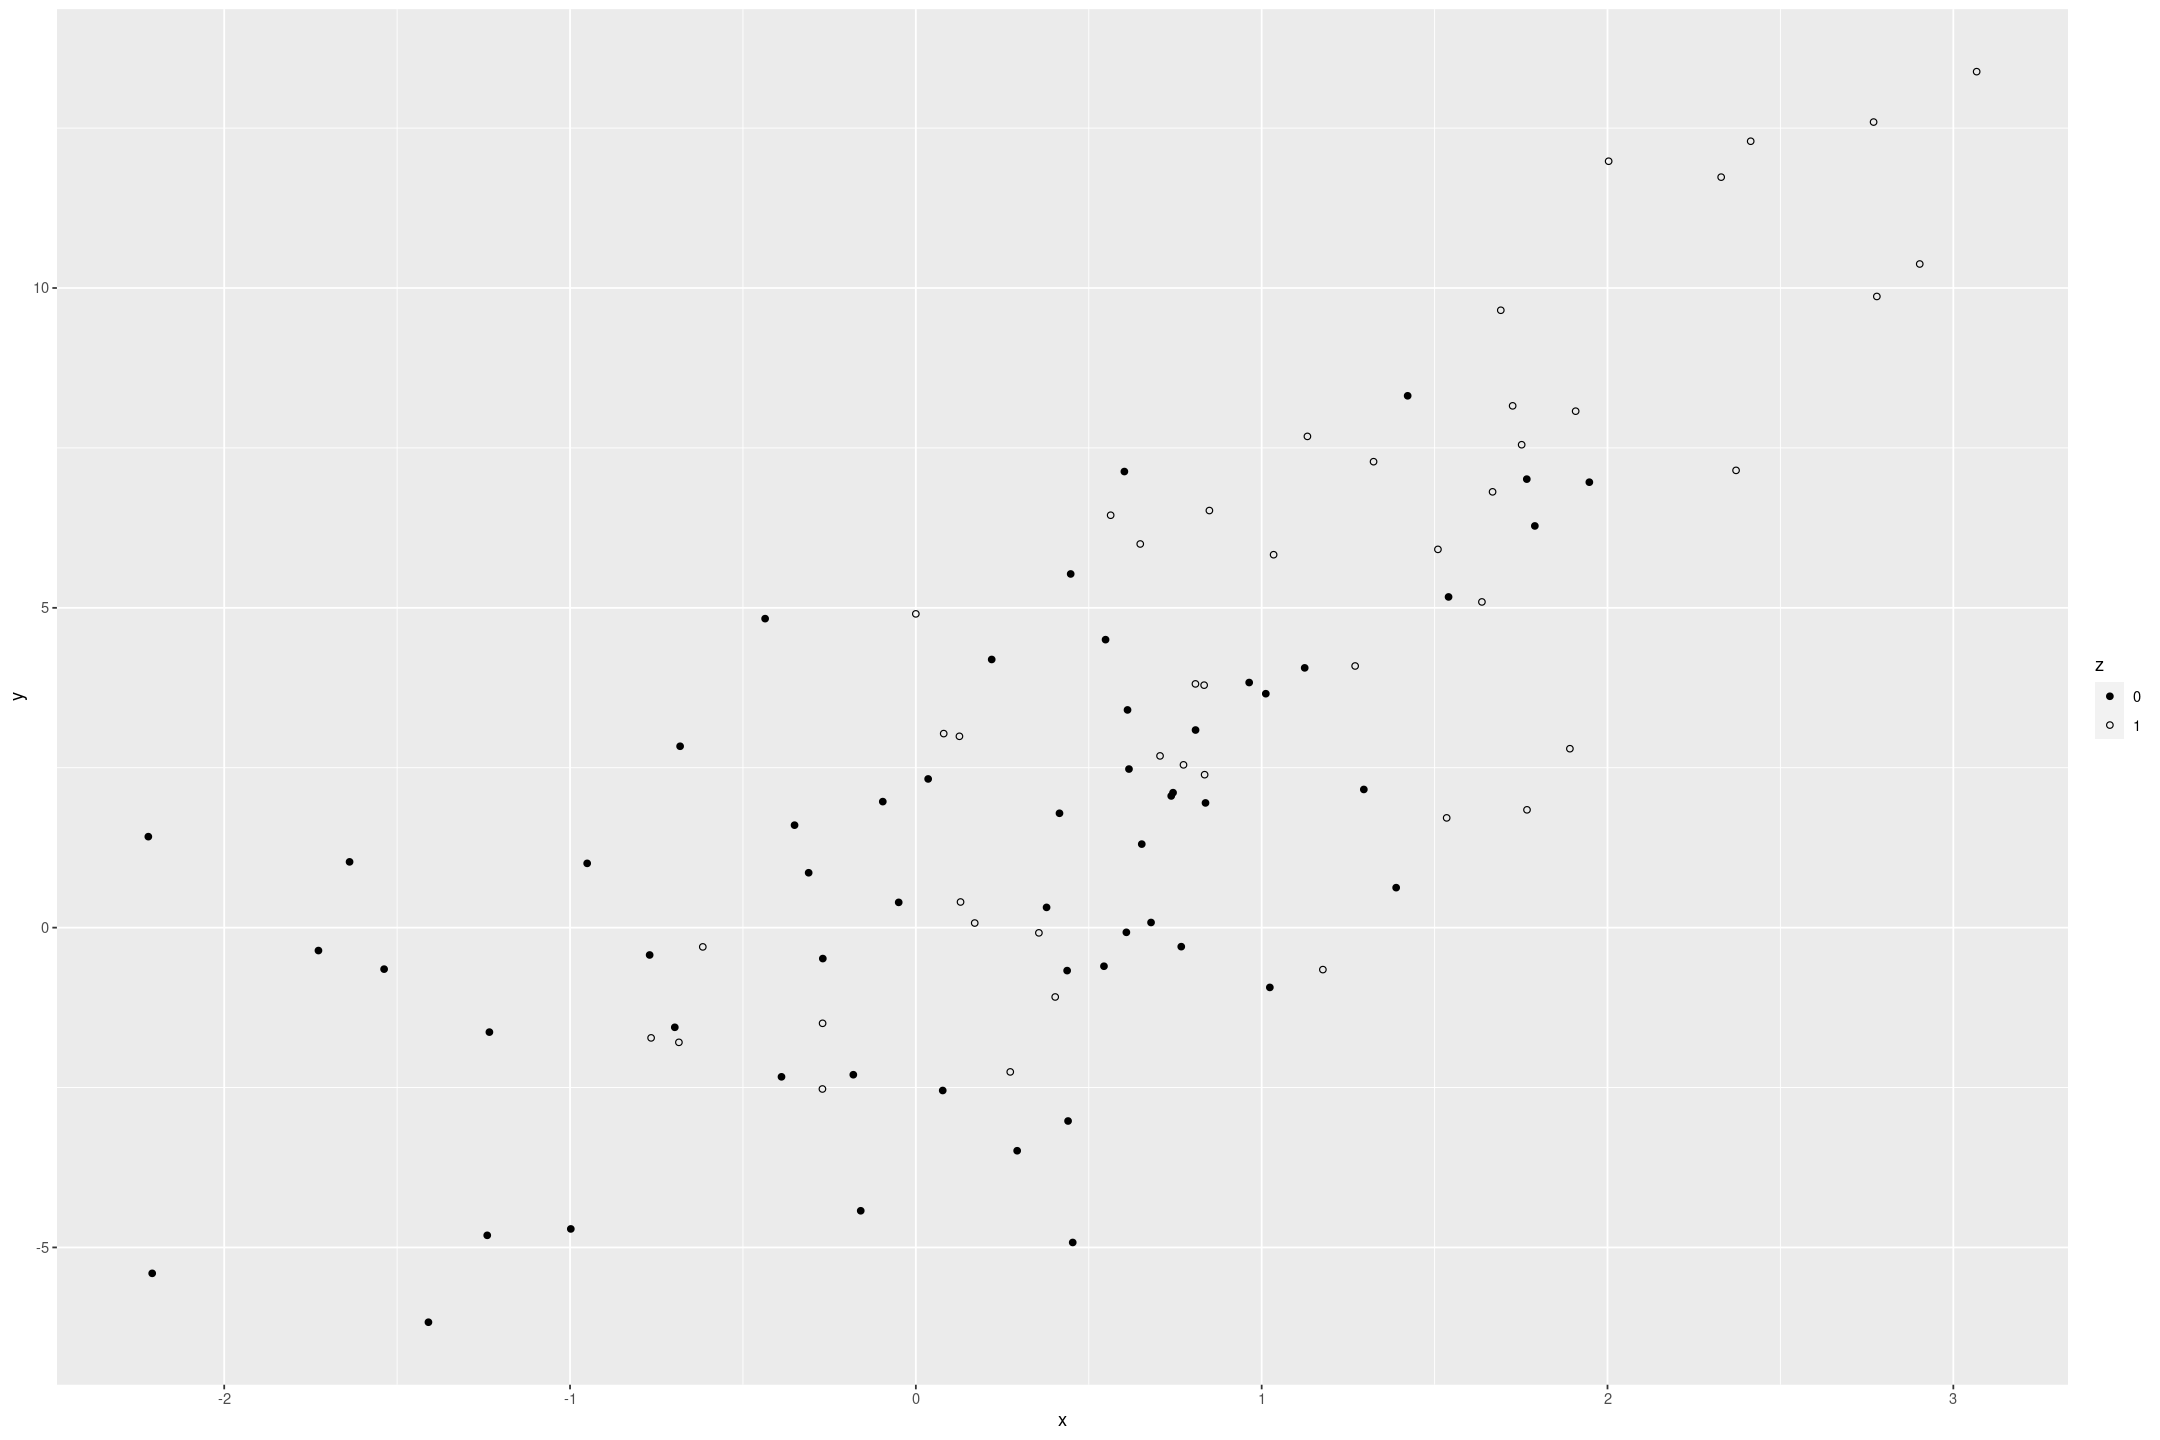

In [5]:
gf_point(y ~ x, shape=~z, data=fake_data) +
scale_shape_manual(values=c(19, 1))

## Regression without an interaction
Fit a regression predicting $y$ from $x$ and $z$ with no interaction.
Make a graph with the data and two parallel lines showing the fitted model.

In [6]:
fake_nointeraction <- stan_glm(y ~ x + z, data=fake_data, refresh=0)

In [7]:
print(fake_nointeraction)

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x + z
 observations: 100
 predictors:   3
------
            Median MAD_SD
(Intercept) 0.6    0.4   
x           2.7    0.3   
z1          1.1    0.6   

Auxiliary parameter(s):
      Median MAD_SD
sigma 2.8    0.2   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [8]:
coef_intercept = coef(fake_nointeraction)[["(Intercept)"]]
coef_x = coef(fake_nointeraction)[["x"]]
coef_z1 = coef(fake_nointeraction)[["z1"]]

c(coef_intercept, coef_x, coef_z1)

[1] 0.595039 2.715582 1.071411

It looks stange because the grey line corresponding to z=1 doesn't seem to have the right slope (looking at points at the top right).

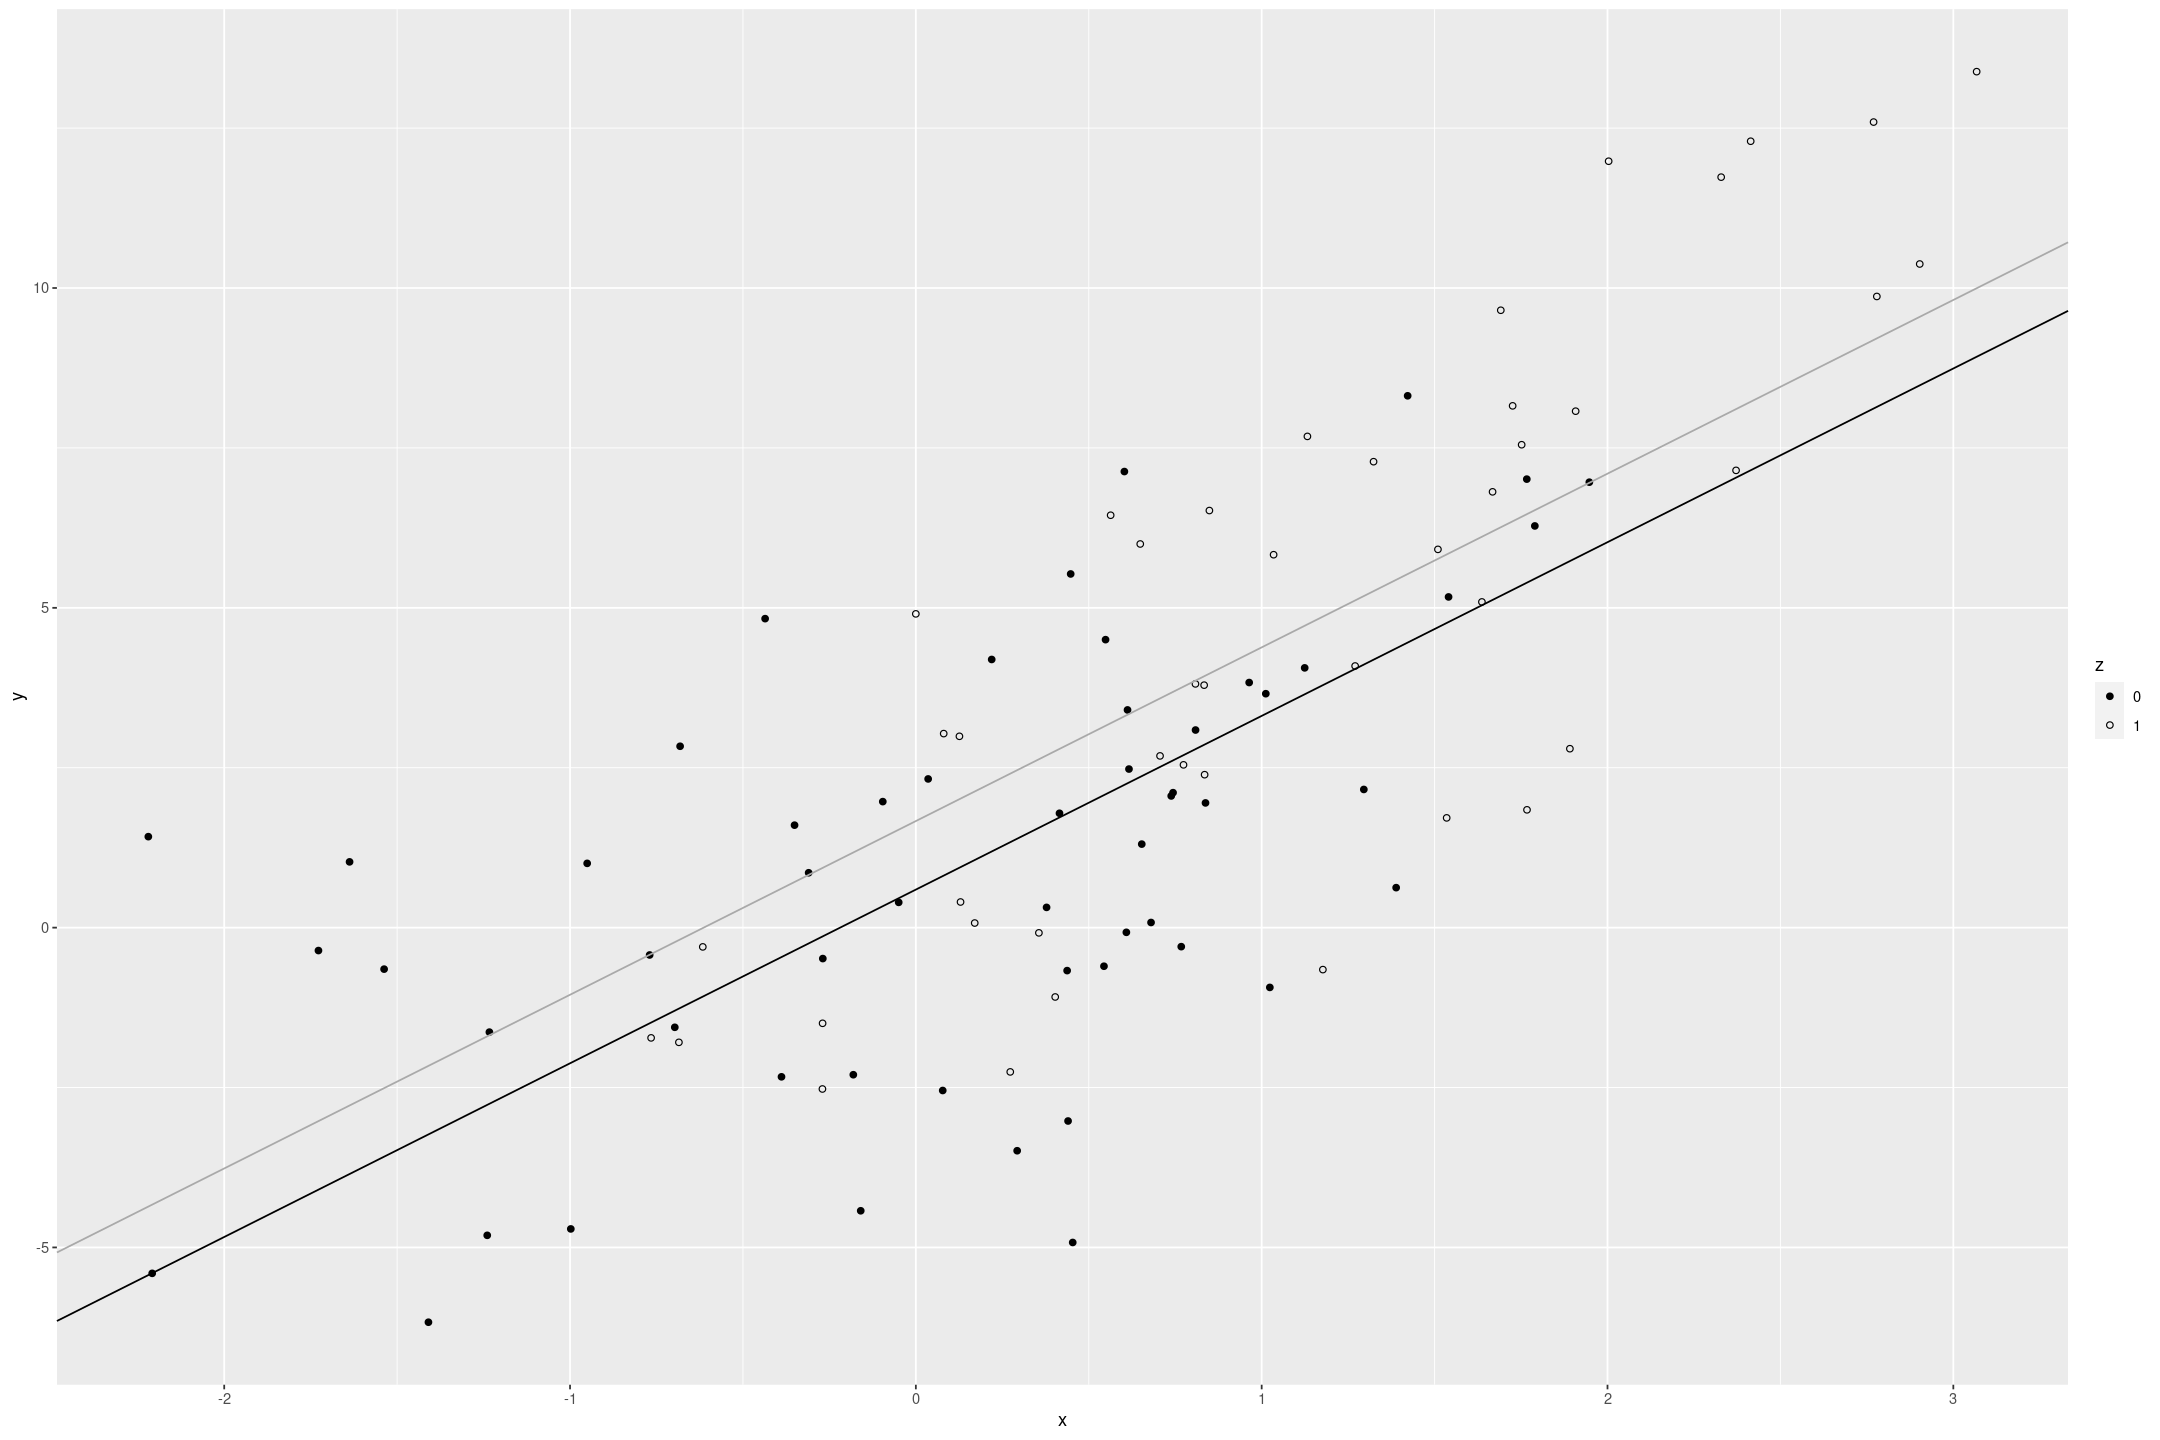

In [9]:
gf_point(y ~ x, shape=~z, data=fake_data) +
scale_shape_manual(values=c(19, 1)) +
geom_abline(intercept=coef_intercept, slope=coef_x) +
geom_abline(intercept=coef_intercept + coef_z1, slope=coef_x, colour="darkgrey")

## Regression with an interaction
Fit a regression predicting $y$ from $x$, $z$, and their interaction.
Make a graph with the data and two lines showing the fitted model.

In [10]:
fake_interaction <- stan_glm(y ~ x + z + x:z, data=fake_data, refresh=0)

In the ballpark of (1,2,-1,2)

In [11]:
print(fake_interaction)

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x + z + x:z
 observations: 100
 predictors:   4
------
            Median MAD_SD
(Intercept)  0.7    0.4  
x            1.9    0.4  
z1          -0.1    0.7  
x:z1         1.7    0.6  

Auxiliary parameter(s):
      Median MAD_SD
sigma 2.7    0.2   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [12]:
coef_intercept = coef(fake_interaction)[["(Intercept)"]]
coef_x = coef(fake_interaction)[["x"]]
coef_z1 = coef(fake_interaction)[["z1"]]
coef_xz1 = coef(fake_interaction)[["x:z1"]]

c(coef_intercept, coef_x, coef_z1, coef_xz1)

[1]  0.7023513  1.9415099 -0.1347452  1.7479287

The resulting fit looks much better!

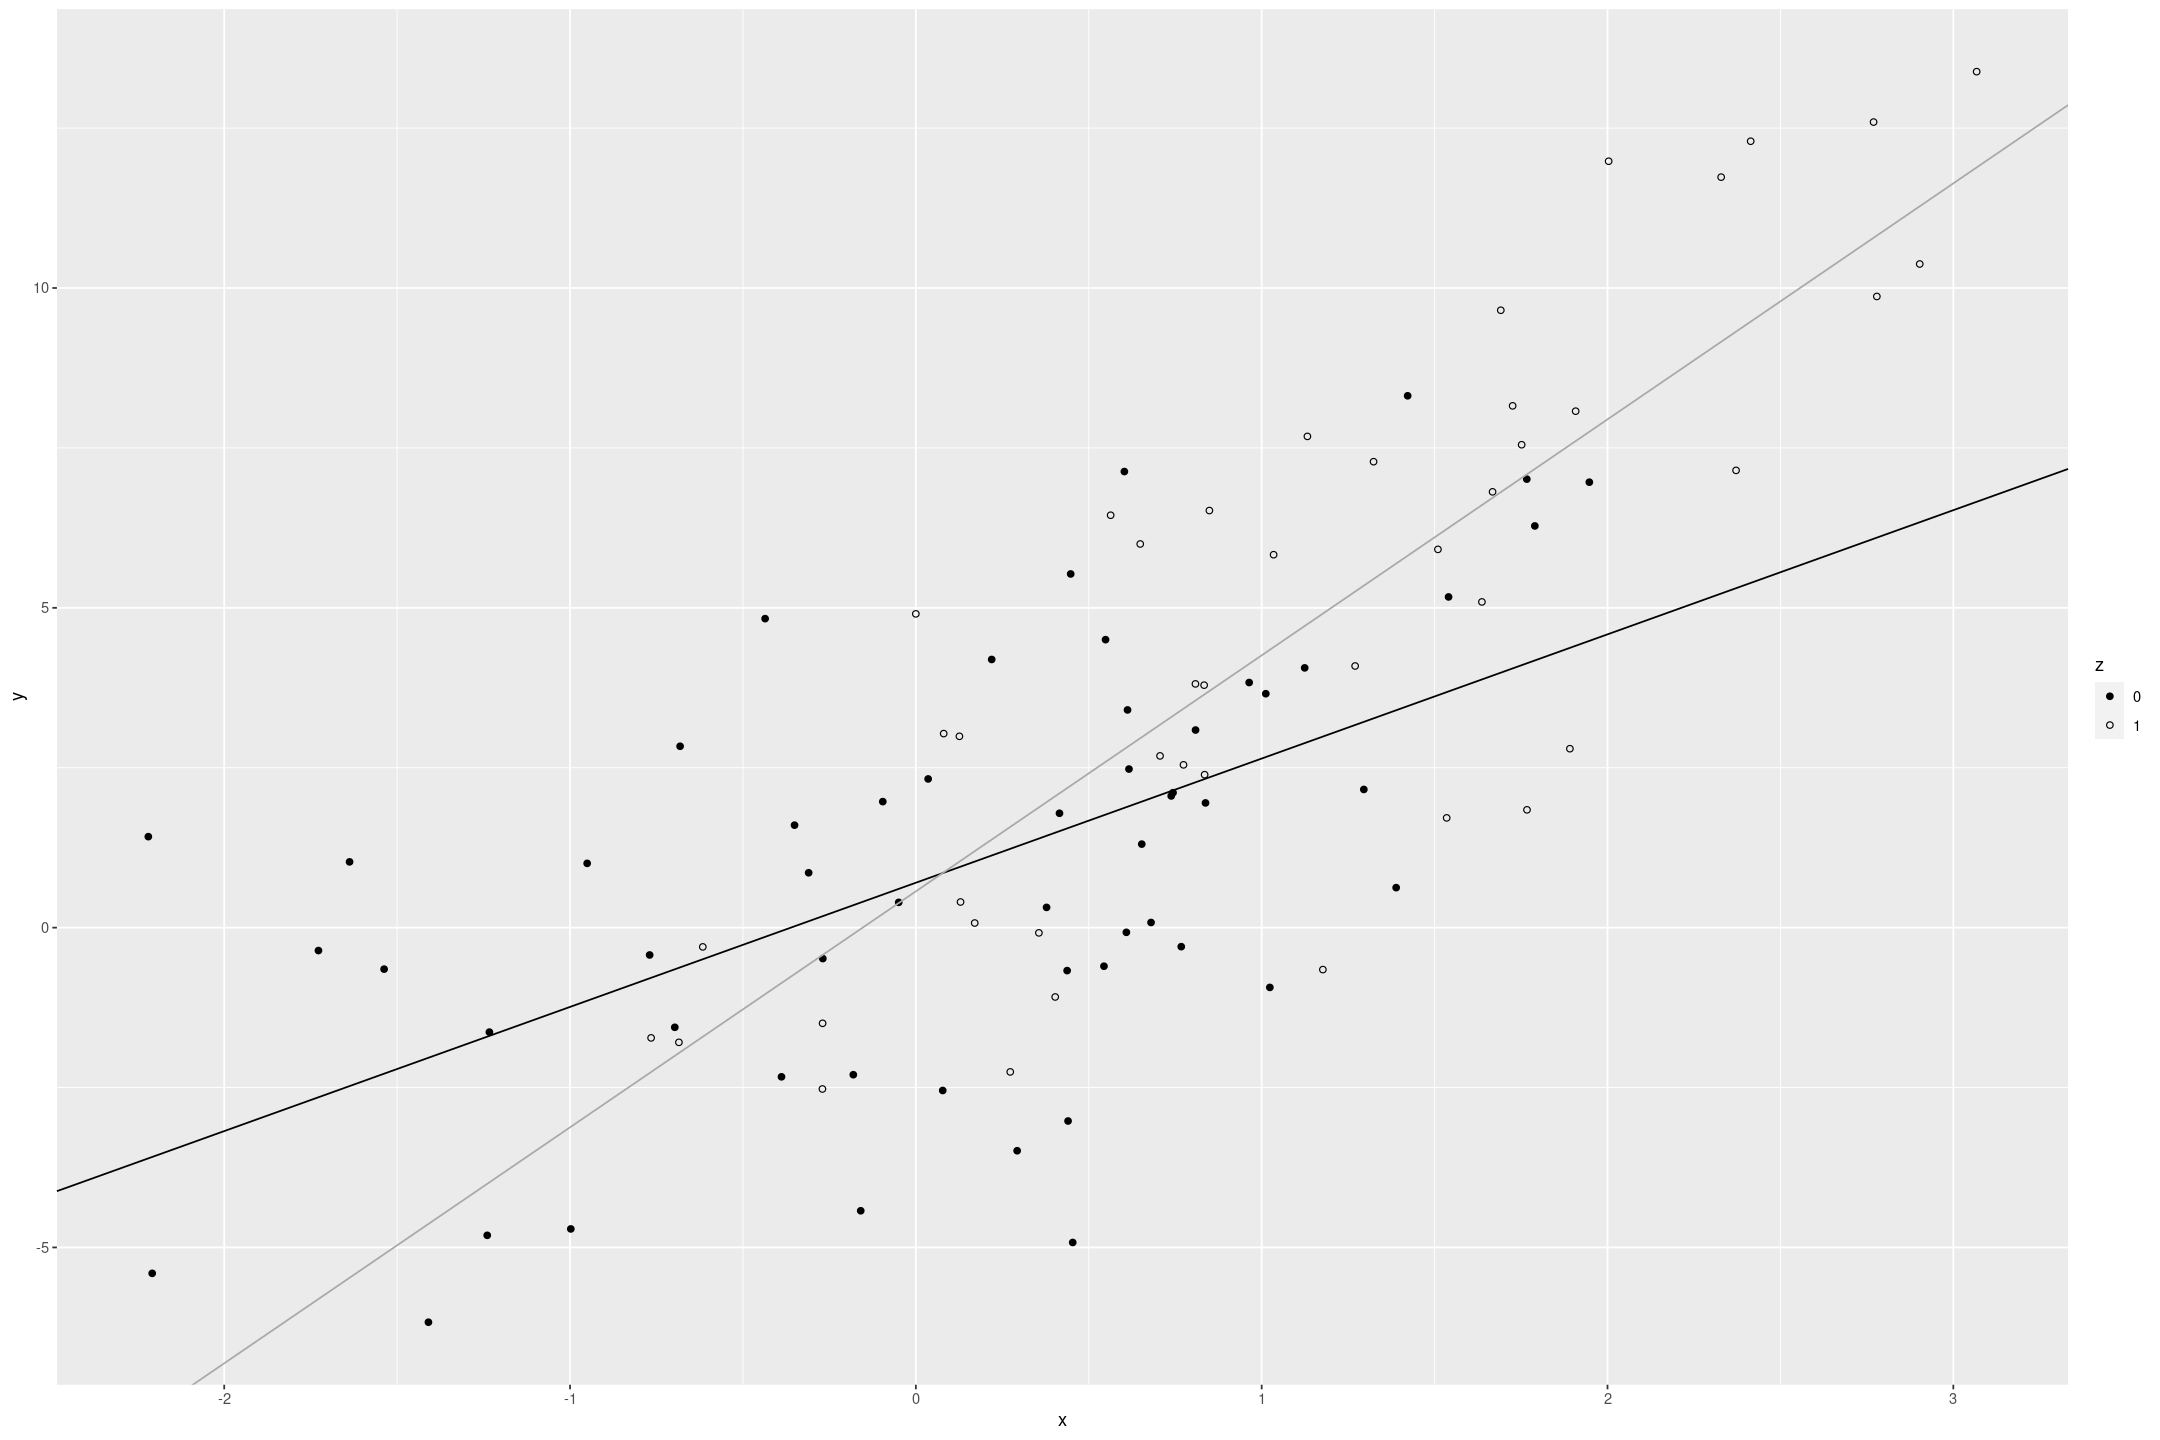

In [13]:
gf_point(y ~ x, shape=~z, data=fake_data) +
scale_shape_manual(values=c(19, 1)) +
geom_abline(intercept=coef_intercept, slope=coef_x) +
geom_abline(intercept=coef_intercept + coef_z1, slope=coef_x + coef_xz1, colour="darkgrey")

# Regresion with interactions

Here is the output from a fitted linear regression of outome y on pre-treatment predictor x, treatment indicator z, and their interaction:

```
            Median  MAD_SD
(Intercept) 1.2     0.2
x           1.6     0.4
z           2.7     0.3
x:z         0.7     0.5

Auxiliary parameter(s)
      Median  MAD_SD
sigma 0.5     0.0
```

## Equations

Write the equation of the estimated regression line of y on x for the treatment group and the control group.

For the control group the two terms with z drop out (by convention), giving $ y = 1.2 + 1.6x $.

For the treatment group we add the terms with z to get $ y = 3.9 + 2.3x $.

## Graphing by hand

Graph with pen and paper the two regression lines, assuming the values of x fall in the range (0, 10).
On this graph also include a scatterplot of data (using open circles for treated units and dots for controls) that are consistent with the fitted model.

Checking on the computer; I find estimating the sd hard

In [14]:
n <- 100
z <- sample(c(0,1), n, replace=TRUE)
x <- runif(n, 0, 10)

y <- 1.2 + 1.6*x + 2.7*z + 0.7*x*z + rnorm(n, 0, 0.5)

fake_data <- tibble(x=x, z=as.factor(z), y=y)

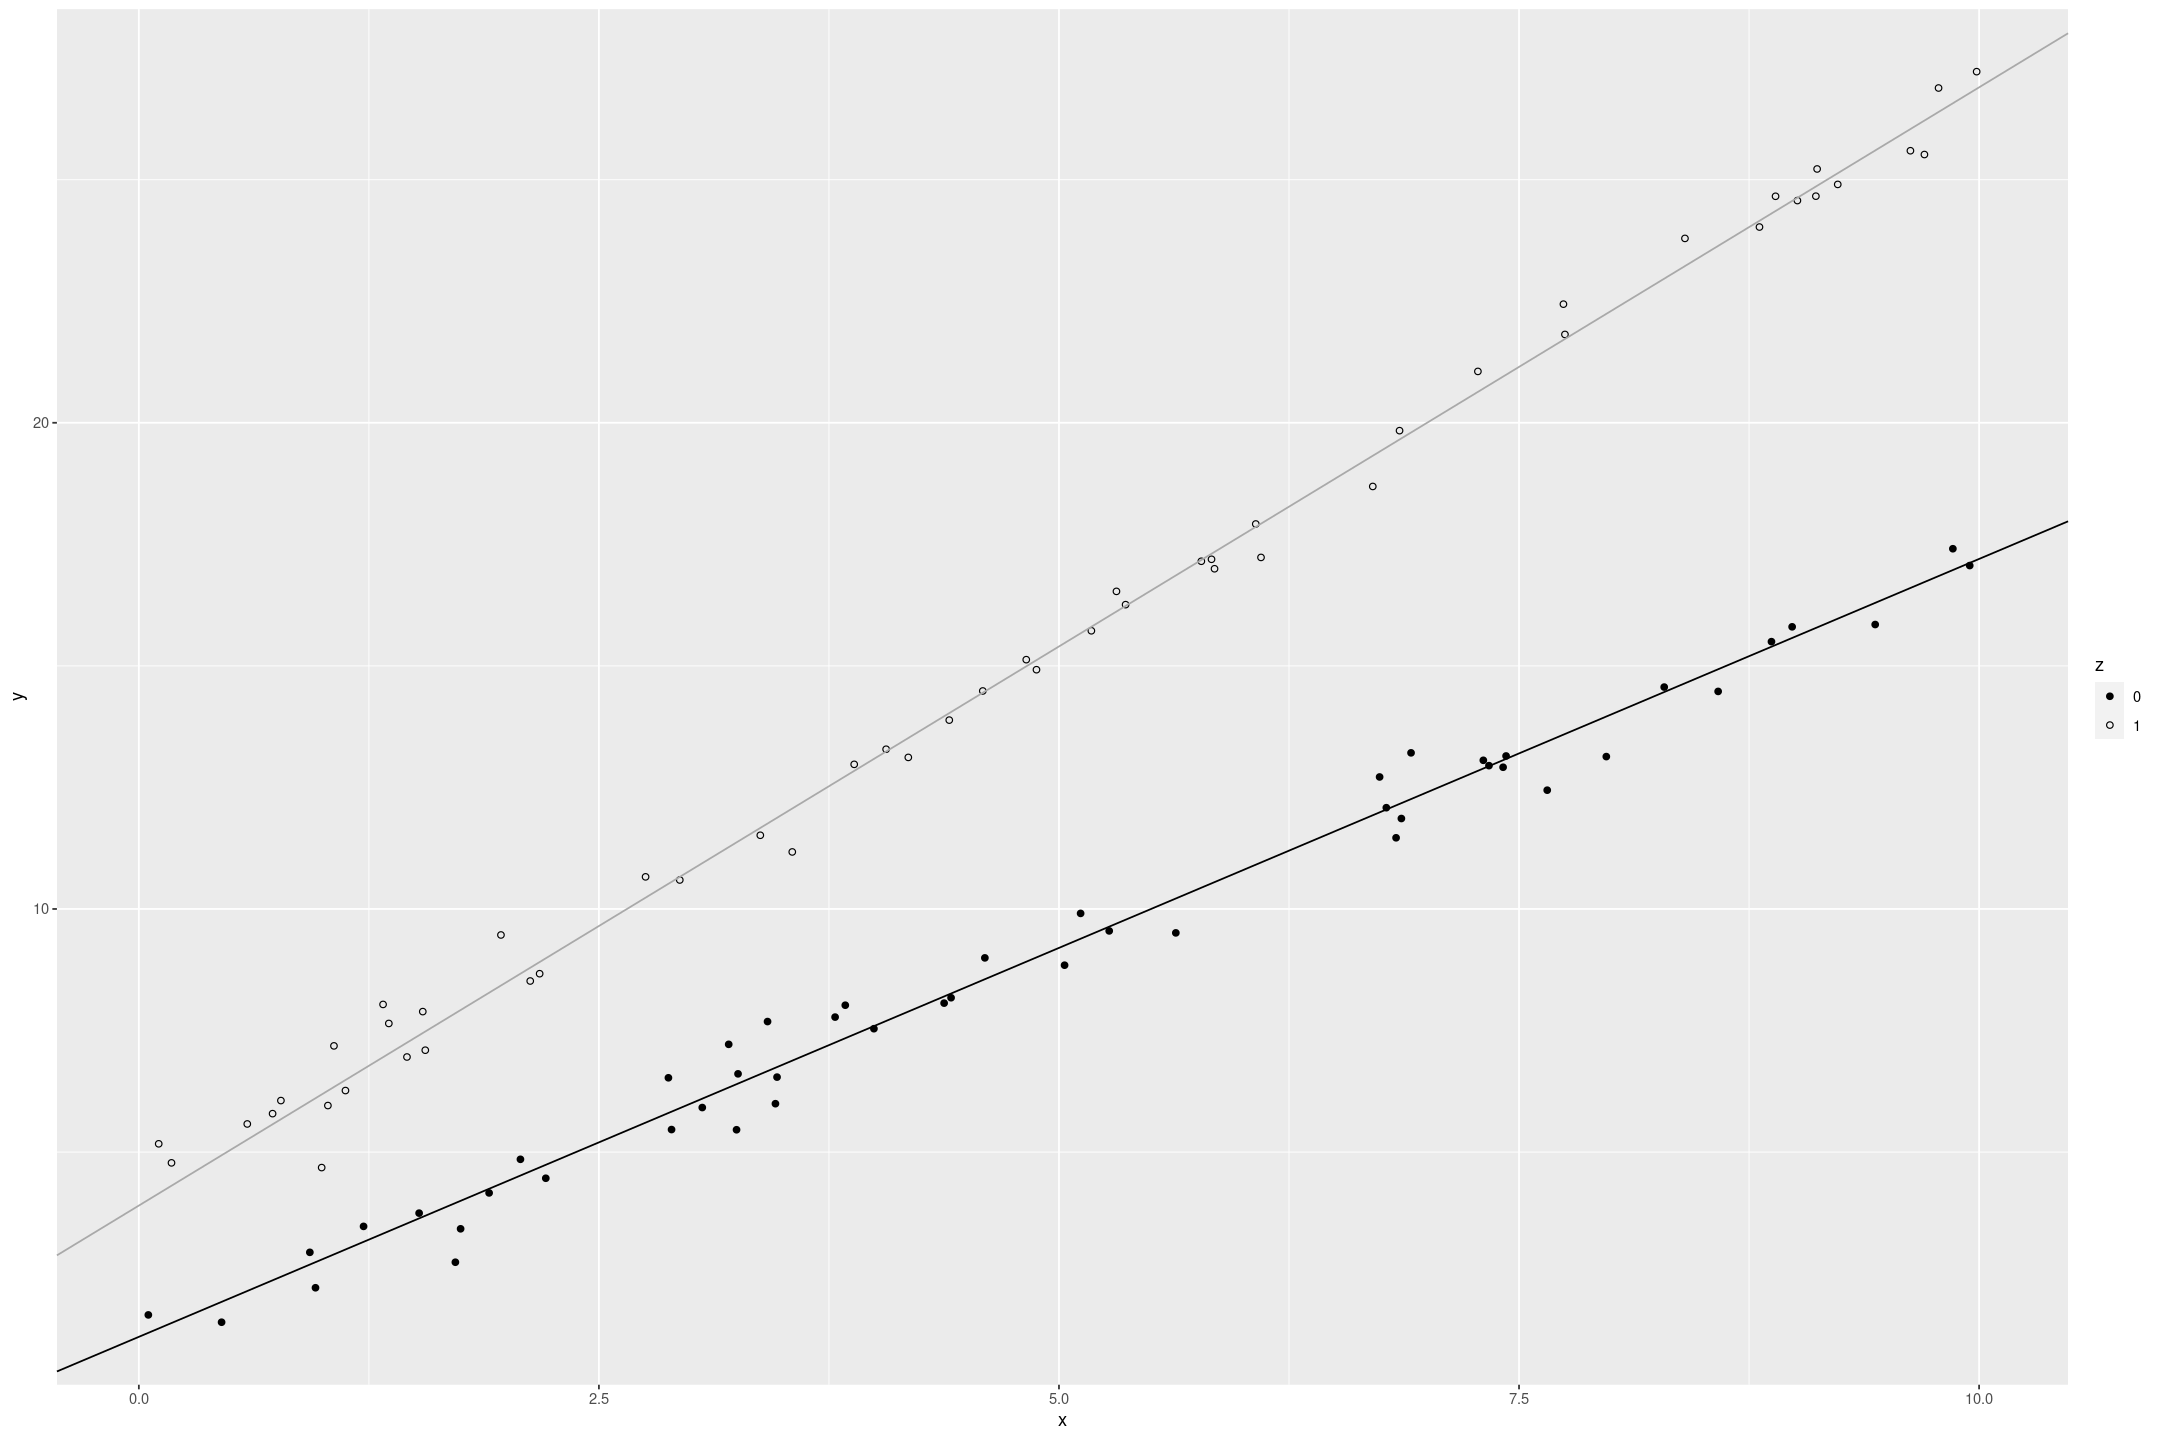

In [15]:
gf_point(y ~ x, shape=~z, data=fake_data) +
scale_shape_manual(values=c(19, 1)) +
geom_abline(intercept=1.2, slope=1.6) +
geom_abline(intercept=3.9, slope=2.3, colour="darkgrey")

# Checking statistical significance
In this exercise and the next, you will simulate two variables that are statistically independent of each other to see what happens when we run a regression to predict one from the other.
Generate 1000 data points from a normal distribution with mean 0 and standard deviation 1 by typing `var1 <- rnorm(1000,0,1)` in R.
Generate another variable in the same way (call it `var2`).
Run a regression of one variable on the other.
Is the slope coefficient "statistically significant"?
We do not recommend summarizing regressions in this way, but it can ber useful to understand how this works, given that others will do so.

In [16]:
var1 <- rnorm(1000,0,1)
var2 <- rnorm(1000,0,1)

data = data.frame(x=var1, y=var2)

model <- stan_glm(y~x, data=data, refresh=0)

print(model, digits=3)

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x
 observations: 1000
 predictors:   2
------
            Median MAD_SD
(Intercept)  0.001  0.031
x           -0.022  0.030

Auxiliary parameter(s):
      Median MAD_SD
sigma 1.018  0.023 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


Let's extract the median and the MAD

In [17]:
x_draws <- as.matrix(model)[,"x"]
c(median(x_draws), mad(x_draws))

[1] -0.02210635  0.03049889

The t-value is the number of standard deviations from the coefficient is from the mean

In [18]:
t <- median(x_draws) / mad(x_draws)
t

[1] -0.7248248

We can then calculate the area between -|t| and |t| under the standard normal distribution, and calculate the arithmetic complement to get the probability that by chance we'd get a larger error.

In [19]:
1 - (pnorm(abs(t)) - pnorm(-abs(t)))

[1] 0.4685595

Since this is greater than 0.05 we'd say it's not statistically significant.

We can check this against `lm`

In [20]:
summary(lm(y~x, data=data))


Call:
lm(formula = y ~ x, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2625 -0.6699  0.0031  0.7012  4.1148 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.0008648  0.0322597   0.027    0.979
x           -0.0219124  0.0304517  -0.720    0.472

Residual standard error: 1.017 on 998 degrees of freedom
Multiple R-squared:  0.0005186,	Adjusted R-squared:  -0.0004829 
F-statistic: 0.5178 on 1 and 998 DF,  p-value: 0.472


Statistical significance asks how many standard deviations the x coefficient is from 0

# Simulation study of statistical significance

Continuing the previous exercise, run a simulation repeating this process 100 times.
This can be done using a loop.
From each simulation, save the z-score (The estimated coefficient of `var1` divided by its standard error).
If the absolute value of the z-score exceeds 2, the estimate is "statistically significant".

How many of these 100 z-scores exceed 2 in absolute value, thus achieving the conventional level of statistical significance?

I'll use replicte instead of the suggested loop; it's much the same outcome, but nicer having a function that can be independently called.

In [21]:
random_zscore <- function() {
    var1 <- rnorm(1000,0,1)
    var2 <- rnorm(1000,0,1)
    fake <- data.frame(var1, var2)
    fit <- stan_glm(var2 ~ var1, data=fake, refresh=0)
    coef(fit)[[2]] / se(fit)[[2]]
}

In [22]:
zscores <- replicate(100, random_zscore())

In [23]:
length(zscores)

[1] 100

There are close to the expected 5% false positive rate where the correlation is "statistically significant".

In [24]:
sum(abs(zscores) > 2)

[1] 4

# Regression modeling and prediction

The folder [KidIQ](https://github.com/avehtari/ROS-Examples/tree/master/KidIQ/) contains a subset of the children and mother data discussed earlier in the chapter.
You have access to children's test scores at age 3, mother's education, and the mother's age at the time she gave birth for a sample of 400 children.

In [25]:
filename <- "./data/KidIQ/kidiq.csv"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/KidIQ/data/kidiq.csv')
kidiq <- read.csv(filename)

kidiq

kid_score,mom_hs,mom_iq,mom_work,mom_age
<int>,<int>,<dbl>,<int>,<int>
65,1,121.11753,4,27
98,1,89.36188,4,25
85,1,115.44316,4,27
83,1,99.44964,3,25
115,1,92.74571,4,27
98,0,107.90184,1,18
69,1,138.89311,4,20
106,1,125.14512,3,23
102,1,81.61953,1,24


## Effect of Mother's Age
Fit a regression of child test scores on mother's age, display the data and fitted model, check assumptions, and interpret the slope coefficient.
Based on this analysis, when do you recommend mothers should give birth?
What are you assuming in making this reccomendation?

In [26]:
age_model <- stan_glm(kid_score ~ mom_age, data=kidiq, refresh=0)

print(age_model, digits=2)

stan_glm
 family:       gaussian [identity]
 formula:      kid_score ~ mom_age
 observations: 434
 predictors:   2
------
            Median MAD_SD
(Intercept) 70.94   8.30 
mom_age      0.69   0.36 

Auxiliary parameter(s):
      Median MAD_SD
sigma 20.34   0.70 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


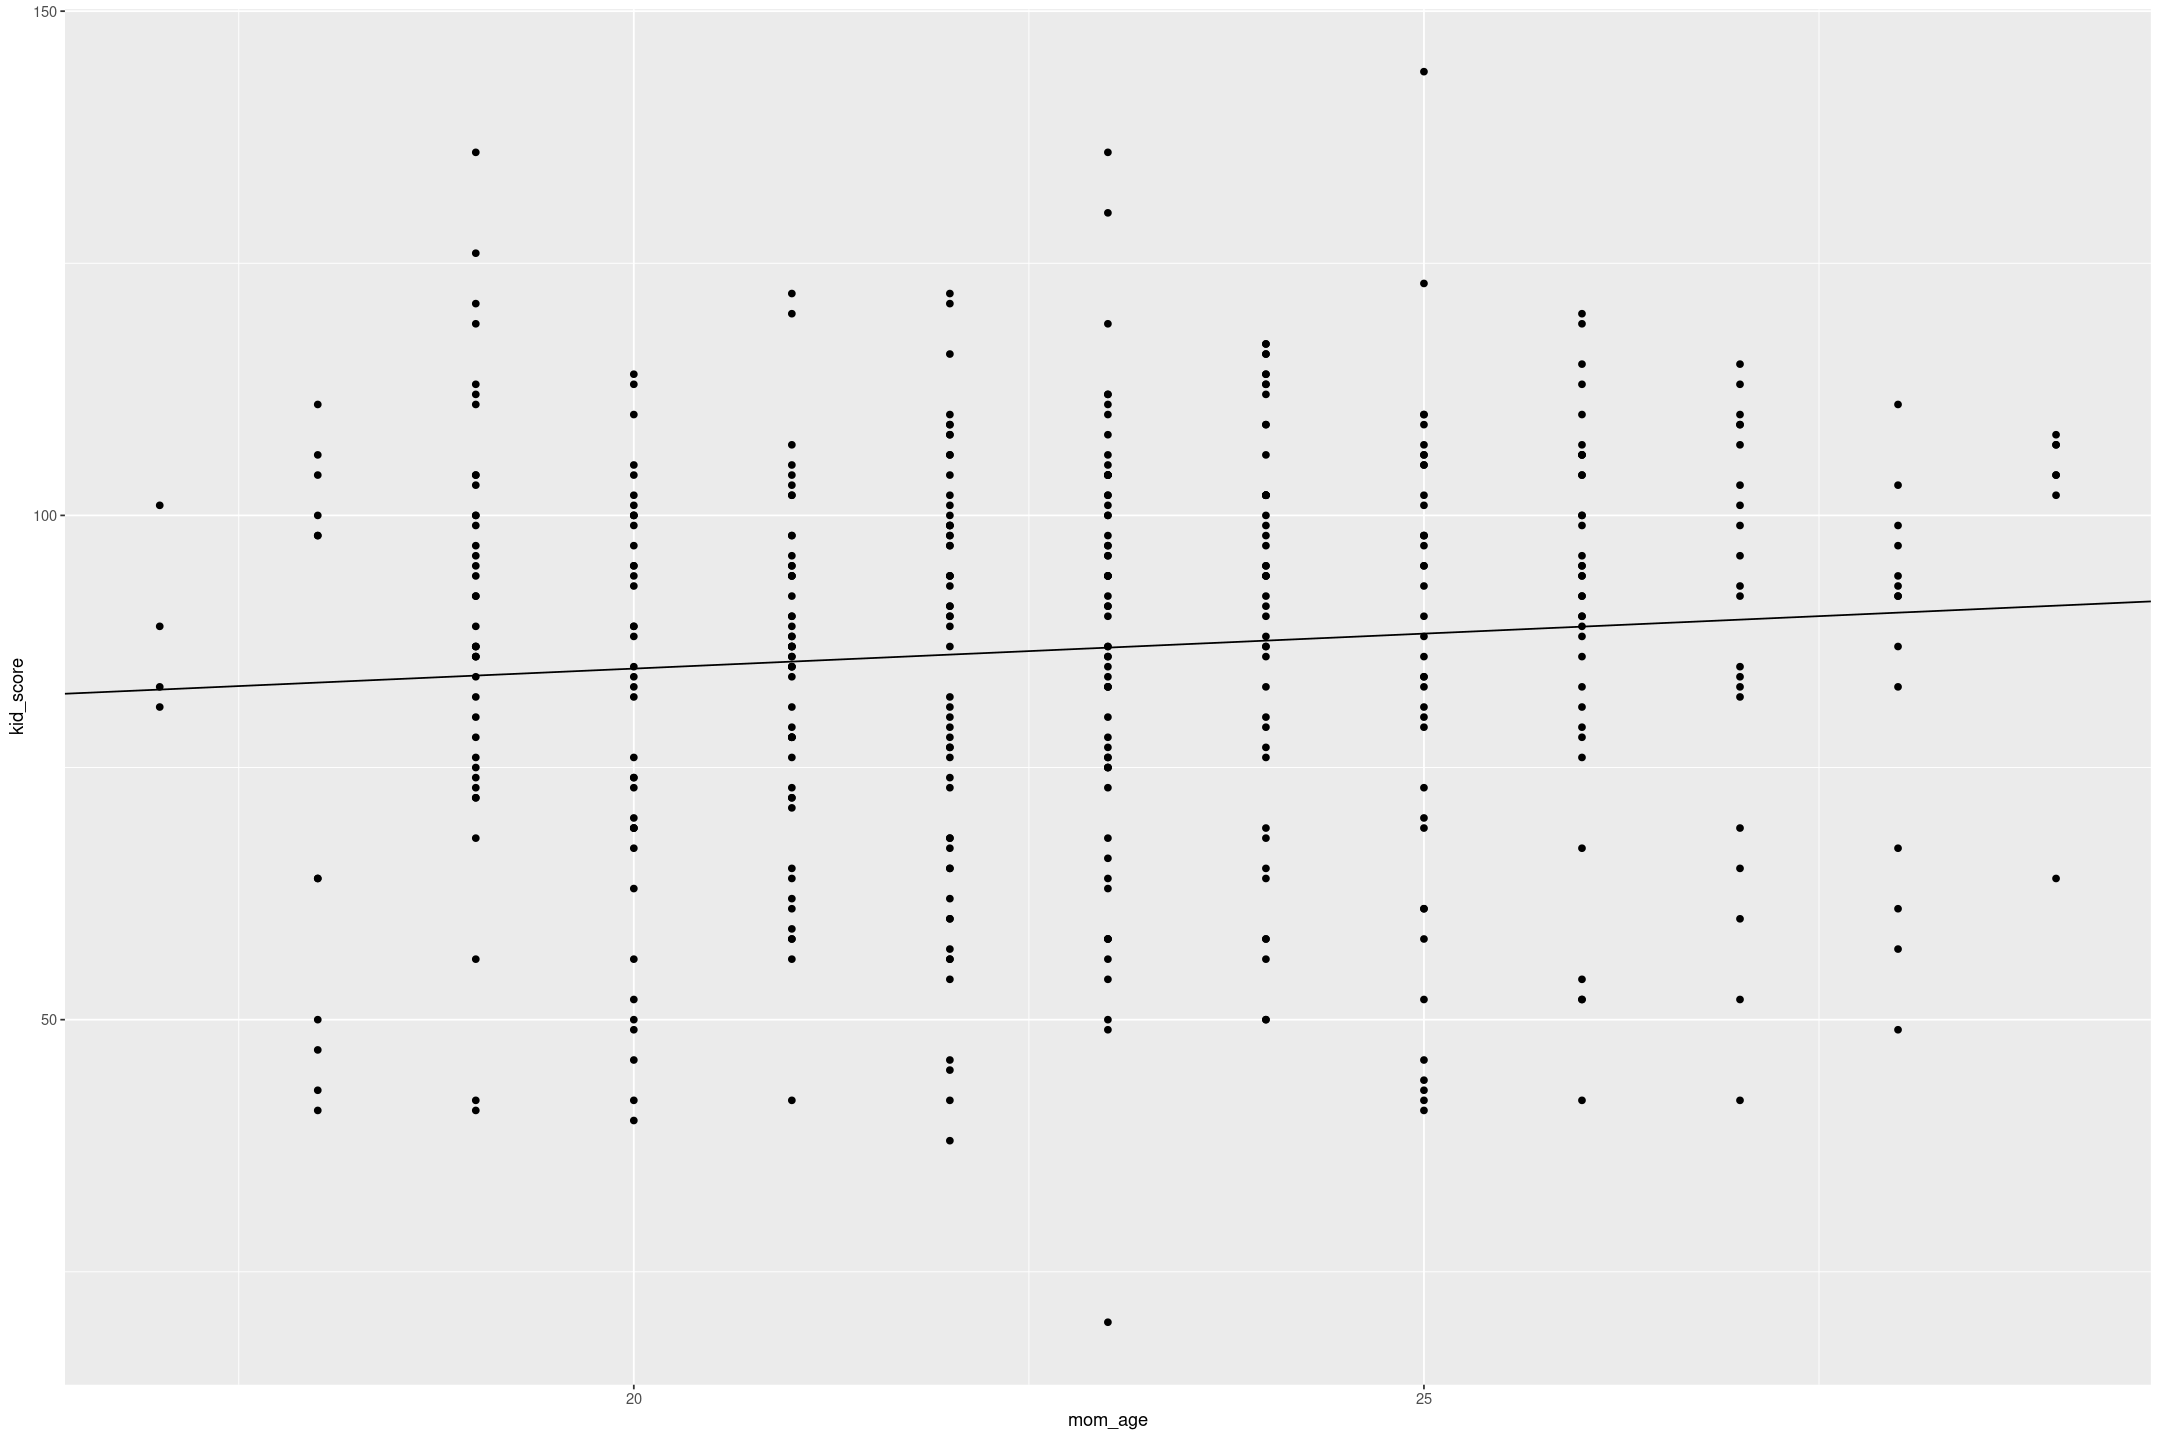

In [27]:
kidiq %>%
gf_point(kid_score ~ mom_age) %>%
gf_abline(intercept=~coef(age_model)[1], slope=~coef(age_model)[2])

This model says that when comparing two children, for every year older one of their mothers is, the child on average has 0.7 more IQ points (s.d. ~ 0.4).

If we assume the relation is causal (which is probably isn't), this would mean if you want your child to have a higher IQ have it closer to your 30s than your 20s.

## Adding effect of Mother's Education
Repeat this for a regression that further includes mother's education, interpreting both slope coefficients in this model.
Have your conclusions about the timing of birth changed?

In [28]:
age_hs_model <- stan_glm(kid_score ~ mom_age + mom_hs + mom_age:mom_hs, data=kidiq, refresh=0)

print(age_hs_model, digits=2)

stan_glm
 family:       gaussian [identity]
 formula:      kid_score ~ mom_age + mom_hs + mom_age:mom_hs
 observations: 434
 predictors:   4
------
               Median MAD_SD
(Intercept)    109.27  16.26
mom_age         -1.47   0.75
mom_hs         -39.75  18.39
mom_age:mom_hs   2.33   0.82

Auxiliary parameter(s):
      Median MAD_SD
sigma 19.71   0.67 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


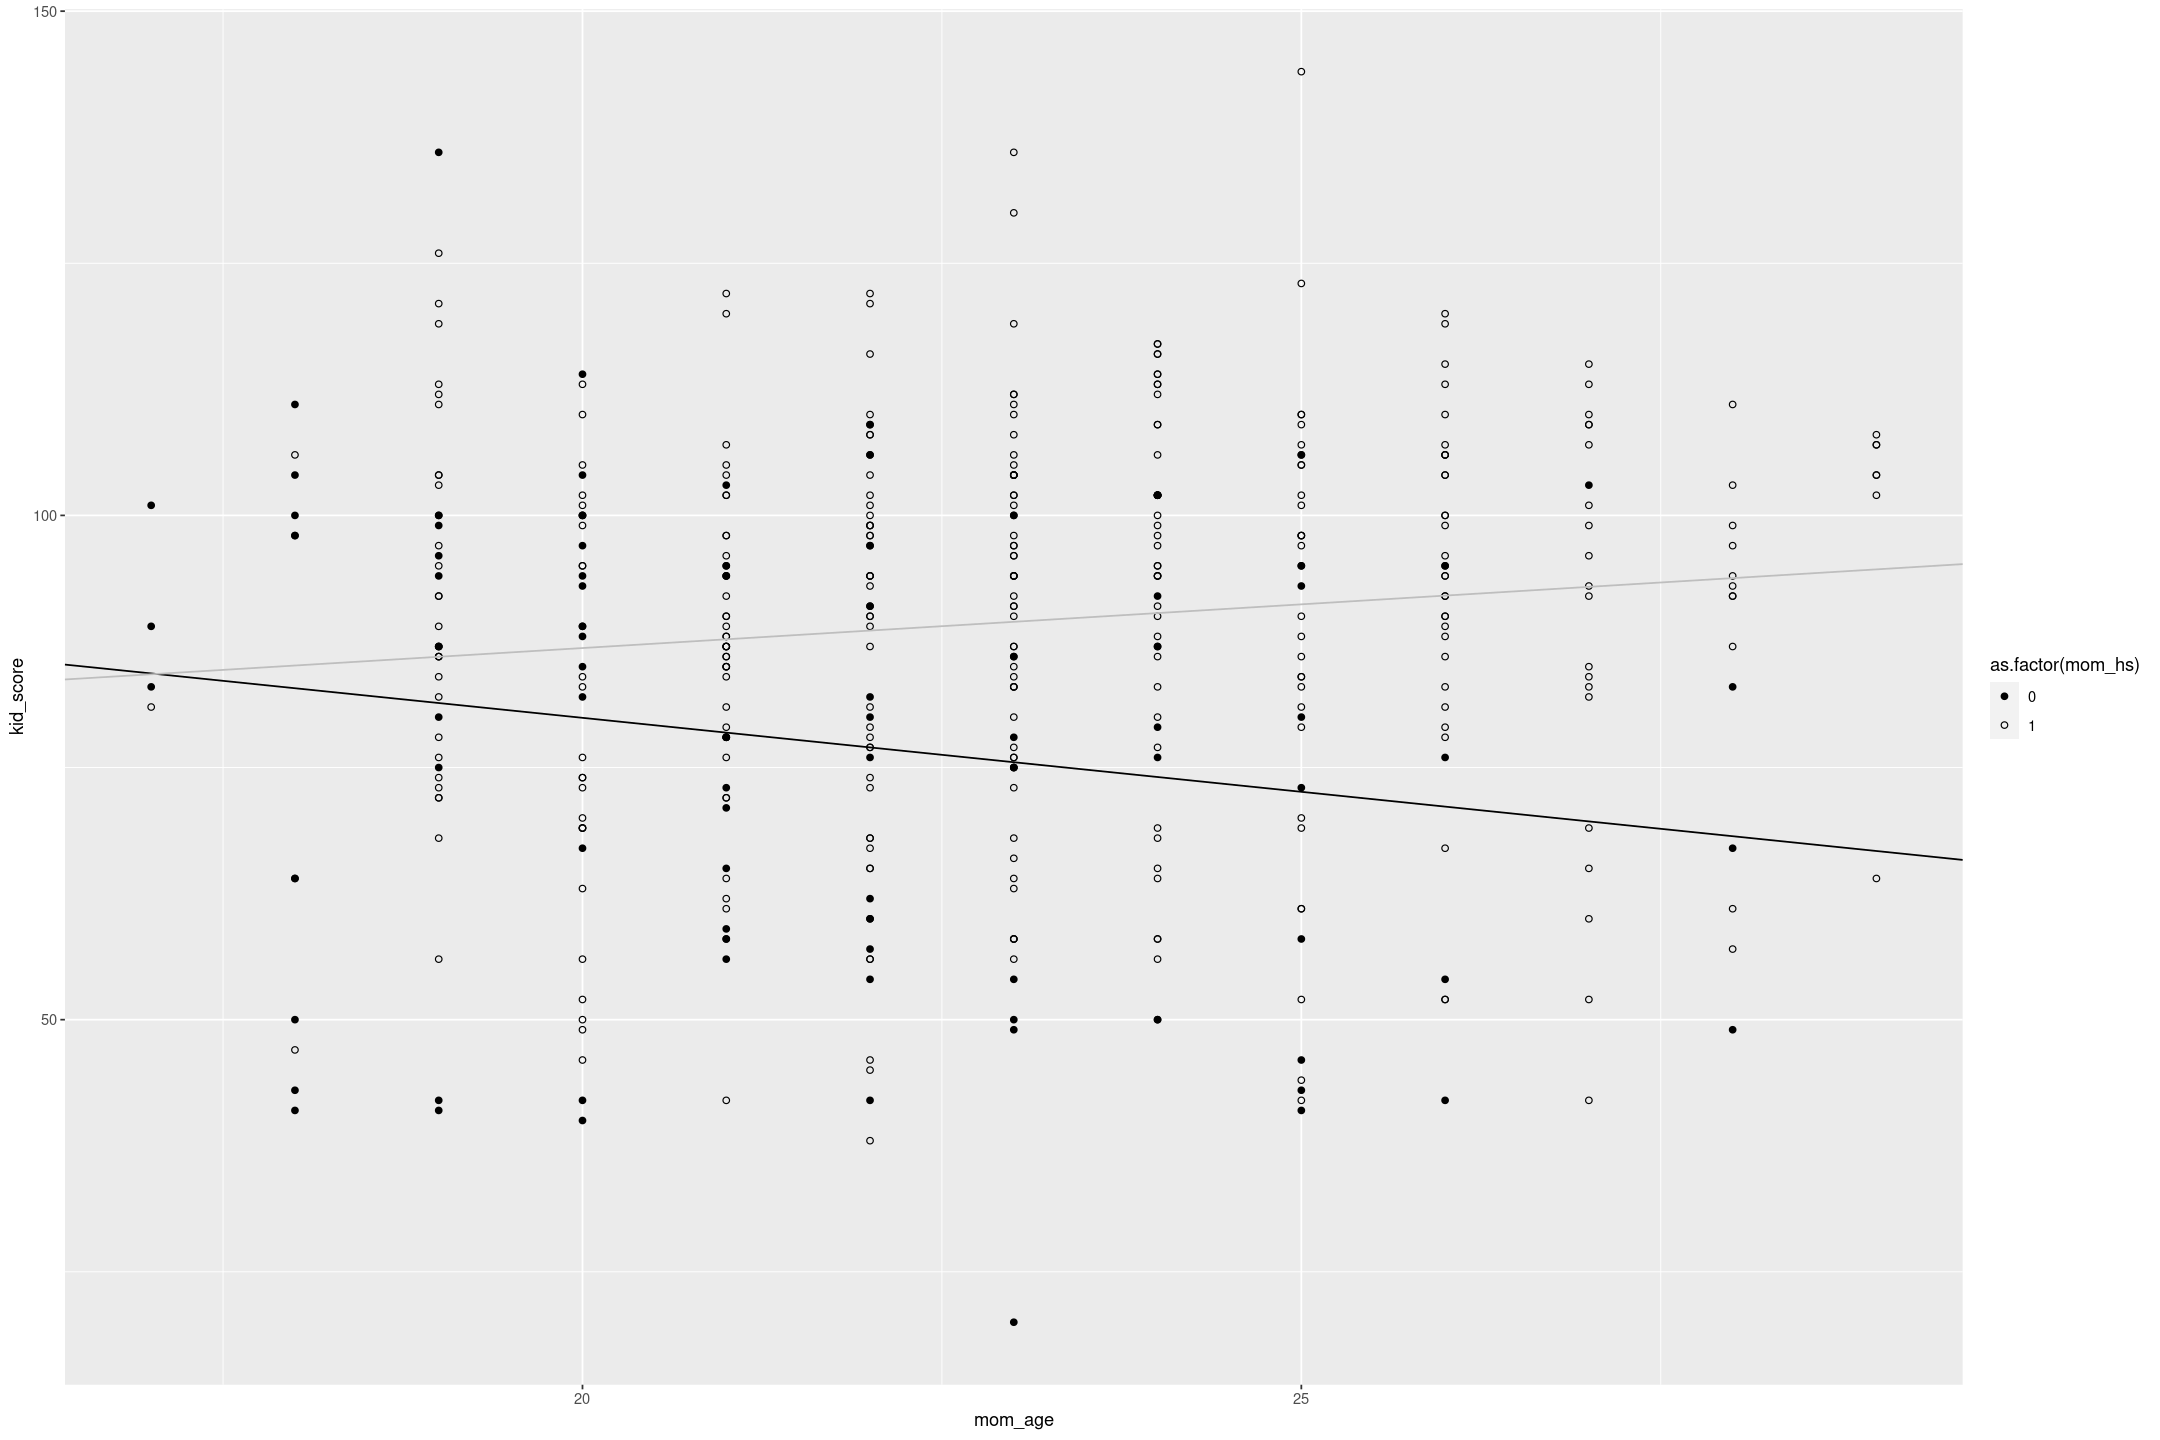

In [29]:
kidiq %>%
gf_point(kid_score ~ mom_age, shape=~as.factor(mom_hs)) %>%
gf_abline(intercept=~coef(age_hs_model)["(Intercept)"], slope=~coef(age_hs_model)["mom_age"]) %>%
gf_abline(intercept=~coef(age_hs_model)["(Intercept)"] + coef(age_hs_model)["mom_hs"], slope=~coef(age_hs_model)["mom_age"] + coef(age_hs_model)["mom_age:mom_hs"], col="grey") +
scale_shape_manual(values=c(19, 1))

Once we include the factor of highschool completion the picture is very different.

Comparing two children from the sample, if one has a mother with a highschool education and the other does not, then the first will on average have an IQ 39 points higher (though note the large s.d.: 18.5).

In the sample the child's IQ decreases with age of the mother if they didn't complete highschool, and slowly increases if they did.

There's an interaction here that mothers who completed highschool in the sample tend to have children at an older age than those who don't.

Interestingly the two regression lines meet around highschool completion age - 17.
It would be useful to get information on further educational attainment to see if that further correlates with mothers age.

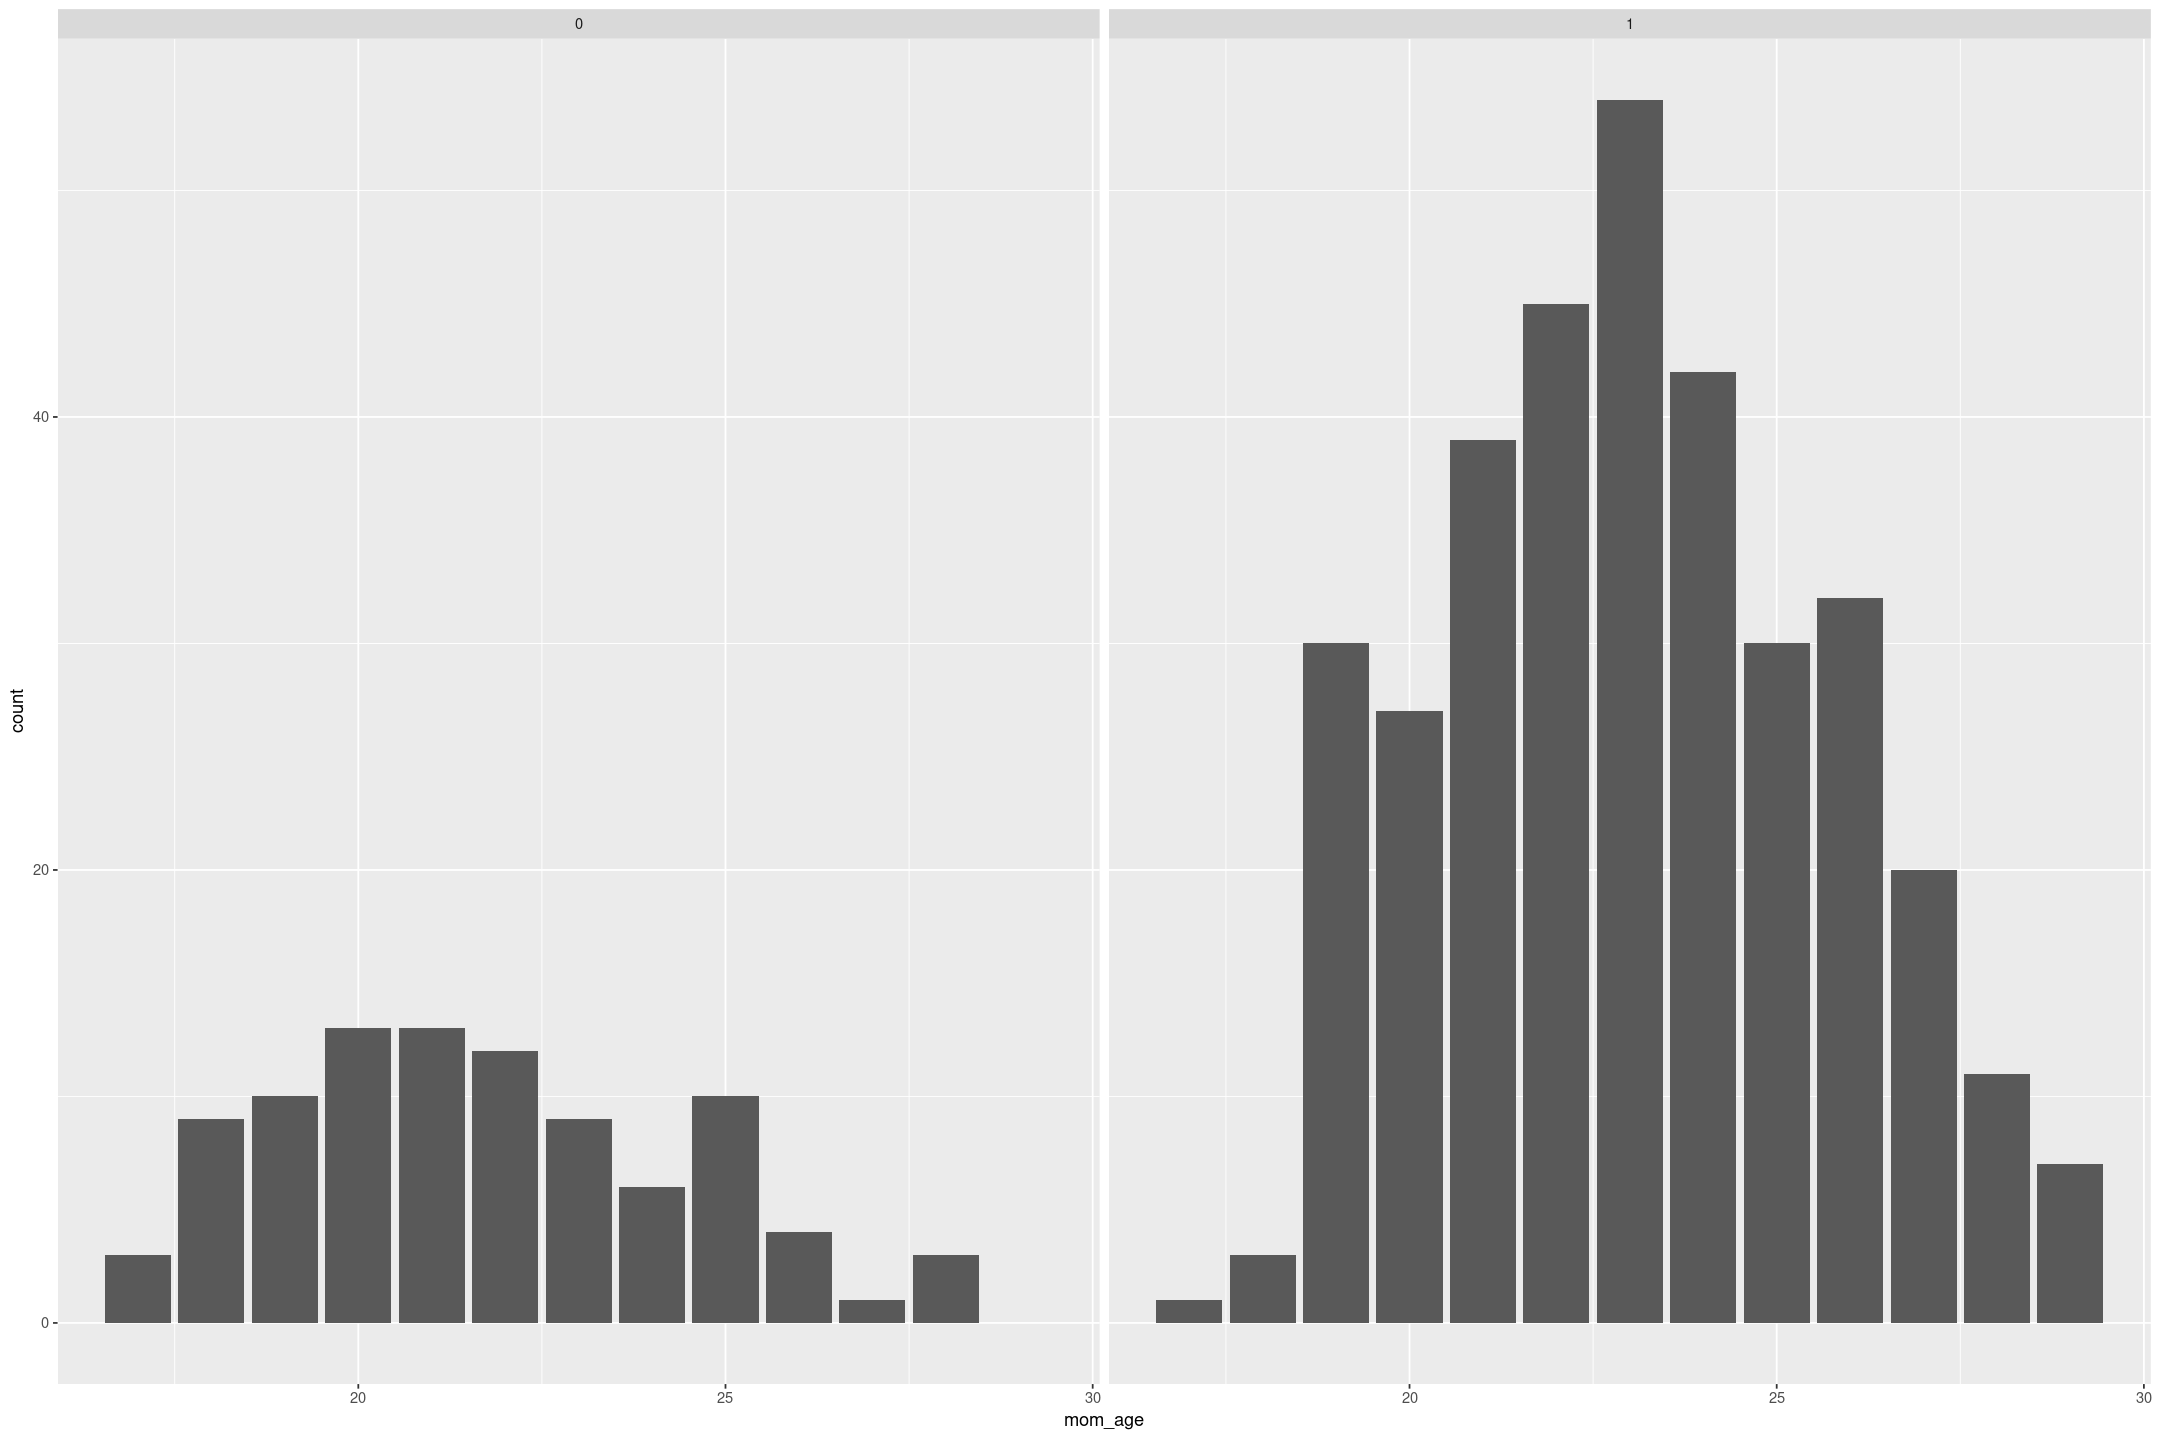

In [30]:
kidiq %>% gf_bar(~mom_age | mom_hs)

## Interpreting Mother's high school completion
Now create an indicator variable reflecting whether the mother has completed high school or not.
Consider interactions between high school completion and mother's age.
Also create a plot that shows the separate regression lines for each high school completion status group.

Isn't this the same as the previous section?

## Using model for prediction
Finally, fit a regression of child test scores on mother's age and education level for the first 200 children and use this model to predict test scores for the next 200.
Graphically display comparisons of the predicted and actual scores for the final 200 children.

In [31]:
kidiq_train <- kidiq[1:200,]
kidiq_test <- kidiq[201:400,]

In [32]:
age_hs_model <- stan_glm(kid_score ~ mom_age + mom_hs + mom_age:mom_hs, data=kidiq_train, refresh=0)

print(age_hs_model, digits=2)

stan_glm
 family:       gaussian [identity]
 formula:      kid_score ~ mom_age + mom_hs + mom_age:mom_hs
 observations: 200
 predictors:   4
------
               Median MAD_SD
(Intercept)    115.32  22.07
mom_age         -1.18   1.03
mom_hs         -36.58  24.72
mom_age:mom_hs   1.79   1.10

Auxiliary parameter(s):
      Median MAD_SD
sigma 17.57   0.89 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [33]:
kidiq_test$prediction <- predict(age_hs_model, newdata=kidiq_test)
kidiq_test <- kidiq_test %>% mutate(residual = kid_score - prediction)

The variation in childrens scores is very wide compared to the predictions.

They look pretty evenly spread on either side of the line, but cluster tighter to the left.

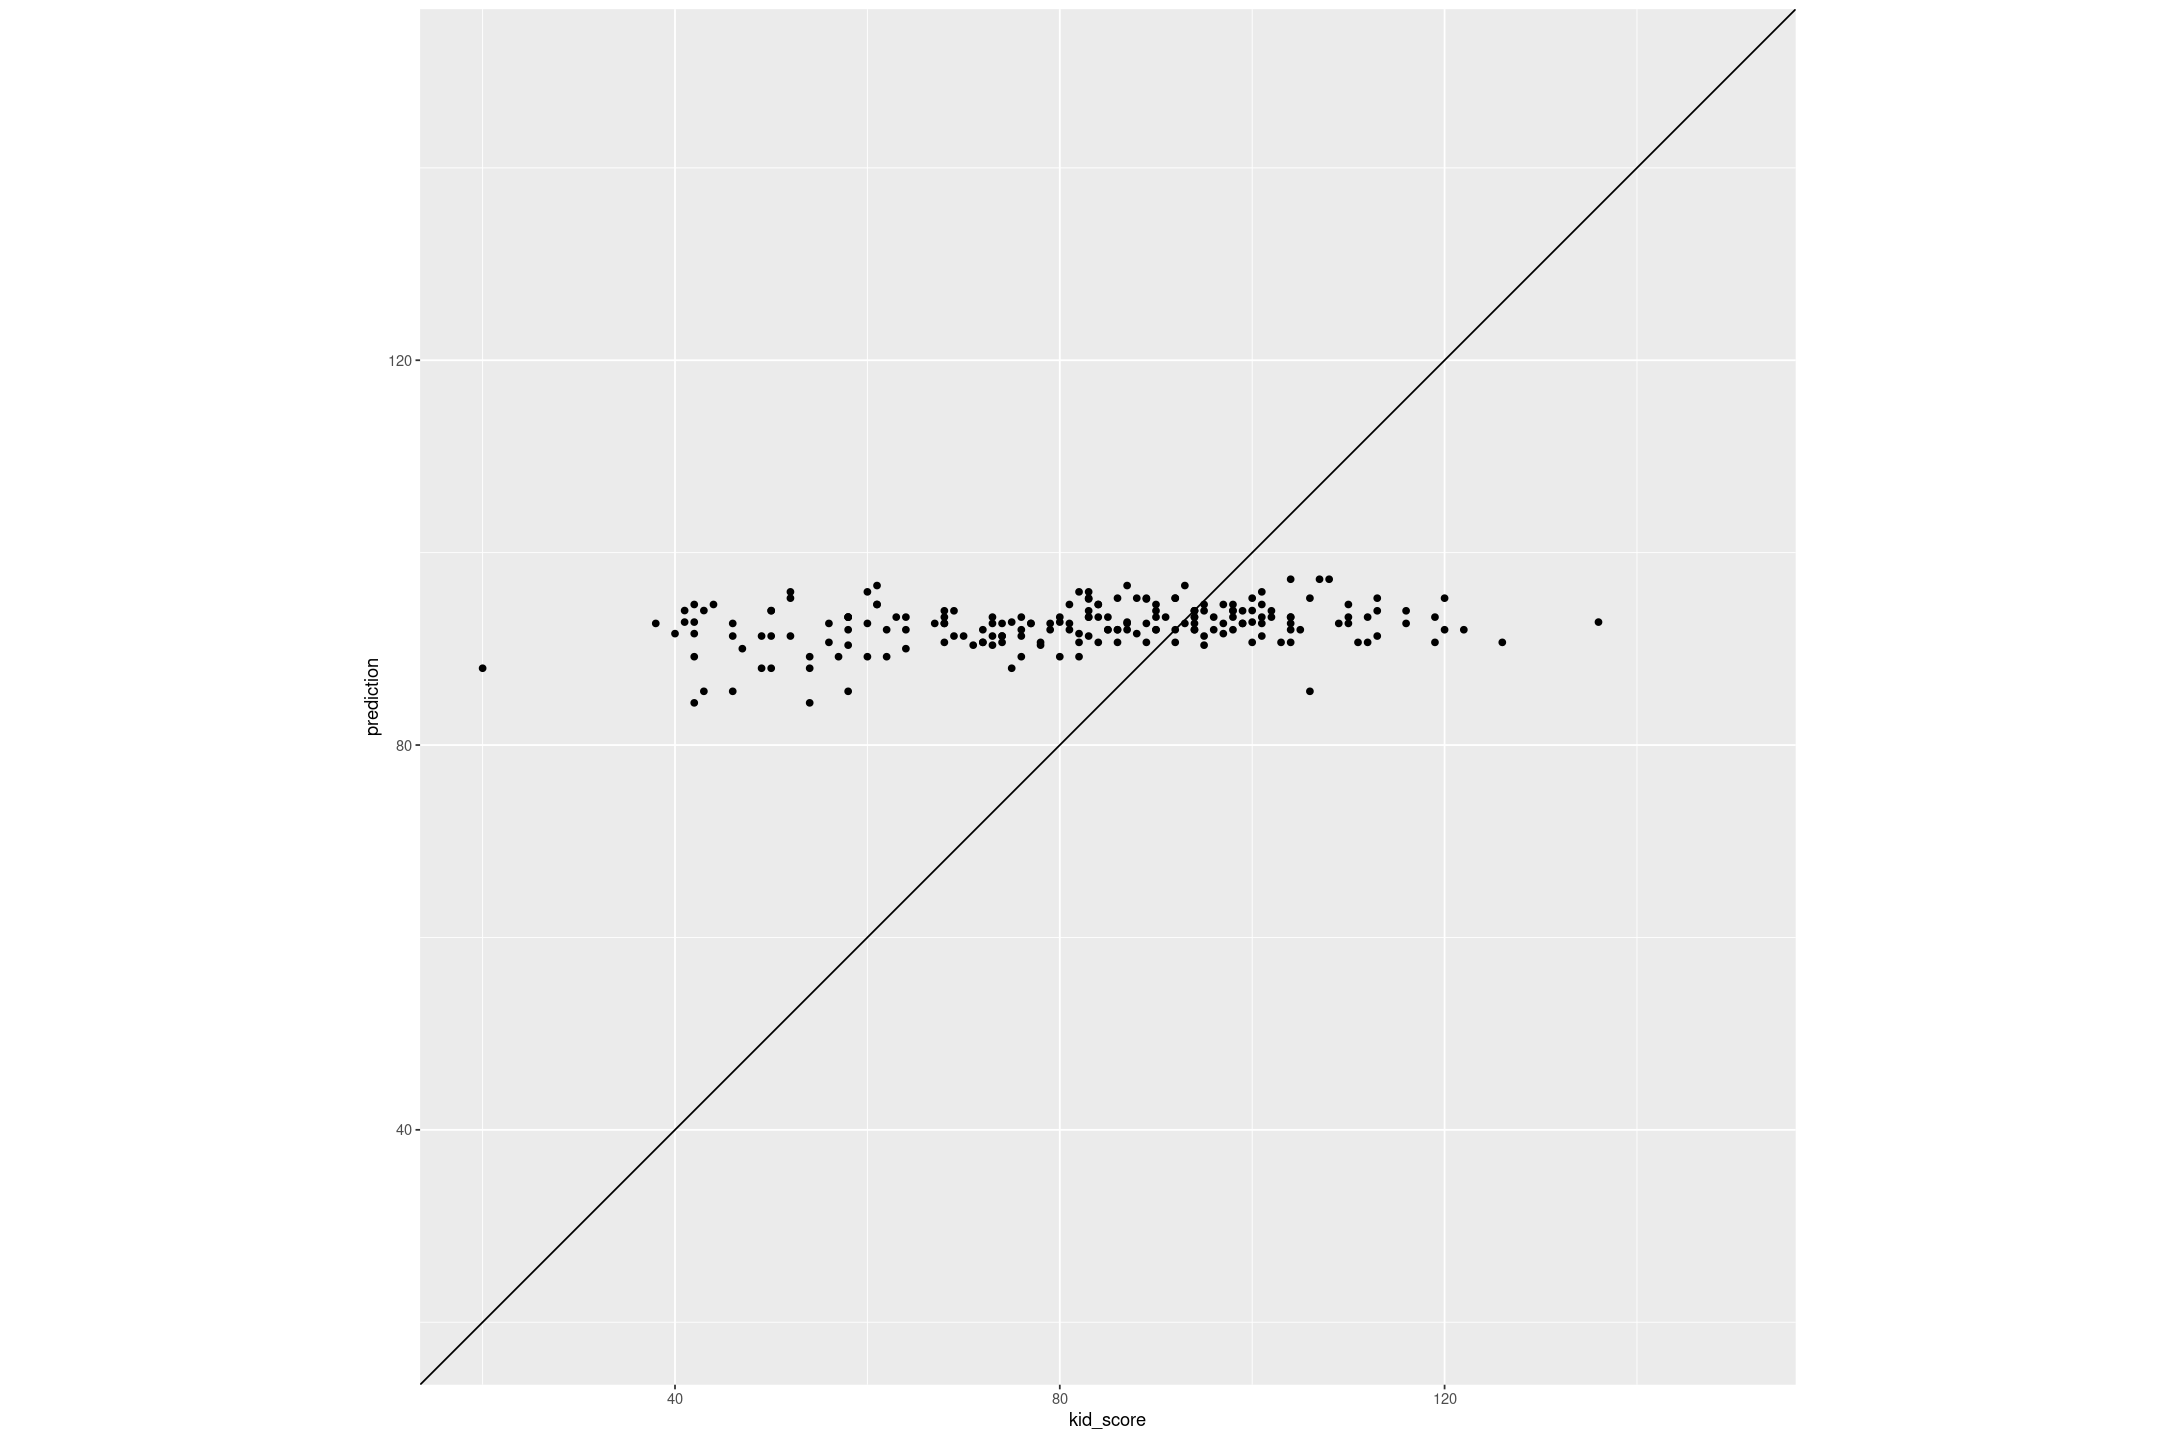

In [34]:
kidiq_test %>%
gf_point(prediction ~ kid_score) %>% 
gf_abline(intercept=~0, slope=~1) + 
theme(aspect.ratio=1) + 
scale_x_continuous(lim=c(20, 150)) + 
scale_y_continuous(lim=c(20, 150))

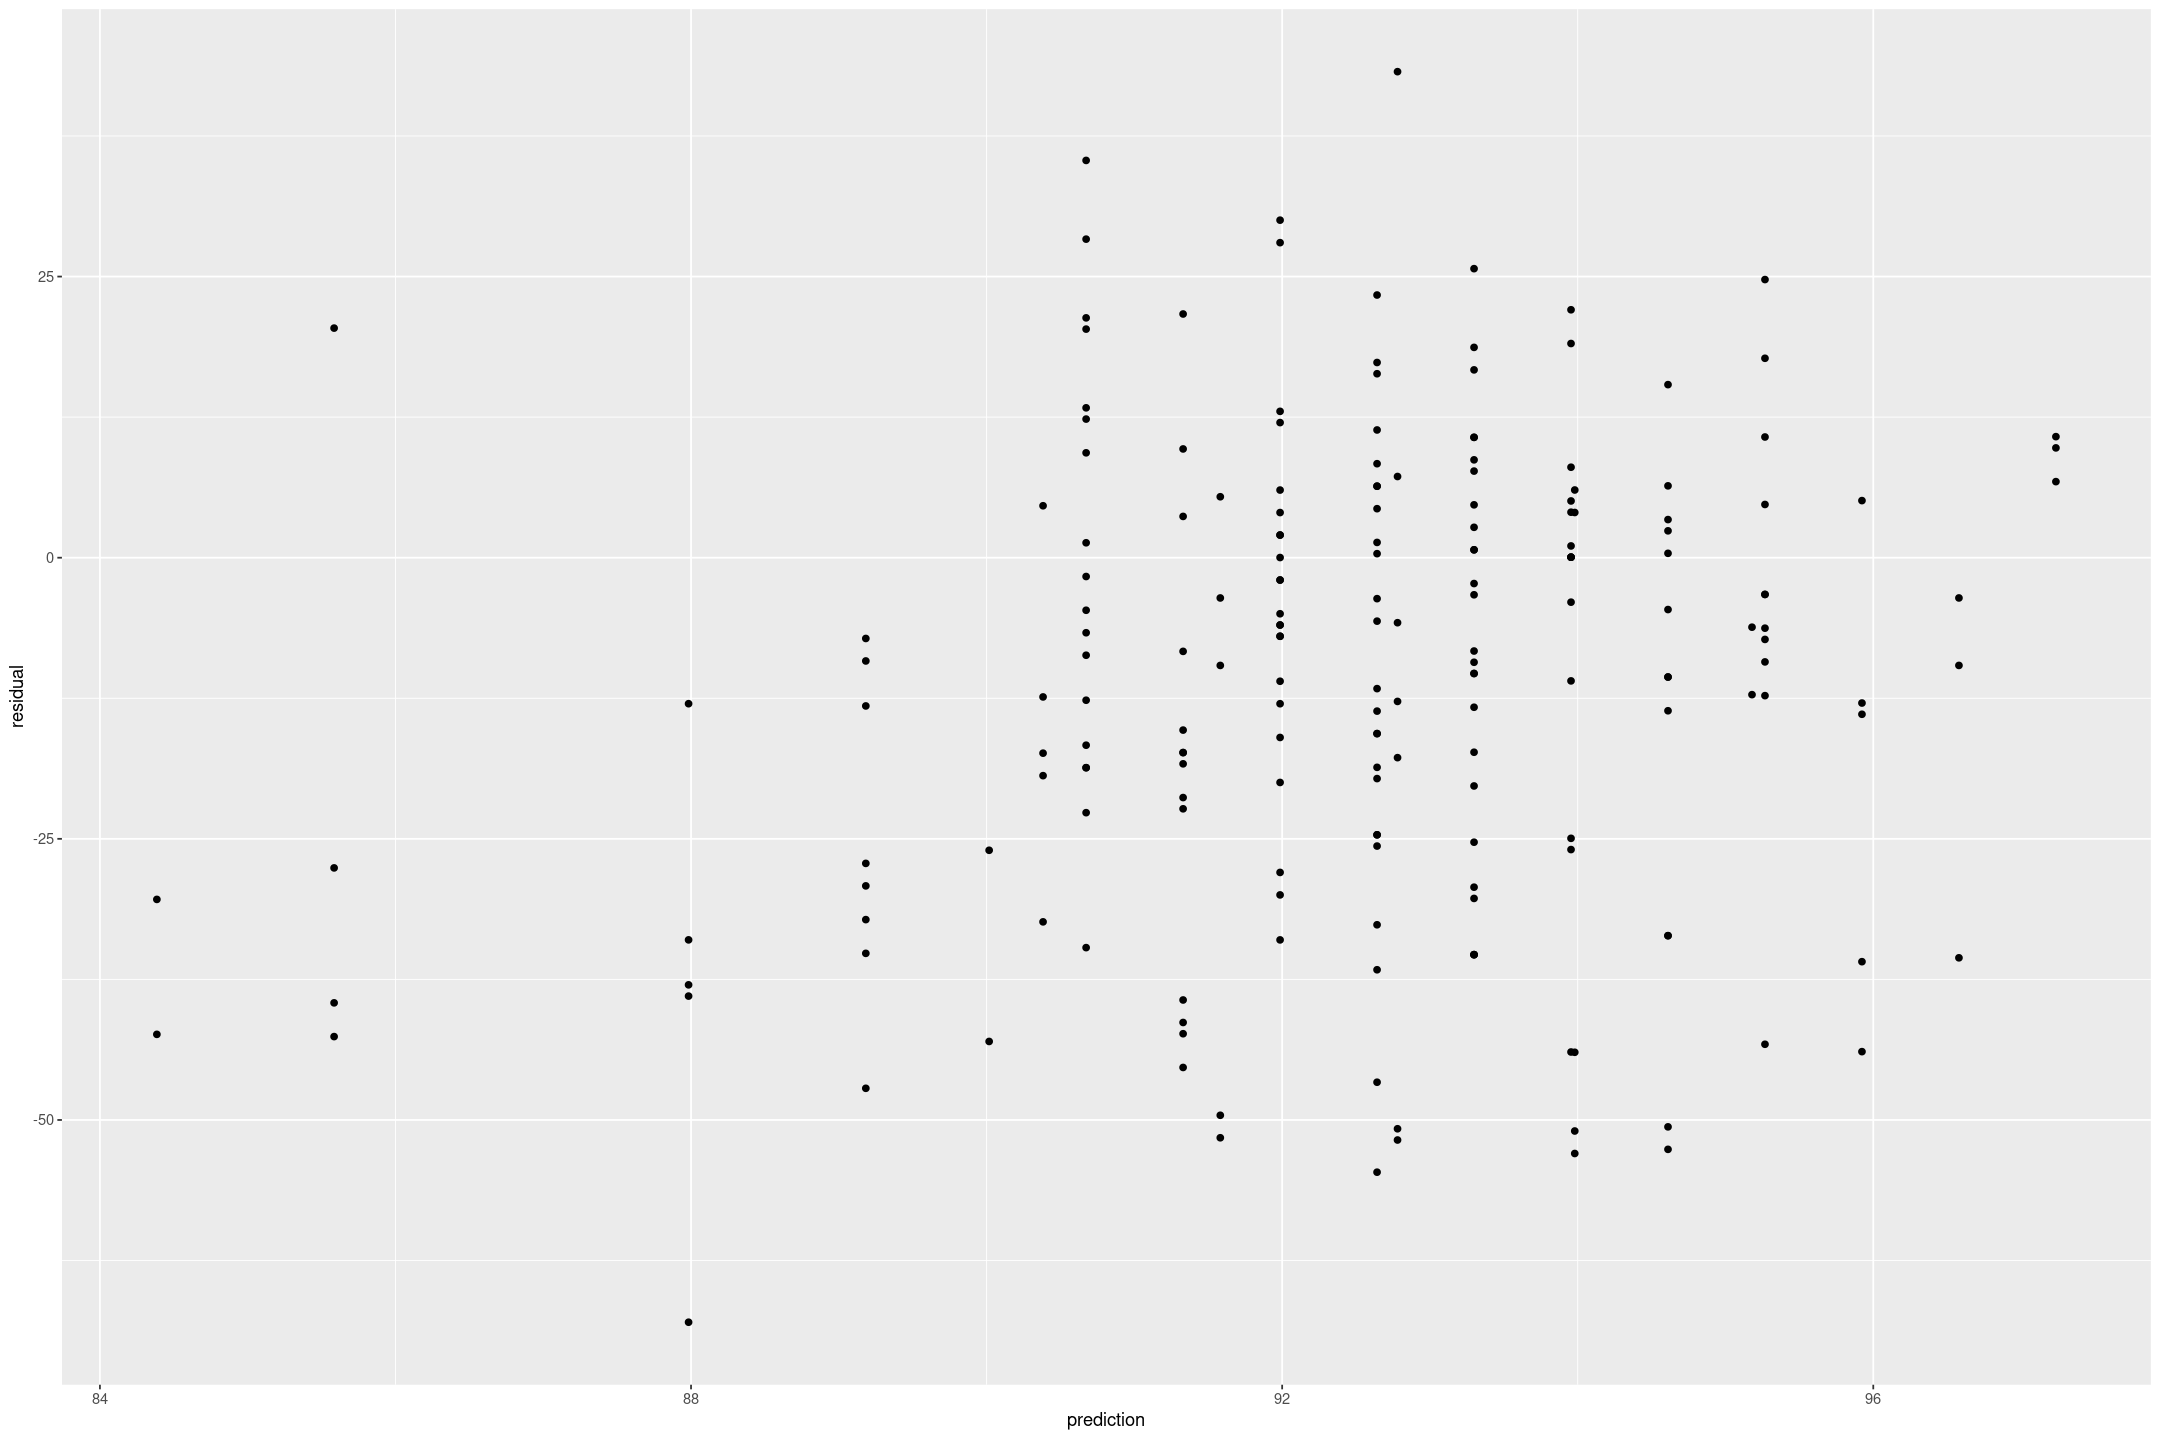

In [35]:
kidiq_test %>% gf_point(residual ~ prediction)

The RMS

In [36]:
sqrt(mean((kidiq_test$residual)^2))

[1] 23.71703

# Regression models with interactions

The folder [Beauty](https://github.com/avehtari/ROS-Examples/tree/master/Beauty/) contains data (Use file `bauty.csv`) from [Hamermesh and Parker (2005)](https://www.nber.org/papers/w9853) on student evaluations of instructors' beauty and teaching quality for several courses at the University of Texas.
The teaching evaluations were conducted at the end of the semester, and the beauty judgments were made later, by six students who had not attended the classes and were not awayre of the course evaluations.

eval: Evaluation from students
beauty: Beauty judgements
female: whether teacher is female
age: Age of instructor
minority: Whether instructor has a minority status
lower: Whether it's a lower-division course
course_id: The id for the course

In [37]:
filename <- "./data/Beauty/beauty.csv"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Beauty/data/beauty.csv')
beauty <- read.csv(filename)

beauty

eval,beauty,female,age,minority,nonenglish,lower,course_id
<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
4.3,0.2015666,1,36,1,0,0,3
4.5,-0.8260813,0,59,0,0,0,0
3.7,-0.6603327,0,51,0,0,0,4
4.3,-0.7663125,1,40,0,0,0,2
4.4,1.4214450,1,31,0,0,0,0
4.2,0.5002196,0,62,0,0,0,0
4.0,-0.2143501,1,33,0,0,0,4
3.4,-0.3465390,1,51,0,0,0,0
4.5,0.0613435,1,33,0,0,0,0


In [38]:
summary(beauty)

      eval           beauty             female            age       
 Min.   :2.100   Min.   :-1.53884   Min.   :0.0000   Min.   :29.00  
 1st Qu.:3.600   1st Qu.:-0.74462   1st Qu.:0.0000   1st Qu.:42.00  
 Median :4.000   Median :-0.15636   Median :0.0000   Median :48.00  
 Mean   :3.998   Mean   :-0.08835   Mean   :0.4212   Mean   :48.37  
 3rd Qu.:4.400   3rd Qu.: 0.45725   3rd Qu.:1.0000   3rd Qu.:57.00  
 Max.   :5.000   Max.   : 1.88167   Max.   :1.0000   Max.   :73.00  
    minority        nonenglish          lower          course_id     
 Min.   :0.0000   Min.   :0.00000   Min.   :0.0000   Min.   : 0.000  
 1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:0.0000   1st Qu.: 0.000  
 Median :0.0000   Median :0.00000   Median :0.0000   Median : 0.000  
 Mean   :0.1382   Mean   :0.06048   Mean   :0.3391   Mean   : 4.987  
 3rd Qu.:0.0000   3rd Qu.:0.00000   3rd Qu.:1.0000   3rd Qu.: 6.000  
 Max.   :1.0000   Max.   :1.00000   Max.   :1.0000   Max.   :30.000  

## Relation of beauty and evlautions

Run a regression using beauty (the variable `beauty`) to predict course evaluations (`eval`). Graph the data and fitted model, and explain the meaning of each of the coefficients along with the residual standard devaition.
Plot the residuals versus fitted values.

In [39]:
beauty %>% summarise_all(mean)

eval,beauty,female,age,minority,nonenglish,lower,course_id
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.998272,-0.08834903,0.4211663,48.36501,0.1382289,0.06047516,0.3390929,4.987041


The intercept says that when beauty is 0 (close to its mean value) the average evaluation is 4.
The SD is very low, saying this estimate is pretty stable.

Beauty ranges from around -1.5 to 2.
The beauty coefficient says that for two teachers, one who is 1 point more beautiful than the other, on average will have an evaluation 0.13 points higher.
The MAD_SD is 0.03, so this effect is substantial.

Sigma says the variation around the predicted values is about 0.55.
This is larger than the difference in beauty, so it's going to be quite noisy.
The MAD_SD is 0.02, so this estimate is pretty stable.

In [40]:
eval_beauty_model <- stan_glm(eval ~ beauty, data=beauty, refresh=0)

print(eval_beauty_model, digits=2)

stan_glm
 family:       gaussian [identity]
 formula:      eval ~ beauty
 observations: 463
 predictors:   2
------
            Median MAD_SD
(Intercept) 4.01   0.03  
beauty      0.13   0.03  

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.55   0.02  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


Drawing the regression line and some variations 1 standard devation away.

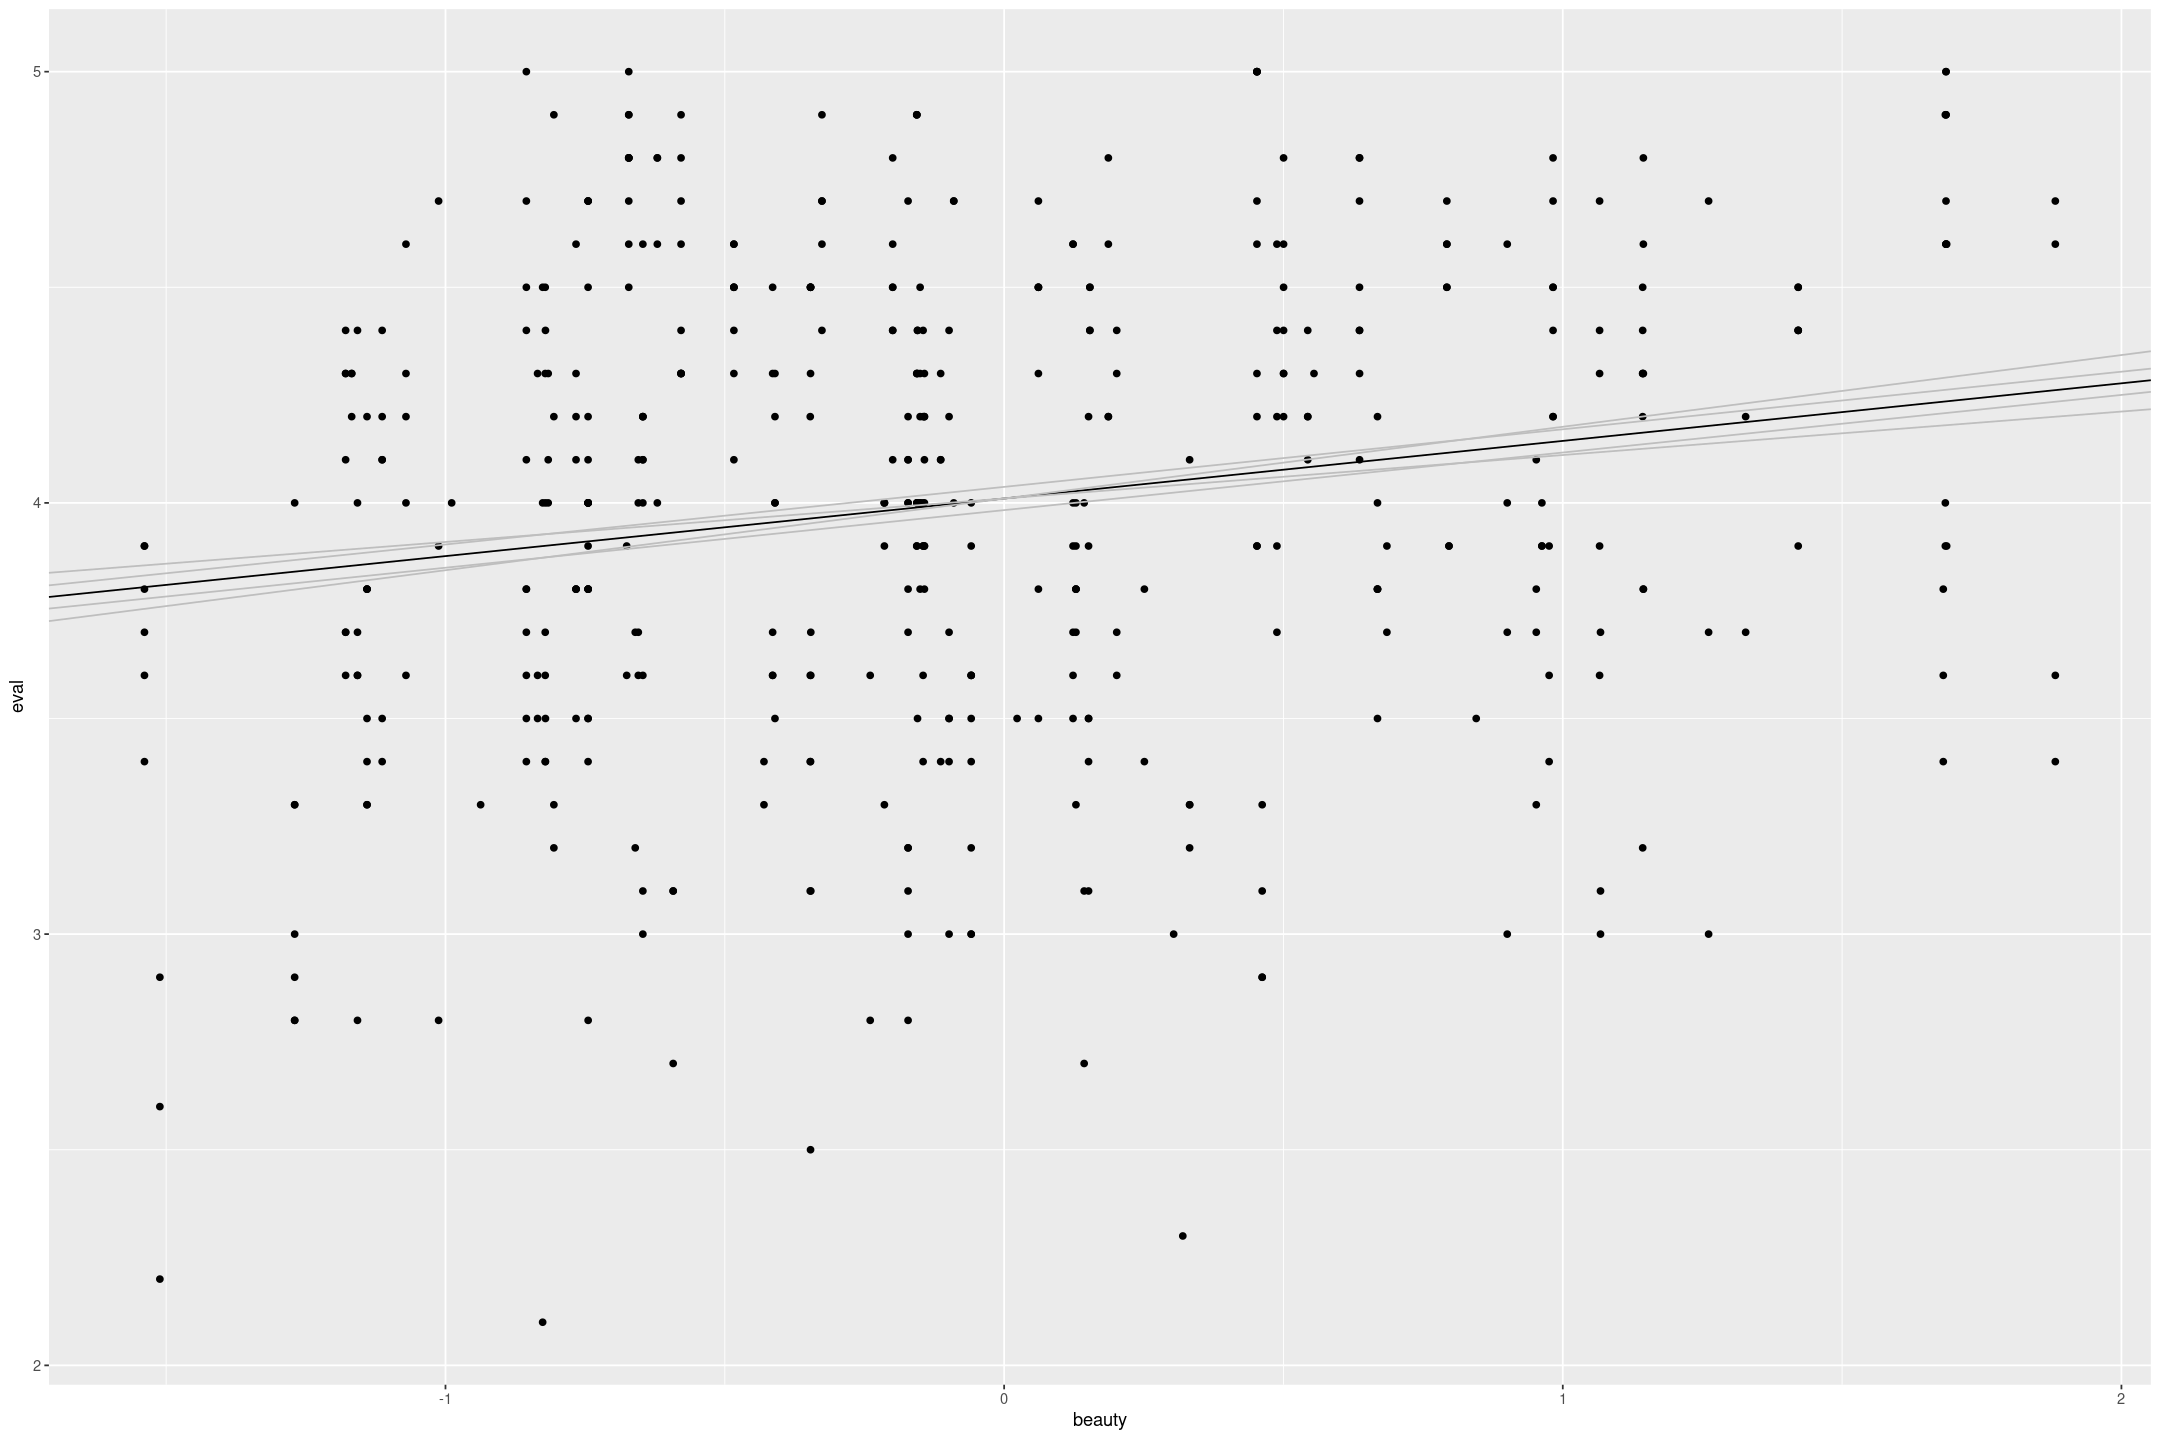

In [41]:
beauty %>%
gf_point(eval ~ beauty) +
geom_abline(intercept=coef(eval_beauty_model)["(Intercept)"], slope=coef(eval_beauty_model)["beauty"]) +
geom_abline(intercept=coef(eval_beauty_model)["(Intercept)"],
            slope=coef(eval_beauty_model)["beauty"] + se(eval_beauty_model)["beauty"], col="grey") +
geom_abline(intercept=coef(eval_beauty_model)["(Intercept)"],
            slope=coef(eval_beauty_model)["beauty"] - se(eval_beauty_model)["beauty"], col="grey") +
geom_abline(intercept=coef(eval_beauty_model)["(Intercept)"] + se(eval_beauty_model)["(Intercept)"],
            slope=coef(eval_beauty_model)["beauty"], col="grey") +
geom_abline(intercept=coef(eval_beauty_model)["(Intercept)"] - se(eval_beauty_model)["(Intercept)"],
            slope=coef(eval_beauty_model)["beauty"], col="grey")


Another way of showing the uncertainty is to draw some of the simulatated slopes and intercepts.

It's easy to see that all the slopes are positive, there is a real, but small, correlation between beauty and evaluations.

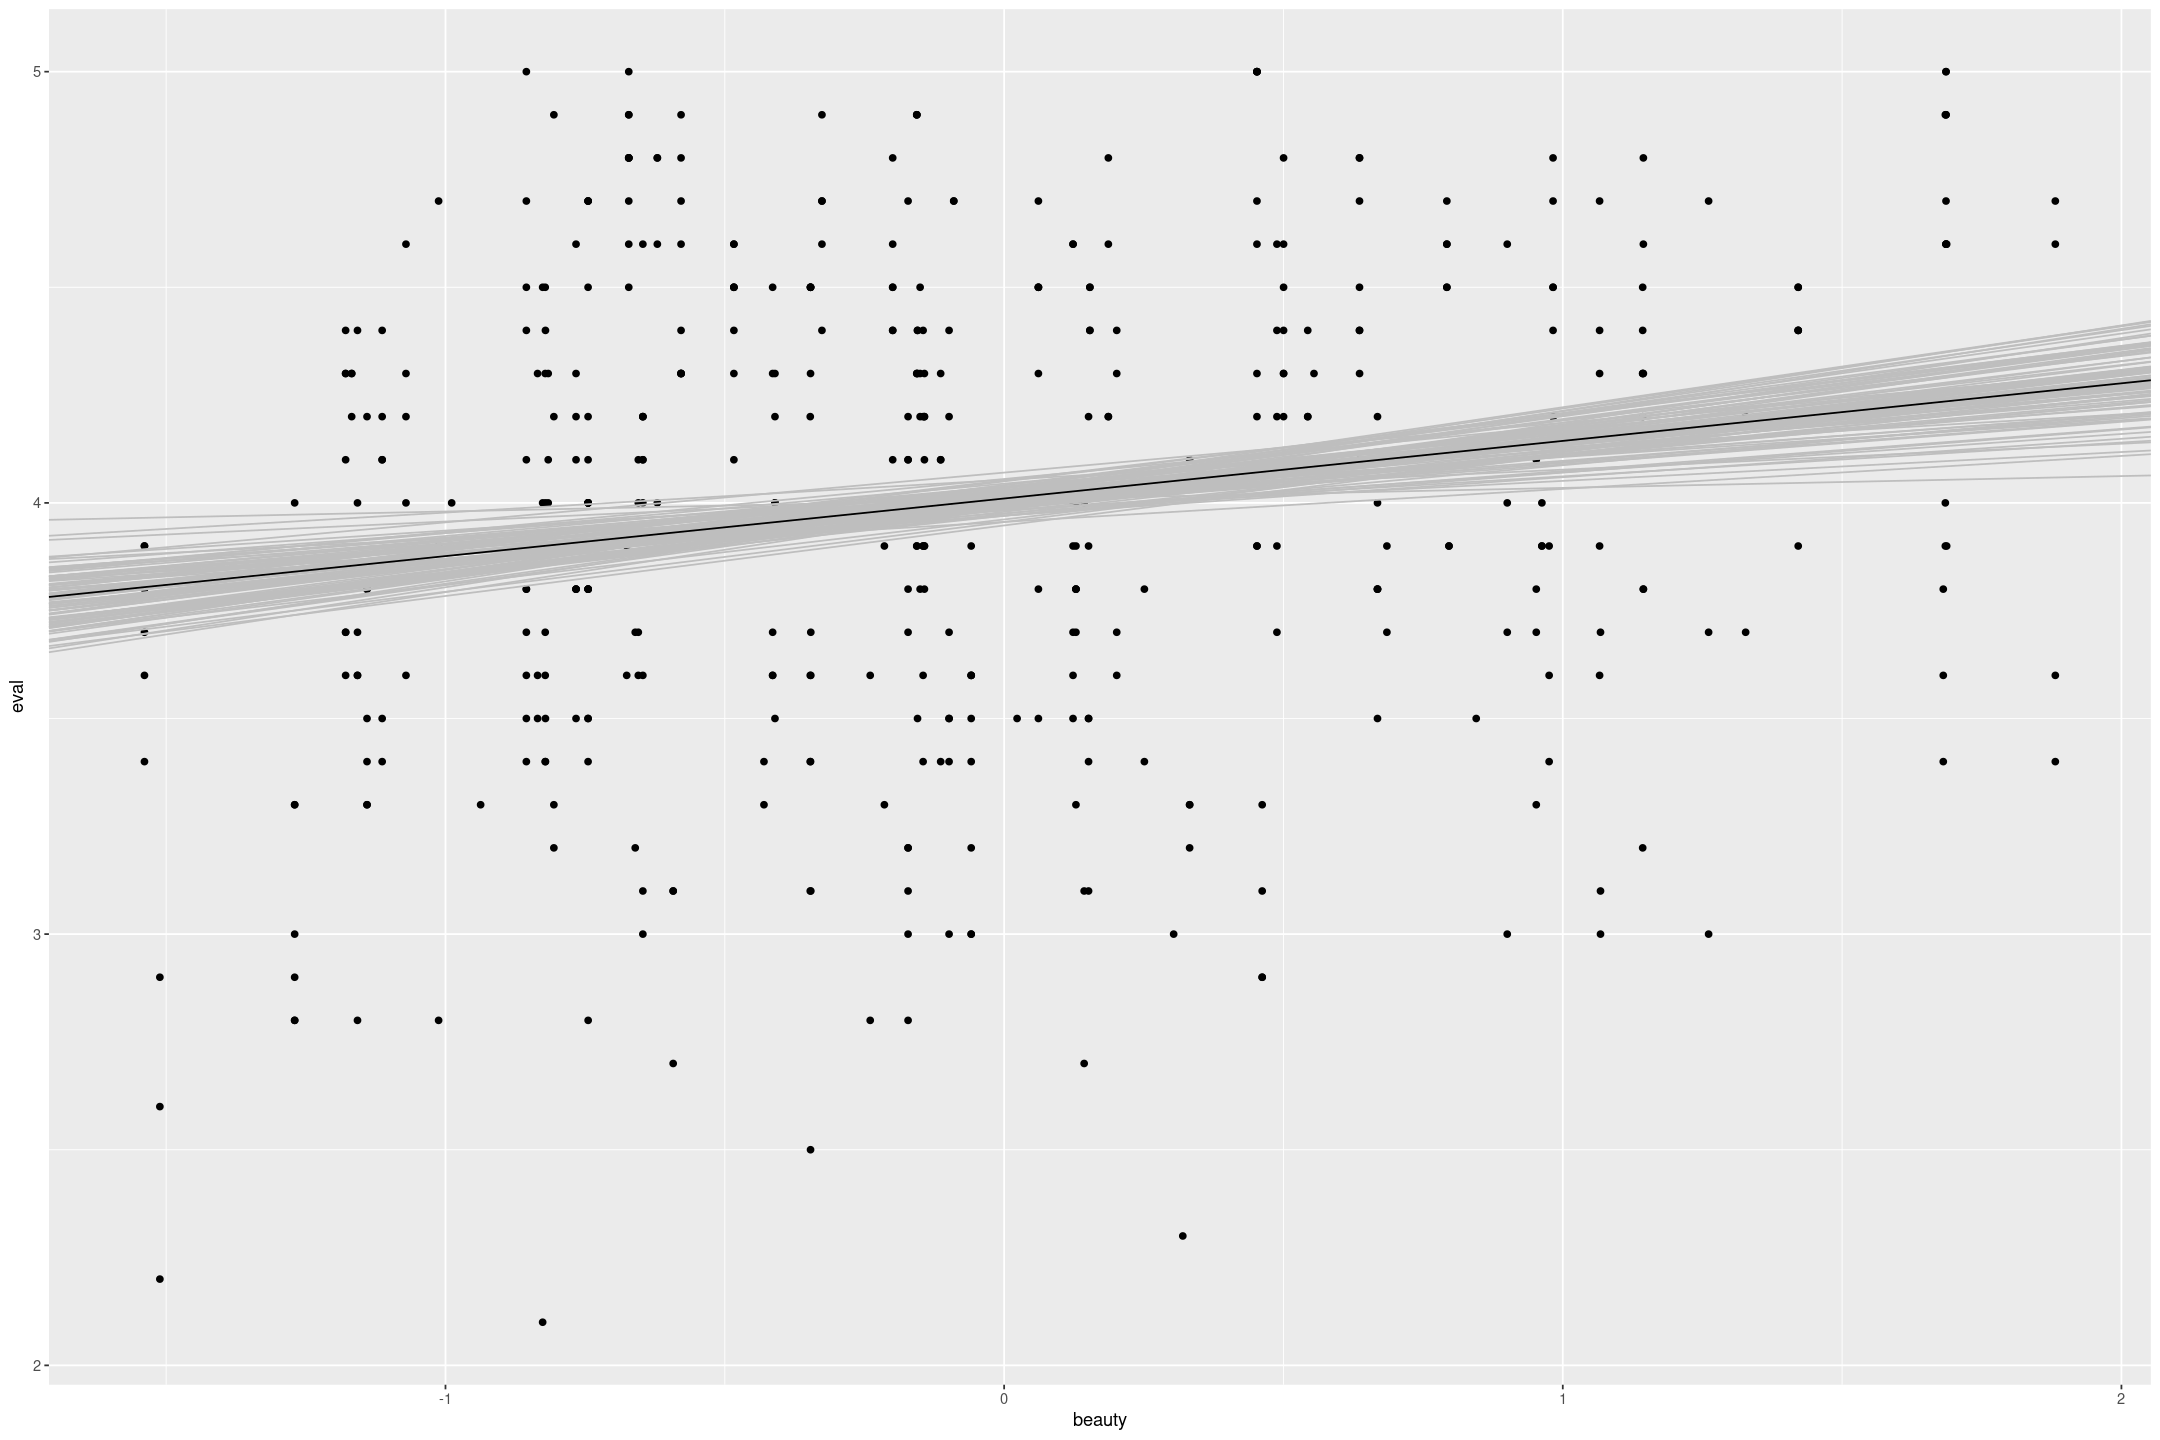

In [42]:
sims <- as_tibble(eval_beauty_model)


beauty %>%
gf_point(eval ~ beauty) +
geom_abline(mapping=aes(intercept=`(Intercept)`, slope=beauty), data=sims %>% slice_sample(n=100), colour="grey") +
geom_abline(mapping=aes(intercept=`(Intercept)`, slope=beauty), data=sims %>% summarise_all(median))

The residuals look a little more scattered below 0 than above, but look uniform across the predictions - not bad.

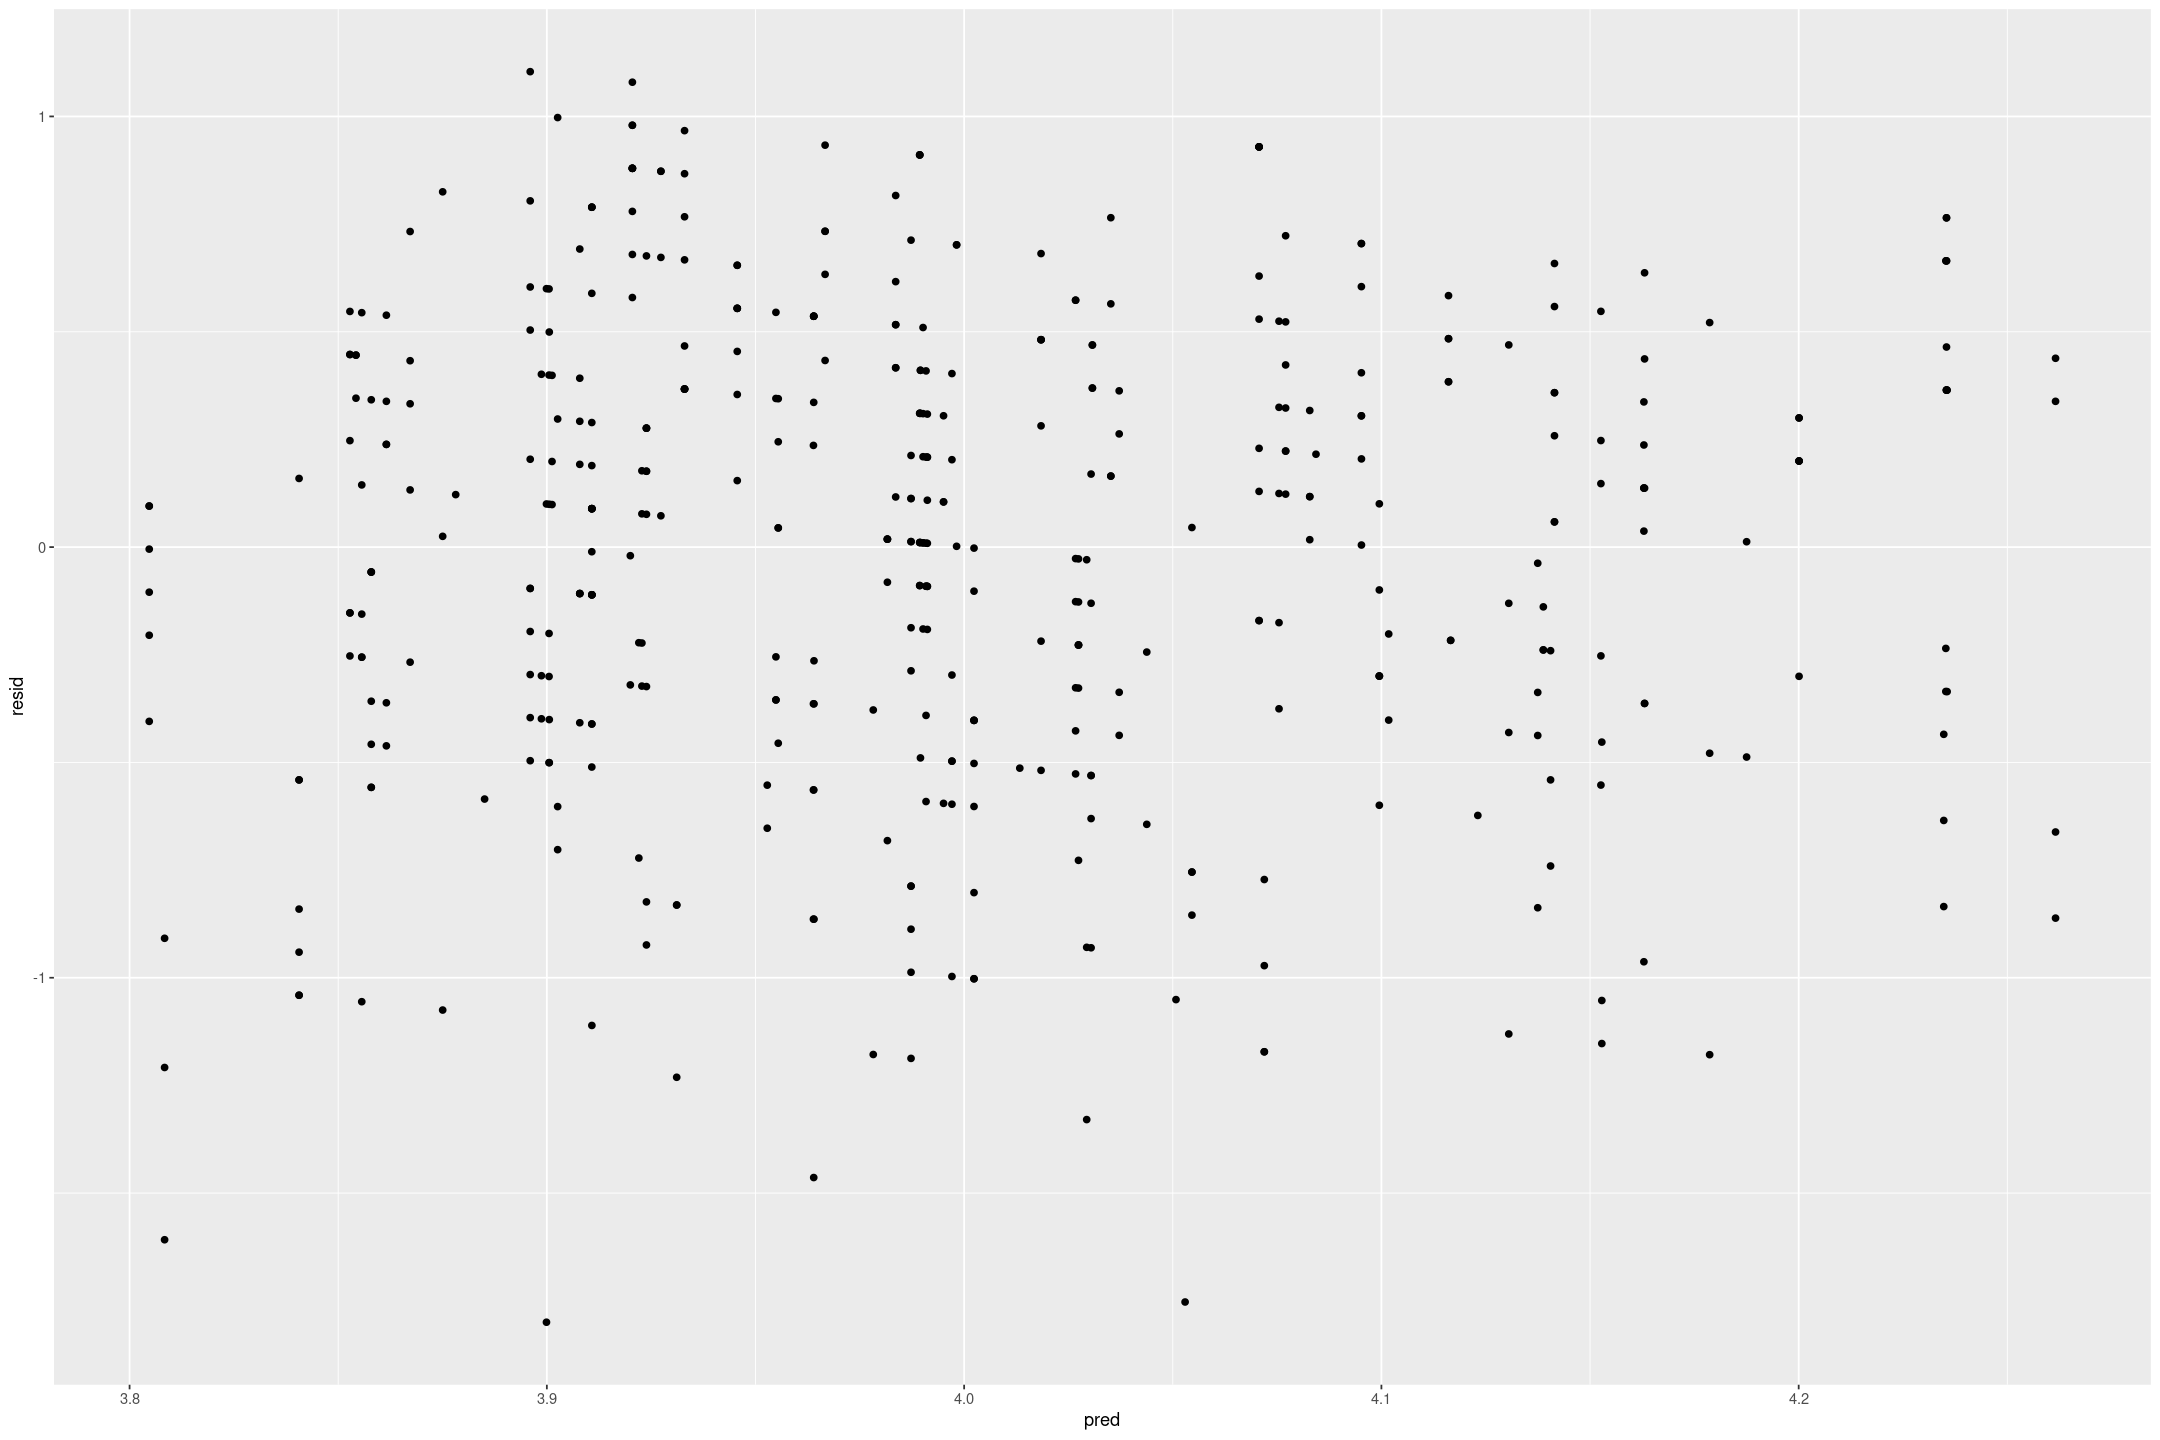

In [43]:
beauty %>%
modelr::add_predictions(eval_beauty_model) %>% 
modelr::add_residuals(eval_beauty_model) %>%
gf_point(resid ~ pred)

In [44]:
beauty %>% modelr::add_residuals(eval_beauty_model) %>% summarise(sqrt(mean(resid^2)))

sqrt(mean(resid^2))
<dbl>
0.5442726


## Adjusting for other predictors

Fit some other models, including beauty and also other predictors.
Consider at least one model with interactions.
For each model, explain the meaning of each of its estimated coefficients.

See also [Felton, Mitchell and Stinson (2003)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=426763.) for more on this topic.

### Synthesis

Female minorities get by far the worst evaluations, around 0.39 points lower on average than their male non-minority counterparts, and 0.6 points lower than their male minority counterparts (although there's a bit of variance in these estimates).

Not coming from an english speaking country reduces the evaluation by 0.36 points (with a little varation).

There's good evidence for a relation between beauty and evaluations, which is about 0.21 points per beauty for males, but only 0.1 points per beauty for females.

### Detail


The intercept says that for beauty, male, upper-division teachers with 0 beauty who were educated in an English speaking country the average evaluation was 4.09.
Again this estimate is stable, with sd 0.04.

In this case the beauty coefficient for males is slightly higher at 0.21, and this is pretty stable with SD at 0.04.

Female instructors get a systematically lower rating by 0.13 points.

Innterestingly male minorities have a higher evaluation (0.24 points) on average, but the estimate has a wide range (0.13 sd).

People educated a nonenglish speaking country get 0.36 less poitns on average.

Teachers in lower-division get 0.11 more points on average.

The interaction between beauty and female is large: 1 point in beauty corresponds to about 0.1 points of evaluation. The estimate is a bit more unstable.

The interaction between beuty and minority is negligible.

Female minorities get a much lower score than male minorities: -0.5 points.

The sigma is similar as before; we haven't really explained much more of the model.

In [45]:
beauty_model <- stan_glm(eval ~ beauty + female + minority + nonenglish + lower + female:beauty + minority:beauty + minority:female, data=beauty, refresh=0)

print(beauty_model, digits=2)

stan_glm
 family:       gaussian [identity]
 formula:      eval ~ beauty + female + minority + nonenglish + lower + female:beauty + 
	   minority:beauty + minority:female
 observations: 463
 predictors:   9
------
                Median MAD_SD
(Intercept)      4.06   0.04 
beauty           0.21   0.04 
female          -0.13   0.05 
minority         0.24   0.13 
nonenglish      -0.35   0.12 
lower            0.11   0.05 
beauty:female   -0.11   0.06 
beauty:minority  0.03   0.12 
female:minority -0.51   0.18 

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.53   0.02  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


Here's a plot showing the effect of the gender interaction. The blue line is for females (who are not a minority, teaching upper, etc,.).

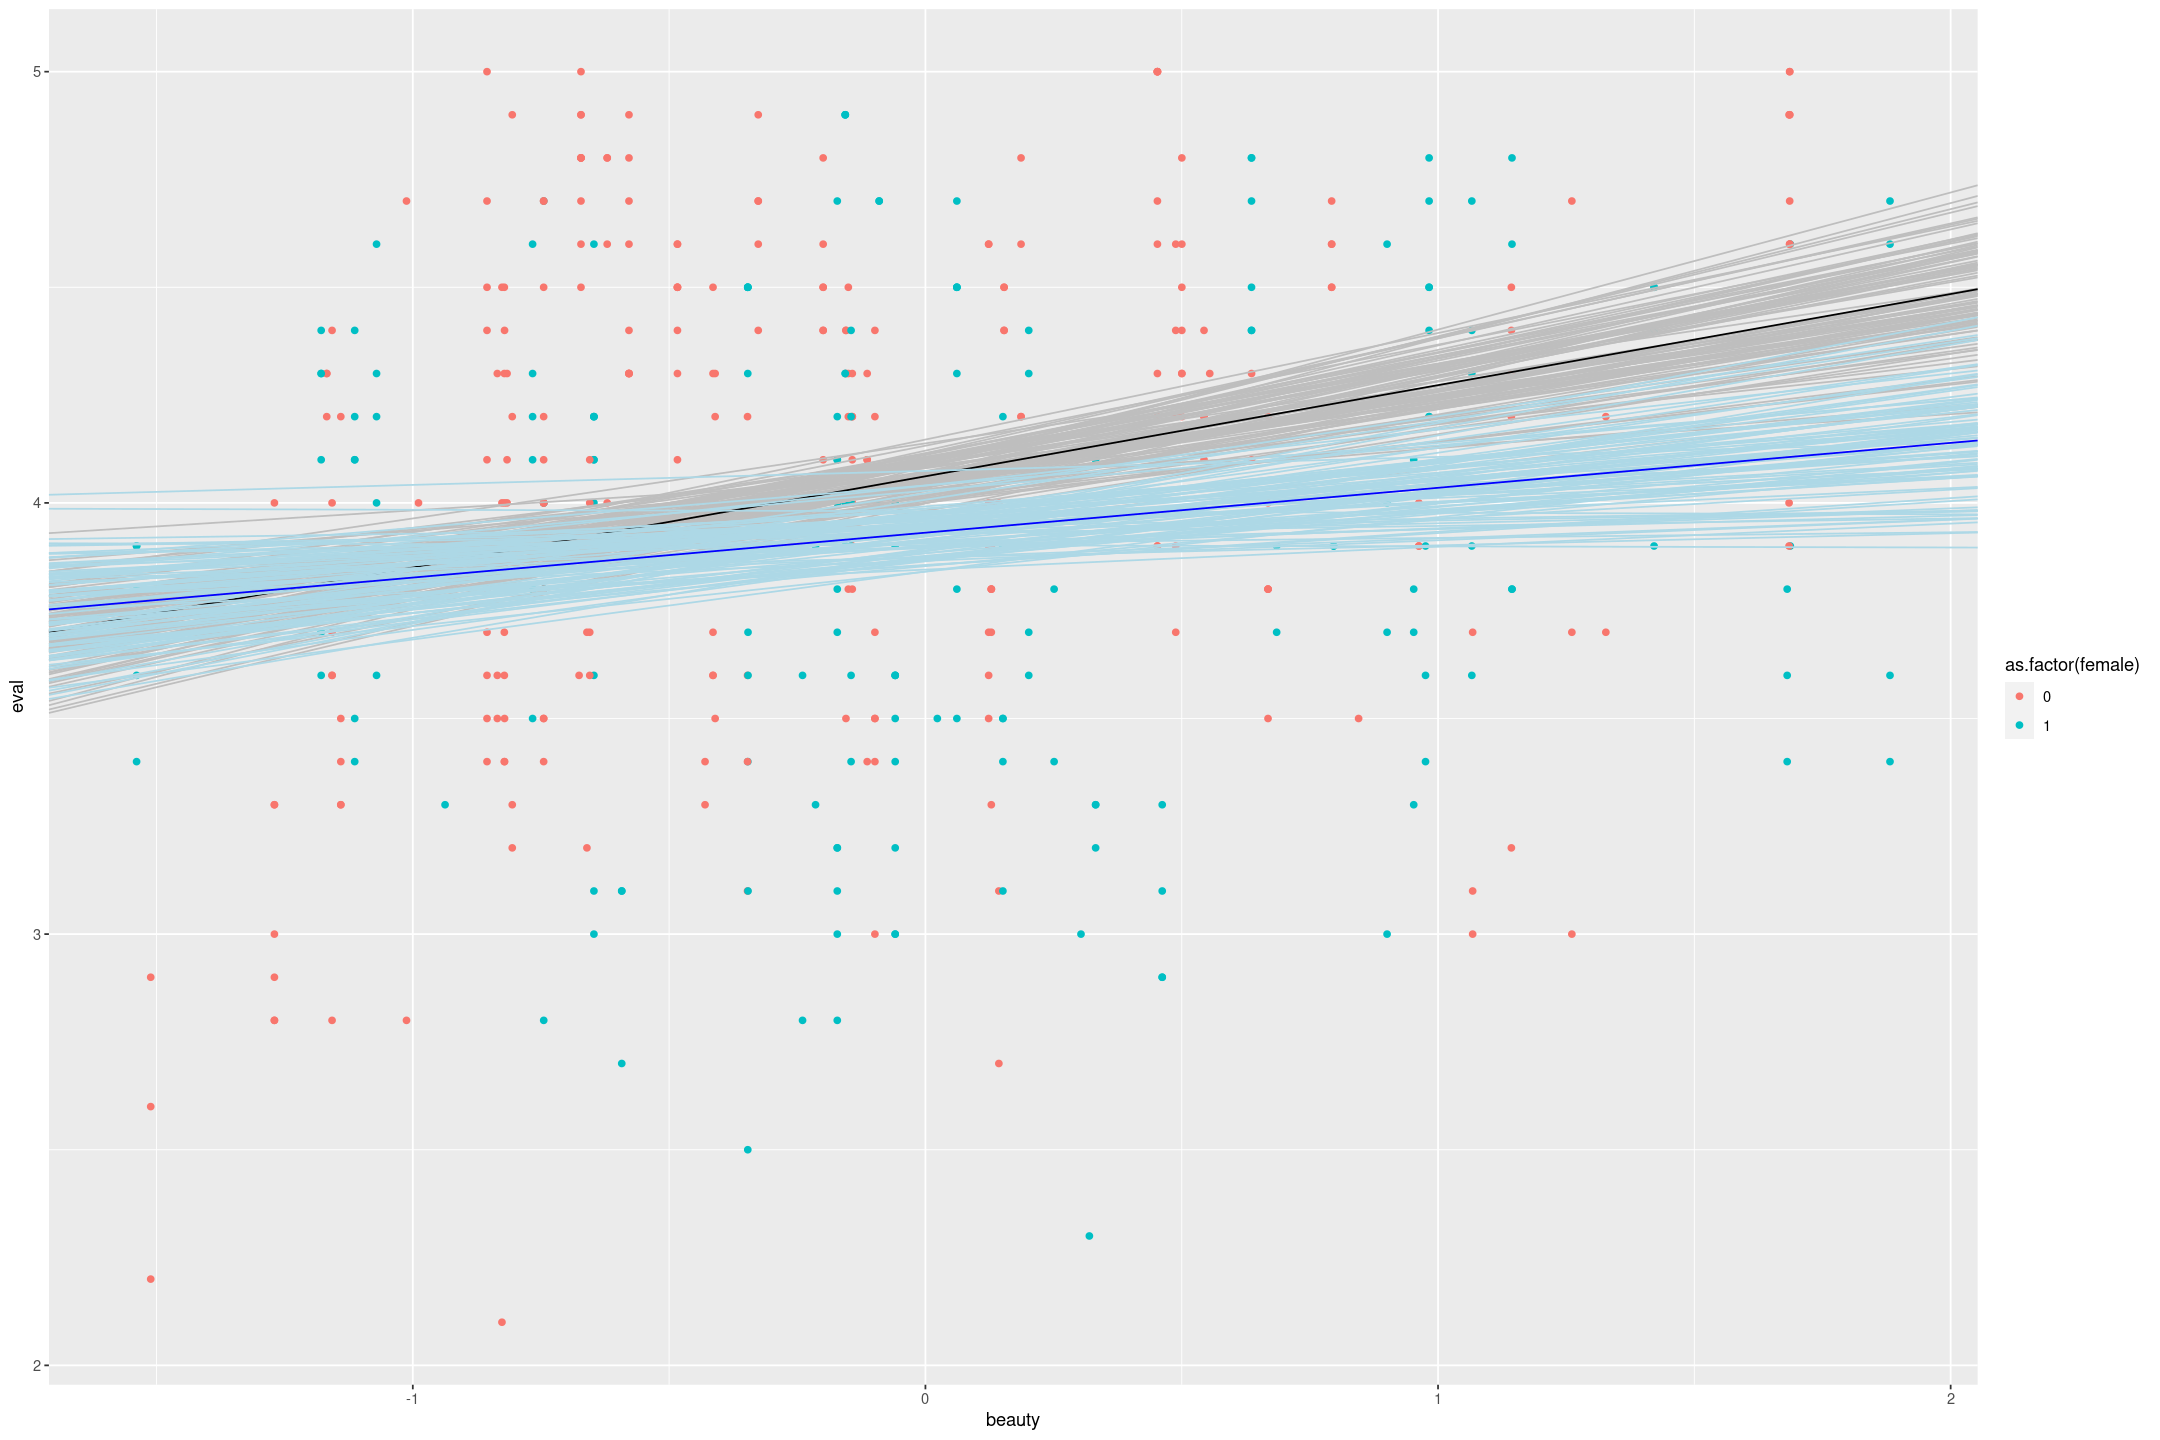

In [46]:
sims <- as_tibble(beauty_model)


beauty %>%
gf_point(eval ~ beauty, col=~as.factor(female)) +
geom_abline(mapping=aes(intercept=`(Intercept)`, slope=beauty), data=sims %>% slice_sample(n=100), colour="grey") +
geom_abline(mapping=aes(intercept=`(Intercept)`, slope=beauty), data=sims %>% summarise_all(median)) +
geom_abline(mapping=aes(intercept=`(Intercept)` + female, slope=beauty + `beauty:female`), data=sims %>% slice_sample(n=100), col="lightblue") +
geom_abline(mapping=aes(intercept=`(Intercept)` + female, slope=beauty + `beauty:female`), data=sims %>% summarise_all(median), col="blue")

The residuals look similar, but the predicted values are more concentrated

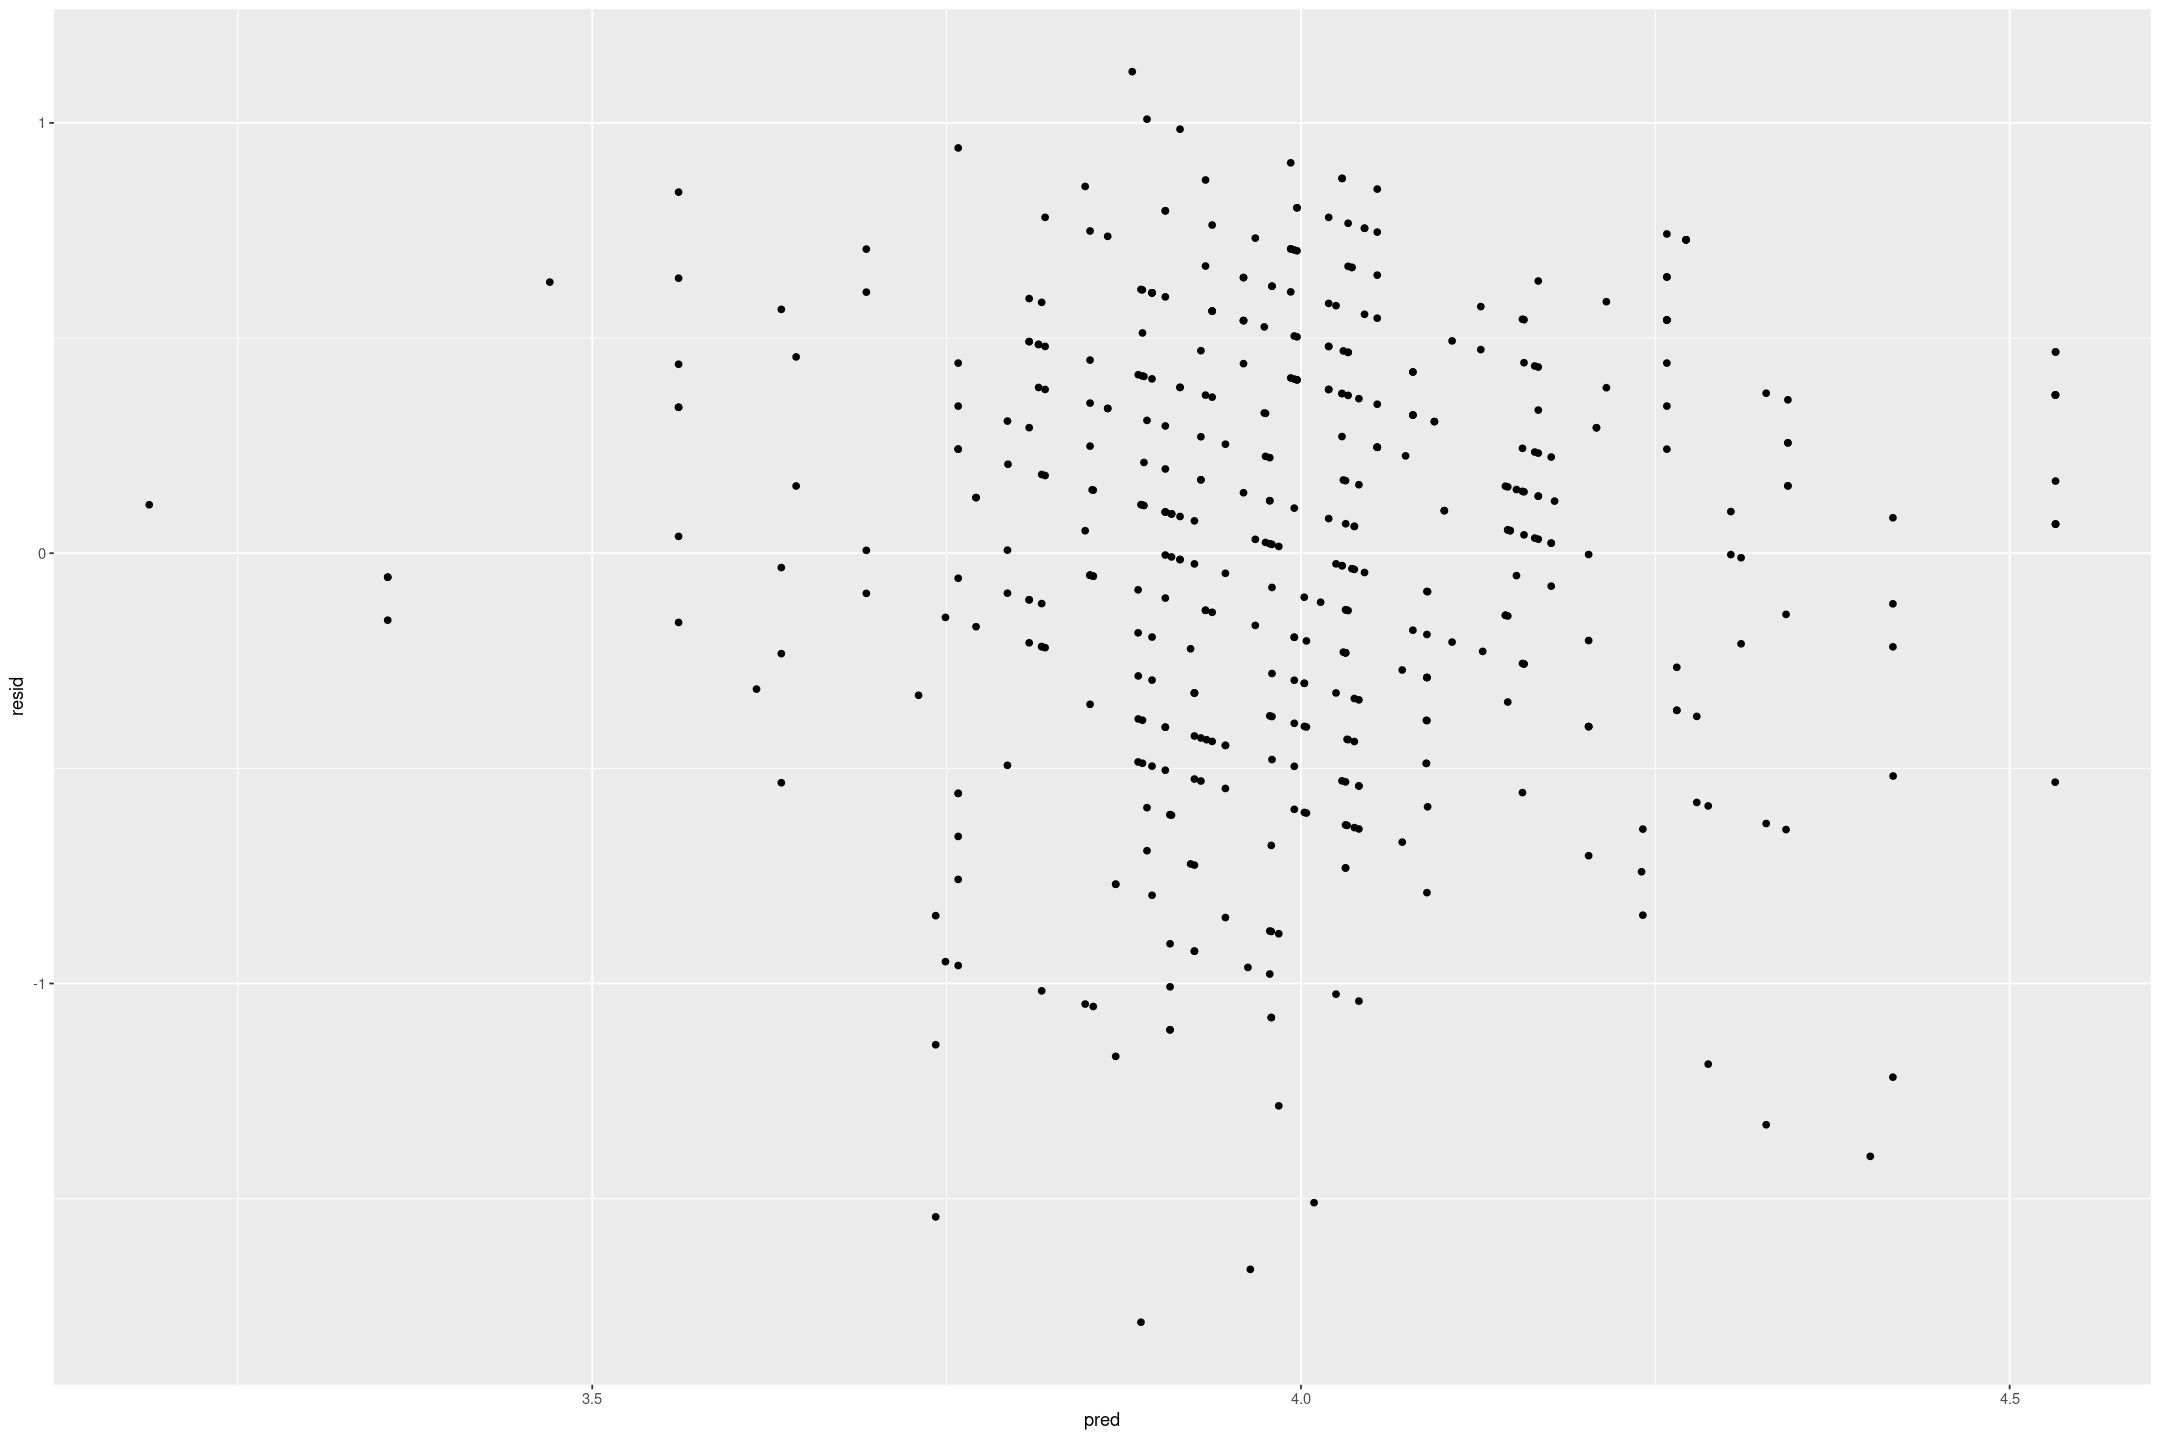

In [47]:
beauty %>%
modelr::add_predictions(beauty_model) %>% 
modelr::add_residuals(beauty_model) %>%
gf_point(resid ~ pred)

In [48]:
beauty %>% modelr::add_residuals(beauty_model) %>% summarise(sqrt(mean(resid^2)))

sqrt(mean(resid^2))
<dbl>
0.5197836


# Predictive simulation for linear regression

Take one of the models from the previous exercise.

## Predicted Ratings

Instructor A is a 50-year-old woman who is a native English speaker and has a beauty score of -1.
Instructor B is a 60-year-old man who is a native English speaker and has a beauty score of -0.5.
Simulate 1000 random draws of the course evaluation rating of these two instructors.
In your simulation, use `posterior_predict` to account for the uncertainty in the gregression parameters as well as predictive uncertainty.

We don't know whether the instructors are minorities or are teaching at the lower-division, which were both in my previous model.
There's a few ways we could try to handle that:

* Train a new model without those features
* Impute the missing values deterministically (most common)
* Impute the missing values probabilistically (making different draws)
* Score in both cases and take a weighted average

Let's go with training a new model containing all those terms and some of the interactions. 

In [49]:
summary(beauty)

      eval           beauty             female            age       
 Min.   :2.100   Min.   :-1.53884   Min.   :0.0000   Min.   :29.00  
 1st Qu.:3.600   1st Qu.:-0.74462   1st Qu.:0.0000   1st Qu.:42.00  
 Median :4.000   Median :-0.15636   Median :0.0000   Median :48.00  
 Mean   :3.998   Mean   :-0.08835   Mean   :0.4212   Mean   :48.37  
 3rd Qu.:4.400   3rd Qu.: 0.45725   3rd Qu.:1.0000   3rd Qu.:57.00  
 Max.   :5.000   Max.   : 1.88167   Max.   :1.0000   Max.   :73.00  
    minority        nonenglish          lower          course_id     
 Min.   :0.0000   Min.   :0.00000   Min.   :0.0000   Min.   : 0.000  
 1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:0.0000   1st Qu.: 0.000  
 Median :0.0000   Median :0.00000   Median :0.0000   Median : 0.000  
 Mean   :0.1382   Mean   :0.06048   Mean   :0.3391   Mean   : 4.987  
 3rd Qu.:0.0000   3rd Qu.:0.00000   3rd Qu.:1.0000   3rd Qu.: 6.000  
 Max.   :1.0000   Max.   :1.00000   Max.   :1.0000   Max.   :30.000  

Interpreting the coefficients here:

The intercept case applies to a 0 year old male with 0 beauty who is a native english speaker.
A 0 year old doesn't make much sense, so we replace it with a 48 year old (median value) to get a score point estimate of 4.1.

Note that age over the whole range only changes the coefficient by 0.044, and the uncertainty is larger than the coefficient. The age doesn't really impact the rating.

But there is a significant interaction between beauty and age.
An extra 1 point in beauty for a 48 year old male corresponds to a 0.17 higher rating.
In a 29 year old male it's a 0.06 lower rating, and in a 73 year old make its 0.472.
In short the importance of beauty on evaluation seems to increase significantly with age.

As in our previous model females get a much lower score, but the interaction between beauty and age is gone (was that swept into age??)

The standard deviation is similar to our previous models

In [50]:
beauty_min_model <- stan_glm(eval ~ beauty + female + age + nonenglish + female:beauty + age:beauty, data=beauty, refresh=0)

print(beauty_min_model, digits=3)

stan_glm
 family:       gaussian [identity]
 formula:      eval ~ beauty + female + age + nonenglish + female:beauty + age:beauty
 observations: 463
 predictors:   7
------
              Median MAD_SD
(Intercept)    4.221  0.139
beauty        -0.406  0.179
female        -0.224  0.052
age           -0.001  0.003
nonenglish    -0.361  0.102
beauty:female  0.000  0.072
beauty:age     0.012  0.003

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.525  0.017 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [51]:
preds <- posterior_predict(beauty_min_model, newdata=tribble(~age, ~female, ~nonenglish, ~beauty,
                                                             50,   1,        0,          -1,
                                                             60,   0,        0,          -0.5))

In [52]:
preds_a <- preds[1:1000,1]
preds_b <- preds[1:1000,2]

In [53]:
c(median(preds_a), sd(preds_a))

[1] 3.7455159 0.5475576

In [54]:
c(median(preds_b), sd(preds_b))

[1] 3.9887695 0.5167434

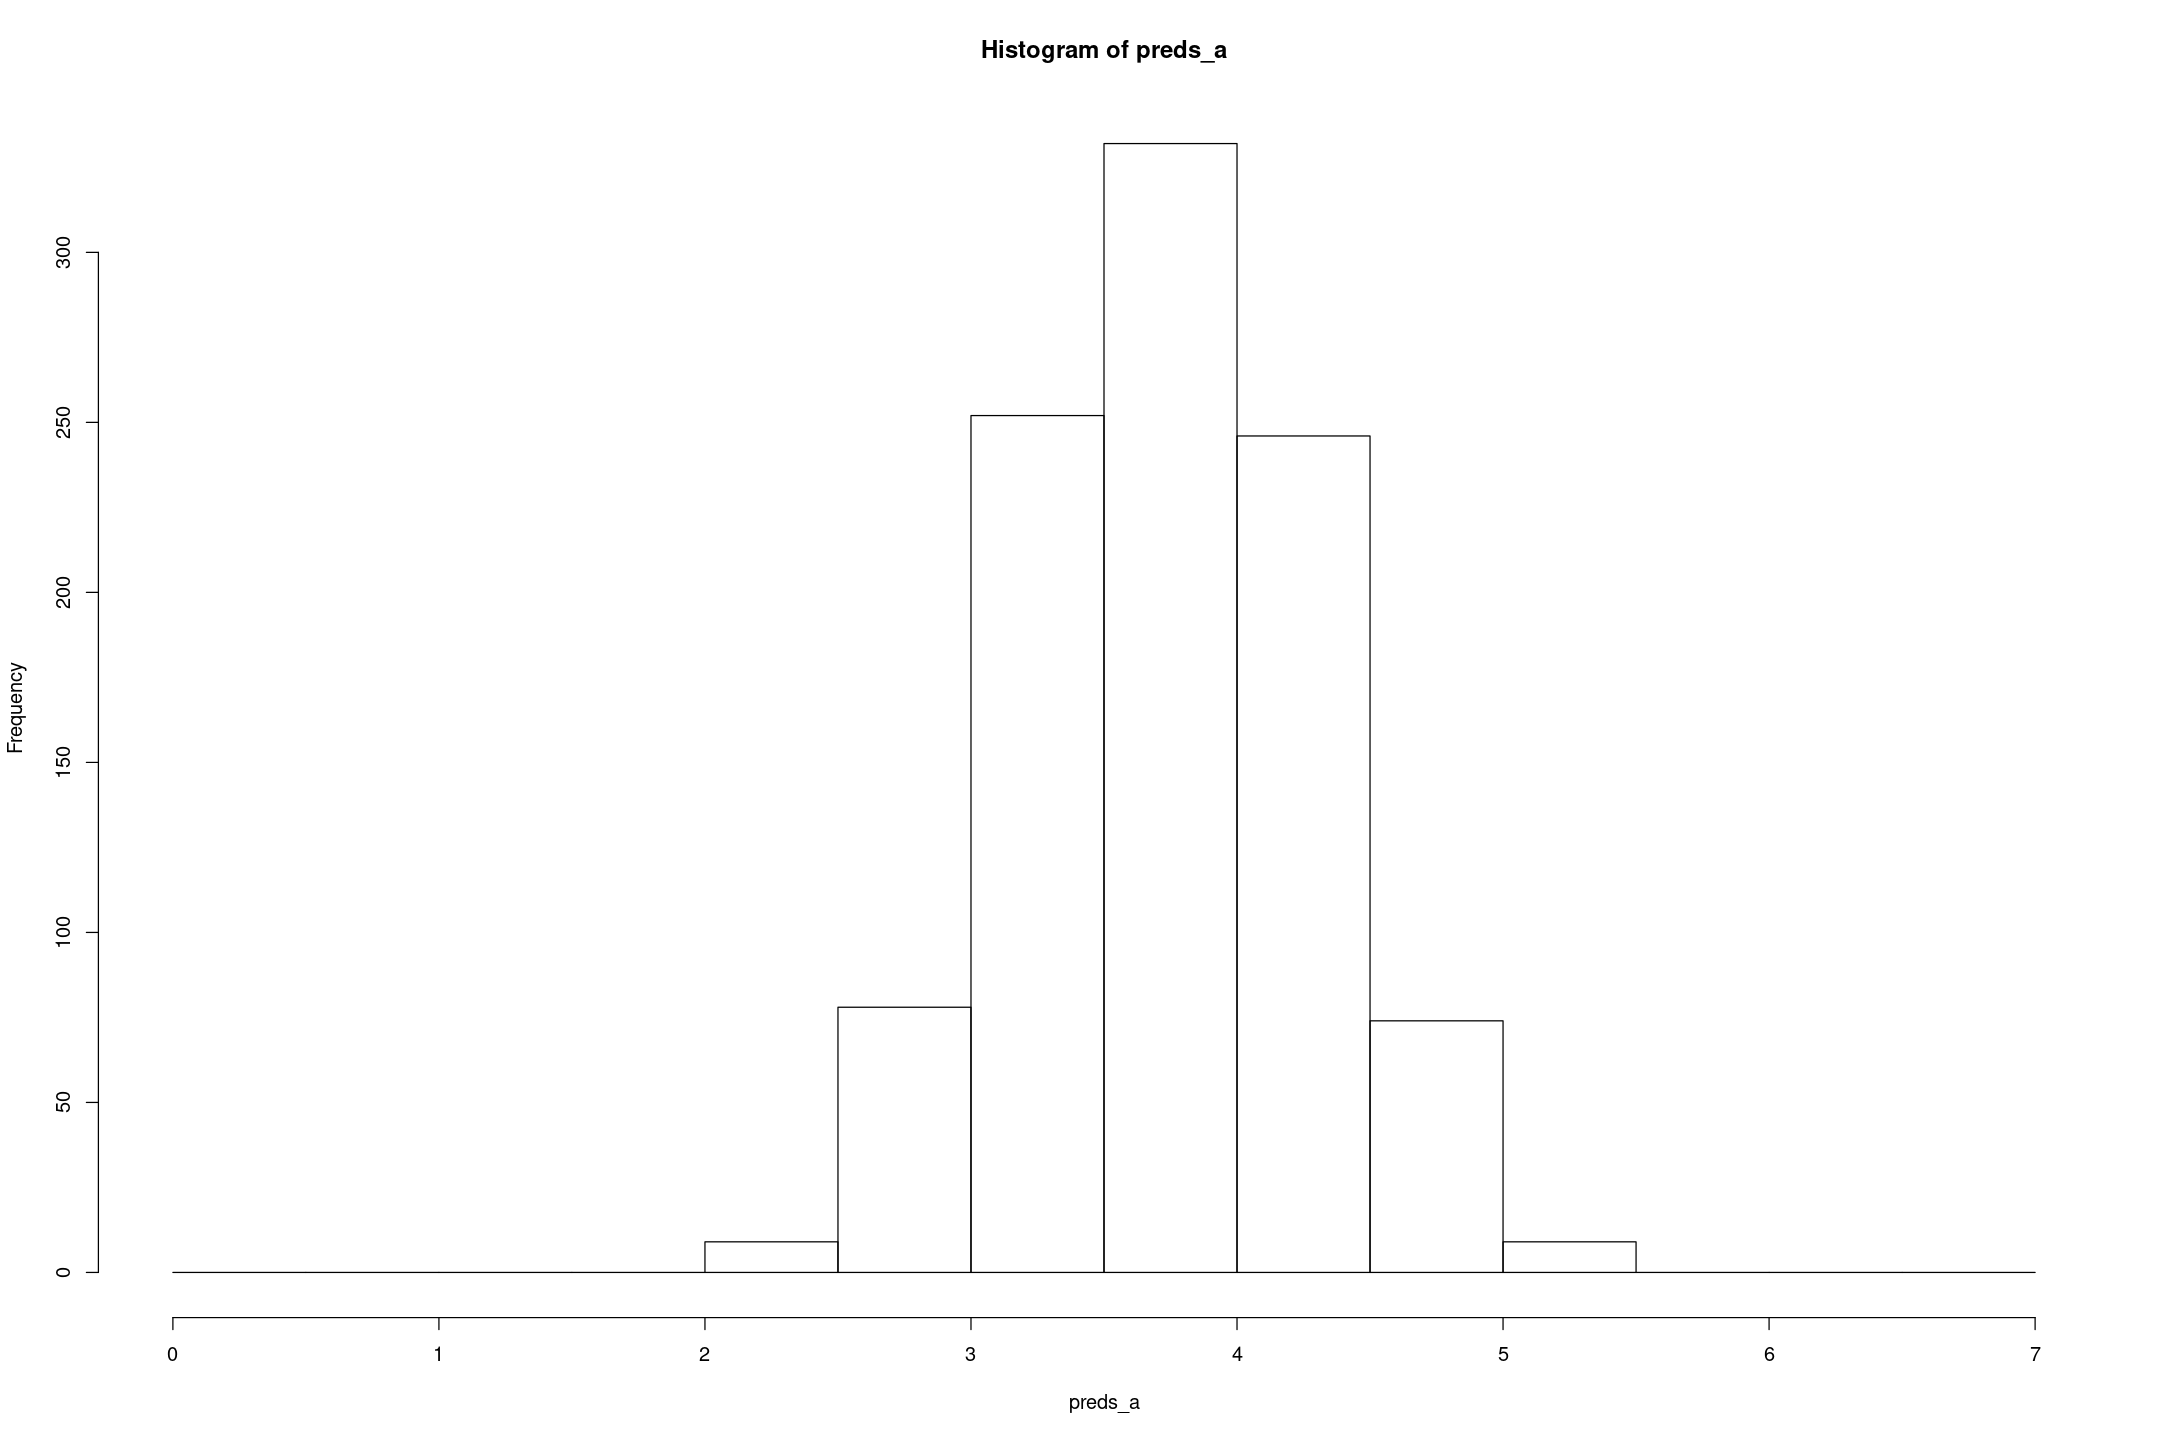

In [55]:
hist(preds_a, breaks=seq(0, 7, by=0.5))

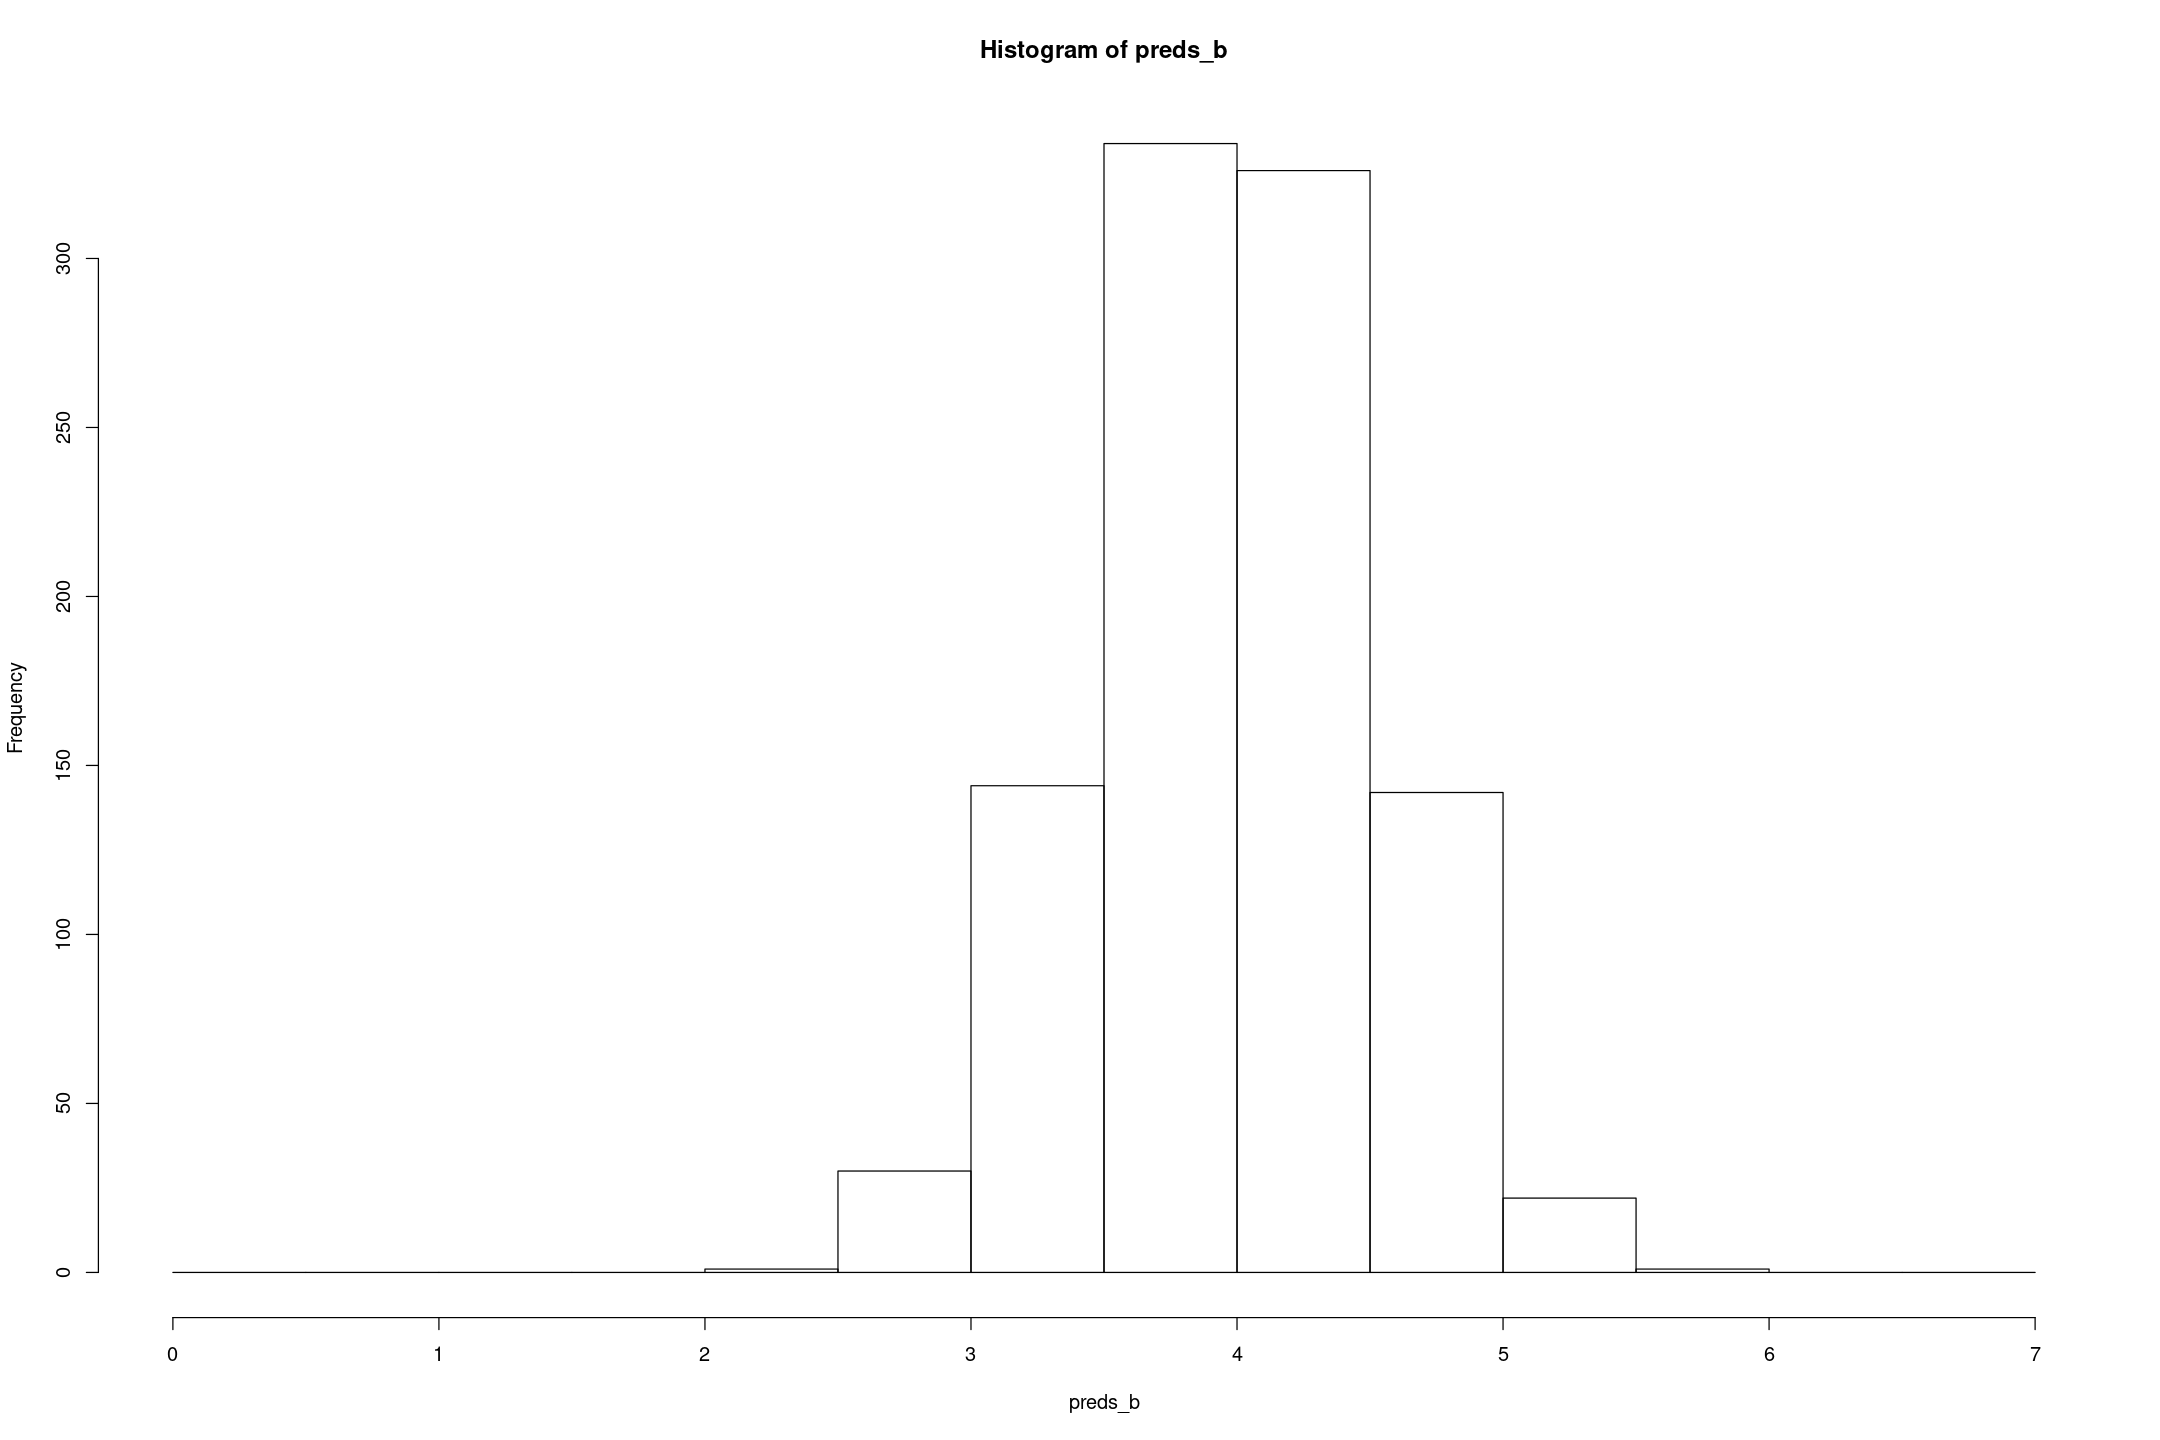

In [56]:
hist(preds_b, breaks=seq(0, 7, by=0.5))

## Chance of a higher evaluation

Make a histogram of the difference between the course evaluations for A and B. What is the probability that A will have a higher evaluation?

It's pretty clear the distribution is negative biased, which is what we'd expect.

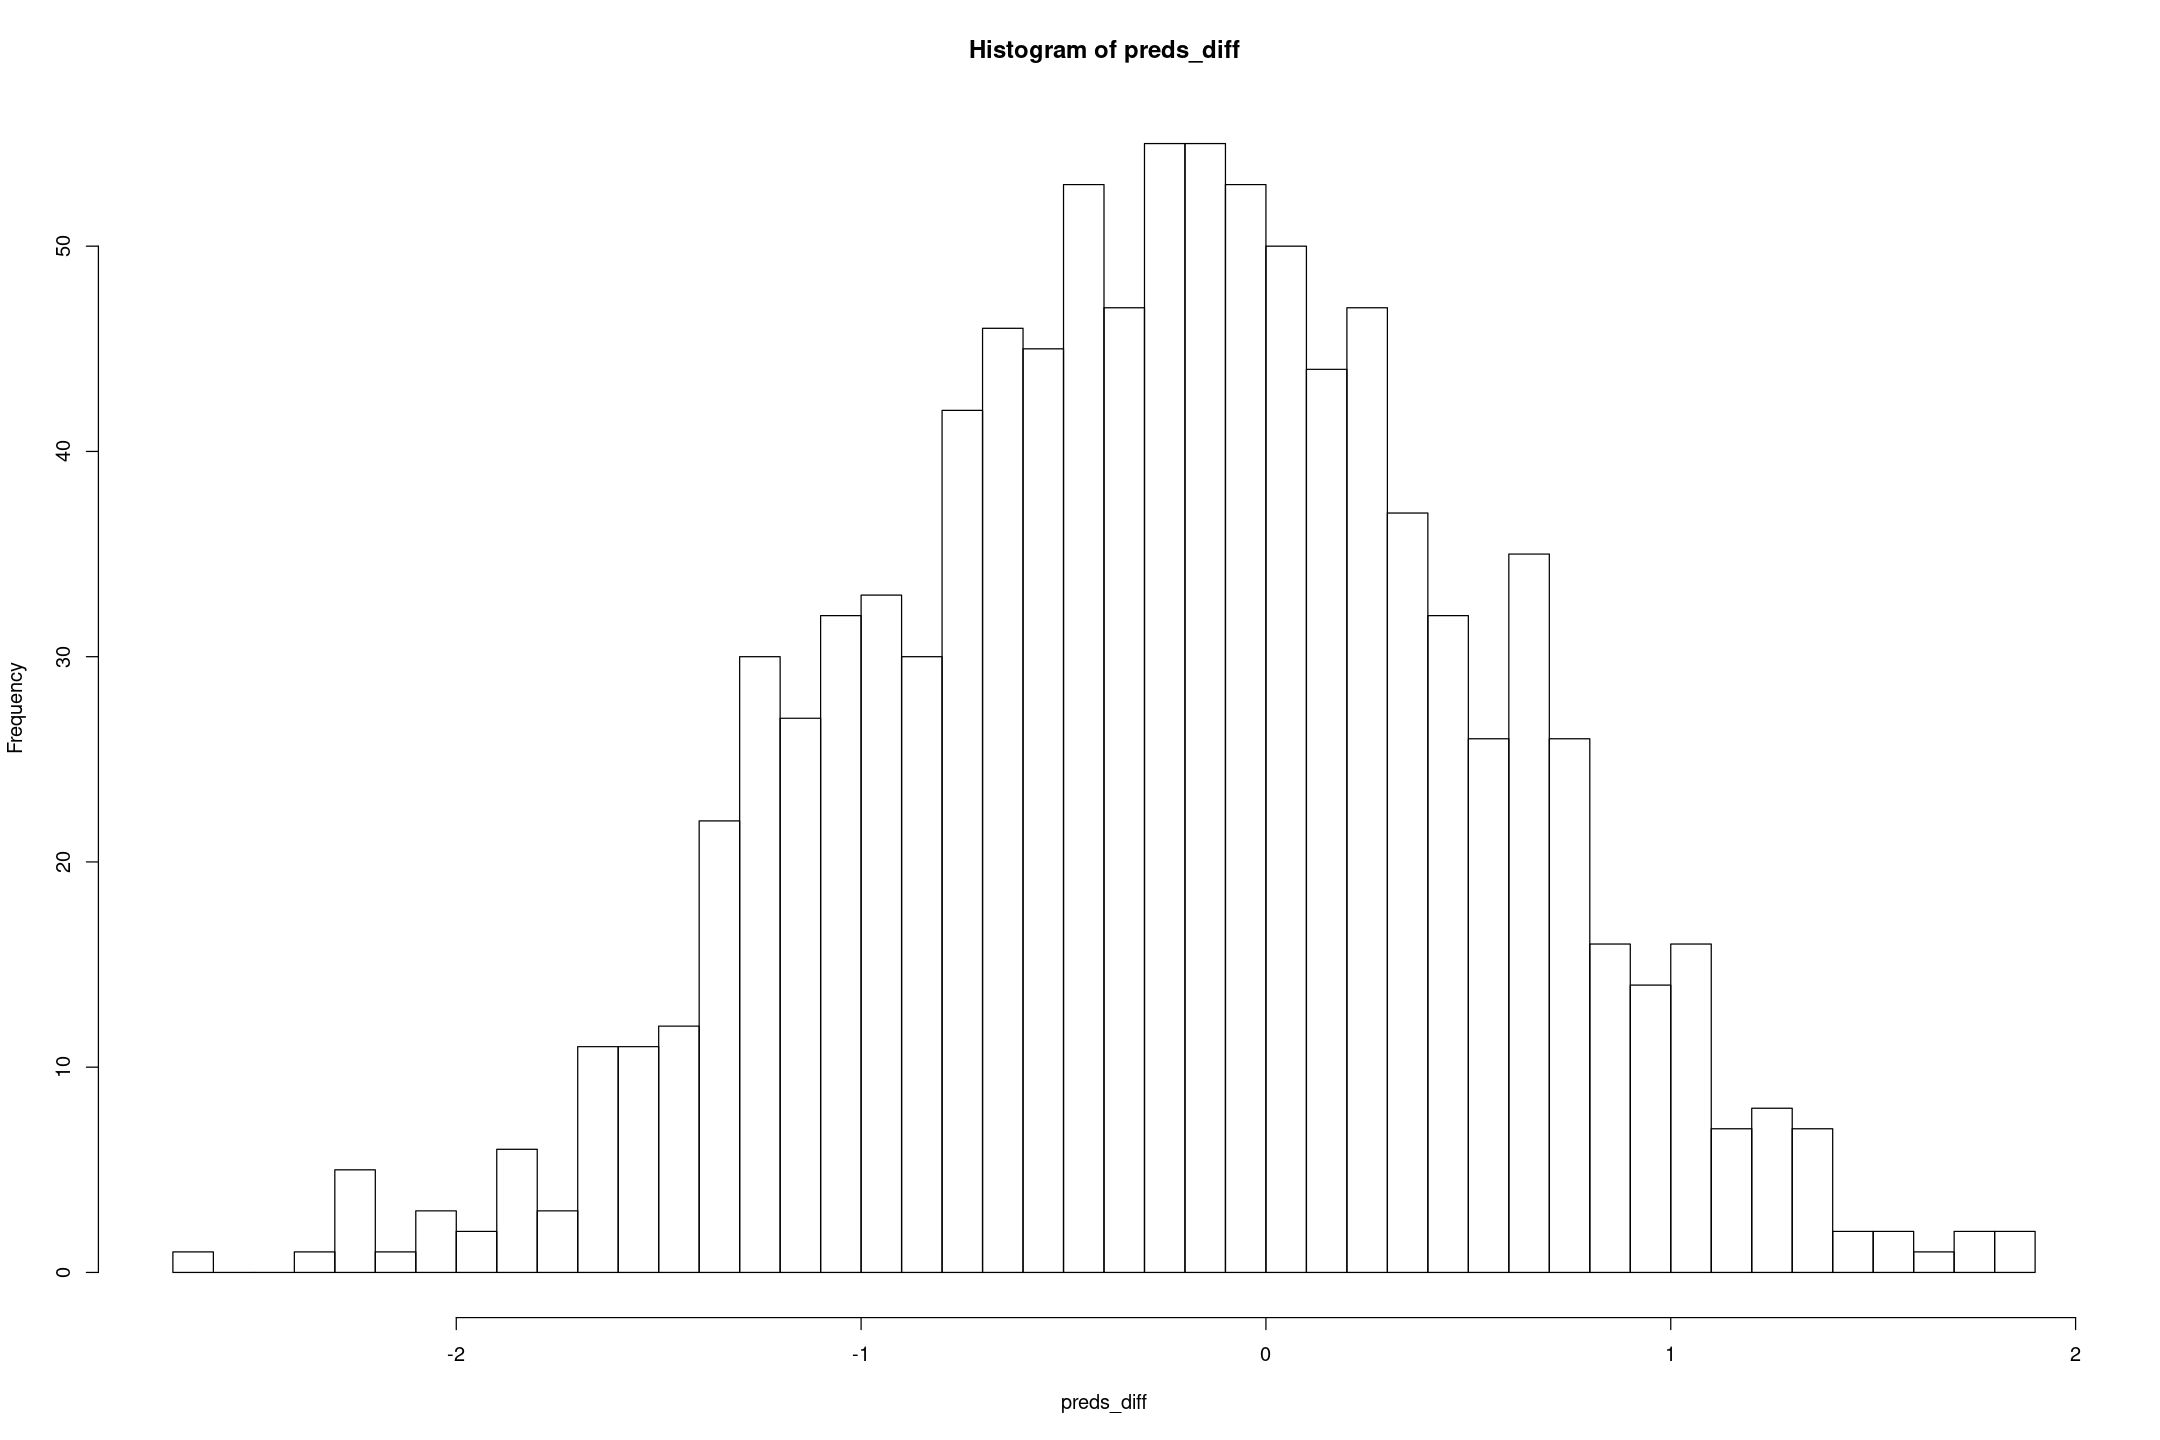

In [57]:
preds_diff <- preds_a - preds_b

hist(preds_diff, breaks=50)

There's a 39% probability that instructor A will get a higher rating than instructor B.

In [58]:
mean(preds_diff > 0)

[1] 0.374

# How many simulation draws

Take the model from Exercise 10.6 that predicts course evaluation from beauty and other predictors.

## Showing model

Display and discuss the fitted model.
Focus on the estimate and standard error for the coefficient of beauty.

The coefficient of beauty is 0.212 which correspands to the rate for males.
The standard error is 0.043 which is substantial, but there's still very likely a strong positive correlation between beauty and evalaution score.

In [59]:
print(beauty_model, digits=3)

stan_glm
 family:       gaussian [identity]
 formula:      eval ~ beauty + female + minority + nonenglish + lower + female:beauty + 
	   minority:beauty + minority:female
 observations: 463
 predictors:   9
------
                Median MAD_SD
(Intercept)      4.062  0.041
beauty           0.211  0.045
female          -0.131  0.053
minority         0.243  0.130
nonenglish      -0.355  0.119
lower            0.114  0.055
beauty:female   -0.107  0.064
beauty:minority  0.028  0.119
female:minority -0.508  0.178

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.525  0.018 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


## Calculating median and mad sd from draws
Compute the median and mad sd of the posterior simulations of the coefficient of beauty, and check that these are the same as the output from printing the fit.

They match exactly

In [60]:
as_tibble(beauty_model) %>% summarise_all(median)

(Intercept),beauty,female,minority,nonenglish,lower,beauty:female,beauty:minority,female:minority,sigma
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.061726,0.2113463,-0.1307322,0.2432374,-0.3549713,0.1143383,-0.1072373,0.02846453,-0.5075733,0.5252894


In [61]:
as_tibble(beauty_model) %>% summarise_all(mad)

(Intercept),beauty,female,minority,nonenglish,lower,beauty:female,beauty:minority,female:minority,sigma
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.04148468,0.04460091,0.05252646,0.1296288,0.1185231,0.05495617,0.06428963,0.1188484,0.1782931,0.01772061


## Fitting with fewer iterations
Fit again, this time setting iter = 1000 in your `stan_glm` call. Do thi s afew times in order to get a sense of the simulation stability

The estimates are pretty stable at 1000 iterations

In [62]:
print(stan_glm(eval ~ beauty + female + minority + nonenglish + lower + female:beauty + minority:beauty + minority:female, data=beauty, iter = 1000, refresh=0), digits=3)

stan_glm
 family:       gaussian [identity]
 formula:      eval ~ beauty + female + minority + nonenglish + lower + female:beauty + 
	   minority:beauty + minority:female
 observations: 463
 predictors:   9
------
                Median MAD_SD
(Intercept)      4.061  0.041
beauty           0.212  0.041
female          -0.128  0.057
minority         0.244  0.127
nonenglish      -0.355  0.116
lower            0.111  0.056
beauty:female   -0.108  0.065
beauty:minority  0.028  0.113
female:minority -0.512  0.178

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.525  0.018 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [63]:
print(stan_glm(eval ~ beauty + female + minority + nonenglish + lower + female:beauty + minority:beauty + minority:female, data=beauty, iter = 1000, refresh=0), digits=3)

stan_glm
 family:       gaussian [identity]
 formula:      eval ~ beauty + female + minority + nonenglish + lower + female:beauty + 
	   minority:beauty + minority:female
 observations: 463
 predictors:   9
------
                Median MAD_SD
(Intercept)      4.061  0.040
beauty           0.215  0.042
female          -0.129  0.055
minority         0.247  0.135
nonenglish      -0.362  0.113
lower            0.115  0.056
beauty:female   -0.109  0.063
beauty:minority  0.028  0.118
female:minority -0.509  0.180

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.525  0.018 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [64]:
print(stan_glm(eval ~ beauty + female + minority + nonenglish + lower + female:beauty + minority:beauty + minority:female, data=beauty, iter = 1000, refresh=0), digits=3)

stan_glm
 family:       gaussian [identity]
 formula:      eval ~ beauty + female + minority + nonenglish + lower + female:beauty + 
	   minority:beauty + minority:female
 observations: 463
 predictors:   9
------
                Median MAD_SD
(Intercept)      4.063  0.041
beauty           0.211  0.043
female          -0.129  0.056
minority         0.236  0.128
nonenglish      -0.351  0.117
lower            0.112  0.052
beauty:female   -0.105  0.062
beauty:minority  0.025  0.120
female:minority -0.507  0.170

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.525  0.018 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


## Fitting with very few
Repeat the previous step, setting `iter = 100` and then `iter = 10`

At 100 iterations beauty is still stable and close to the value at 1000

In [65]:
print(stan_glm(eval ~ beauty + female + minority + nonenglish + lower + female:beauty + minority:beauty + minority:female, data=beauty, iter = 100, refresh=0), digits=3)

Warning message:
“The largest R-hat is 1.05, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


stan_glm
 family:       gaussian [identity]
 formula:      eval ~ beauty + female + minority + nonenglish + lower + female:beauty + 
	   minority:beauty + minority:female
 observations: 463
 predictors:   9
------
                Median MAD_SD
(Intercept)      4.063  0.048
beauty           0.220  0.041
female          -0.137  0.059
minority         0.236  0.114
nonenglish      -0.355  0.127
lower            0.114  0.048
beauty:female   -0.114  0.057
beauty:minority  0.027  0.113
female:minority -0.488  0.166

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.528  0.017 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [66]:
print(stan_glm(eval ~ beauty + female + minority + nonenglish + lower + female:beauty + minority:beauty + minority:female, data=beauty, iter = 100, refresh=0), digits=3)

Warning message:
“The largest R-hat is 1.07, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


stan_glm
 family:       gaussian [identity]
 formula:      eval ~ beauty + female + minority + nonenglish + lower + female:beauty + 
	   minority:beauty + minority:female
 observations: 463
 predictors:   9
------
                Median MAD_SD
(Intercept)      4.058  0.050
beauty           0.215  0.038
female          -0.126  0.056
minority         0.259  0.128
nonenglish      -0.370  0.110
lower            0.115  0.048
beauty:female   -0.109  0.061
beauty:minority  0.022  0.131
female:minority -0.517  0.194

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.525  0.016 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [67]:
print(stan_glm(eval ~ beauty + female + minority + nonenglish + lower + female:beauty + minority:beauty + minority:female, data=beauty, iter = 100, refresh=0), digits=3)

Warning message:
“The largest R-hat is 1.06, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


stan_glm
 family:       gaussian [identity]
 formula:      eval ~ beauty + female + minority + nonenglish + lower + female:beauty + 
	   minority:beauty + minority:female
 observations: 463
 predictors:   9
------
                Median MAD_SD
(Intercept)      4.063  0.040
beauty           0.214  0.046
female          -0.127  0.042
minority         0.232  0.124
nonenglish      -0.351  0.119
lower            0.112  0.050
beauty:female   -0.100  0.063
beauty:minority  0.024  0.107
female:minority -0.513  0.147

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.525  0.019 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


At 10 iterations beauty is very unstable and changes significantly between runs

In [68]:
print(stan_glm(eval ~ beauty + female + minority + nonenglish + lower + female:beauty + minority:beauty + minority:female, data=beauty, iter = 10, refresh=0), digits=3)

Warning message:
“There were 1 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 2.44, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Markov chains did not converge! Do not analyze results!”


stan_glm
 family:       gaussian [identity]
 formula:      eval ~ beauty + female + minority + nonenglish + lower + female:beauty + 
	   minority:beauty + minority:female
 observations: 463
 predictors:   9
------
                Median MAD_SD
(Intercept)      3.856  1.458
beauty           0.076  0.664
female          -0.503  0.805
minority        -1.171  2.249
nonenglish       1.256  1.638
lower            0.719  0.750
beauty:female    0.419  1.153
beauty:minority -0.278  0.302
female:minority  0.775  1.869

Auxiliary parameter(s):
      Median MAD_SD
sigma 1.907  1.152 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [69]:
print(stan_glm(eval ~ beauty + female + minority + nonenglish + lower + female:beauty + minority:beauty + minority:female, data=beauty, iter = 10, refresh=0), digits=3)

Warning message:
“There were 19 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is Inf, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Markov chains did not converge! Do not analyze results!”


stan_glm
 family:       gaussian [identity]
 formula:      eval ~ beauty + female + minority + nonenglish + lower + female:beauty + 
	   minority:beauty + minority:female
 observations: 463
 predictors:   9
------
                Median MAD_SD
(Intercept)      2.369  0.304
beauty           1.698  0.530
female           0.478  3.921
minority        -1.851  4.786
nonenglish      -2.630  4.574
lower            2.087  1.816
beauty:female   -1.774  2.216
beauty:minority  5.622  2.792
female:minority -5.748  3.158

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.975  0.480 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [70]:
print(stan_glm(eval ~ beauty + female + minority + nonenglish + lower + female:beauty + minority:beauty + minority:female, data=beauty, iter = 10, refresh=0), digits=3)

Warning message:
“There were 5 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 10.88, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Markov chains did not converge! Do not analyze results!”


stan_glm
 family:       gaussian [identity]
 formula:      eval ~ beauty + female + minority + nonenglish + lower + female:beauty + 
	   minority:beauty + minority:female
 observations: 463
 predictors:   9
------
                Median MAD_SD
(Intercept)      0.309  0.609
beauty           1.814  1.943
female           2.305  3.472
minority        -2.442  4.837
nonenglish       2.204  8.916
lower           -0.748  1.560
beauty:female   -1.134  2.981
beauty:minority -1.651  0.810
female:minority -0.835  7.693

Auxiliary parameter(s):
      Median MAD_SD
sigma 3.368  2.498 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


## Minimum iterations

How many simulations were needed to give a good approximation to the mean and standard error for the coefficient for beauty.

Empirically it seems aruound 70 is the minimum.

In [71]:
print(stan_glm(eval ~ beauty + female + minority + nonenglish + lower + female:beauty + minority:beauty + minority:female, data=beauty, iter = 70, refresh=0), digits=3)

Warning message:
“There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.13, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


stan_glm
 family:       gaussian [identity]
 formula:      eval ~ beauty + female + minority + nonenglish + lower + female:beauty + 
	   minority:beauty + minority:female
 observations: 463
 predictors:   9
------
                Median MAD_SD
(Intercept)      4.065  0.044
beauty           0.211  0.044
female          -0.132  0.053
minority         0.218  0.112
nonenglish      -0.357  0.110
lower            0.119  0.077
beauty:female   -0.105  0.072
beauty:minority  0.020  0.123
female:minority -0.487  0.191

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.528  0.019 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


# Collinearity

Consider the elections and economy example from Chapter 7.

In [72]:
filename <- "./data/ElectionsEconomy/hibbs.dat"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectionsEconomy/data/hibbs.dat')
hibbs <- read.table("./data/ElectionsEconomy/hibbs.dat", header=TRUE)

## Create collinear predictor
Create a variable that is collinear to the economic growth predictor in the model. Graph the two predictors to confirm they are collinear.

In [73]:
hibbs$growth2 = 1.3 * hibbs$growth - 0.5

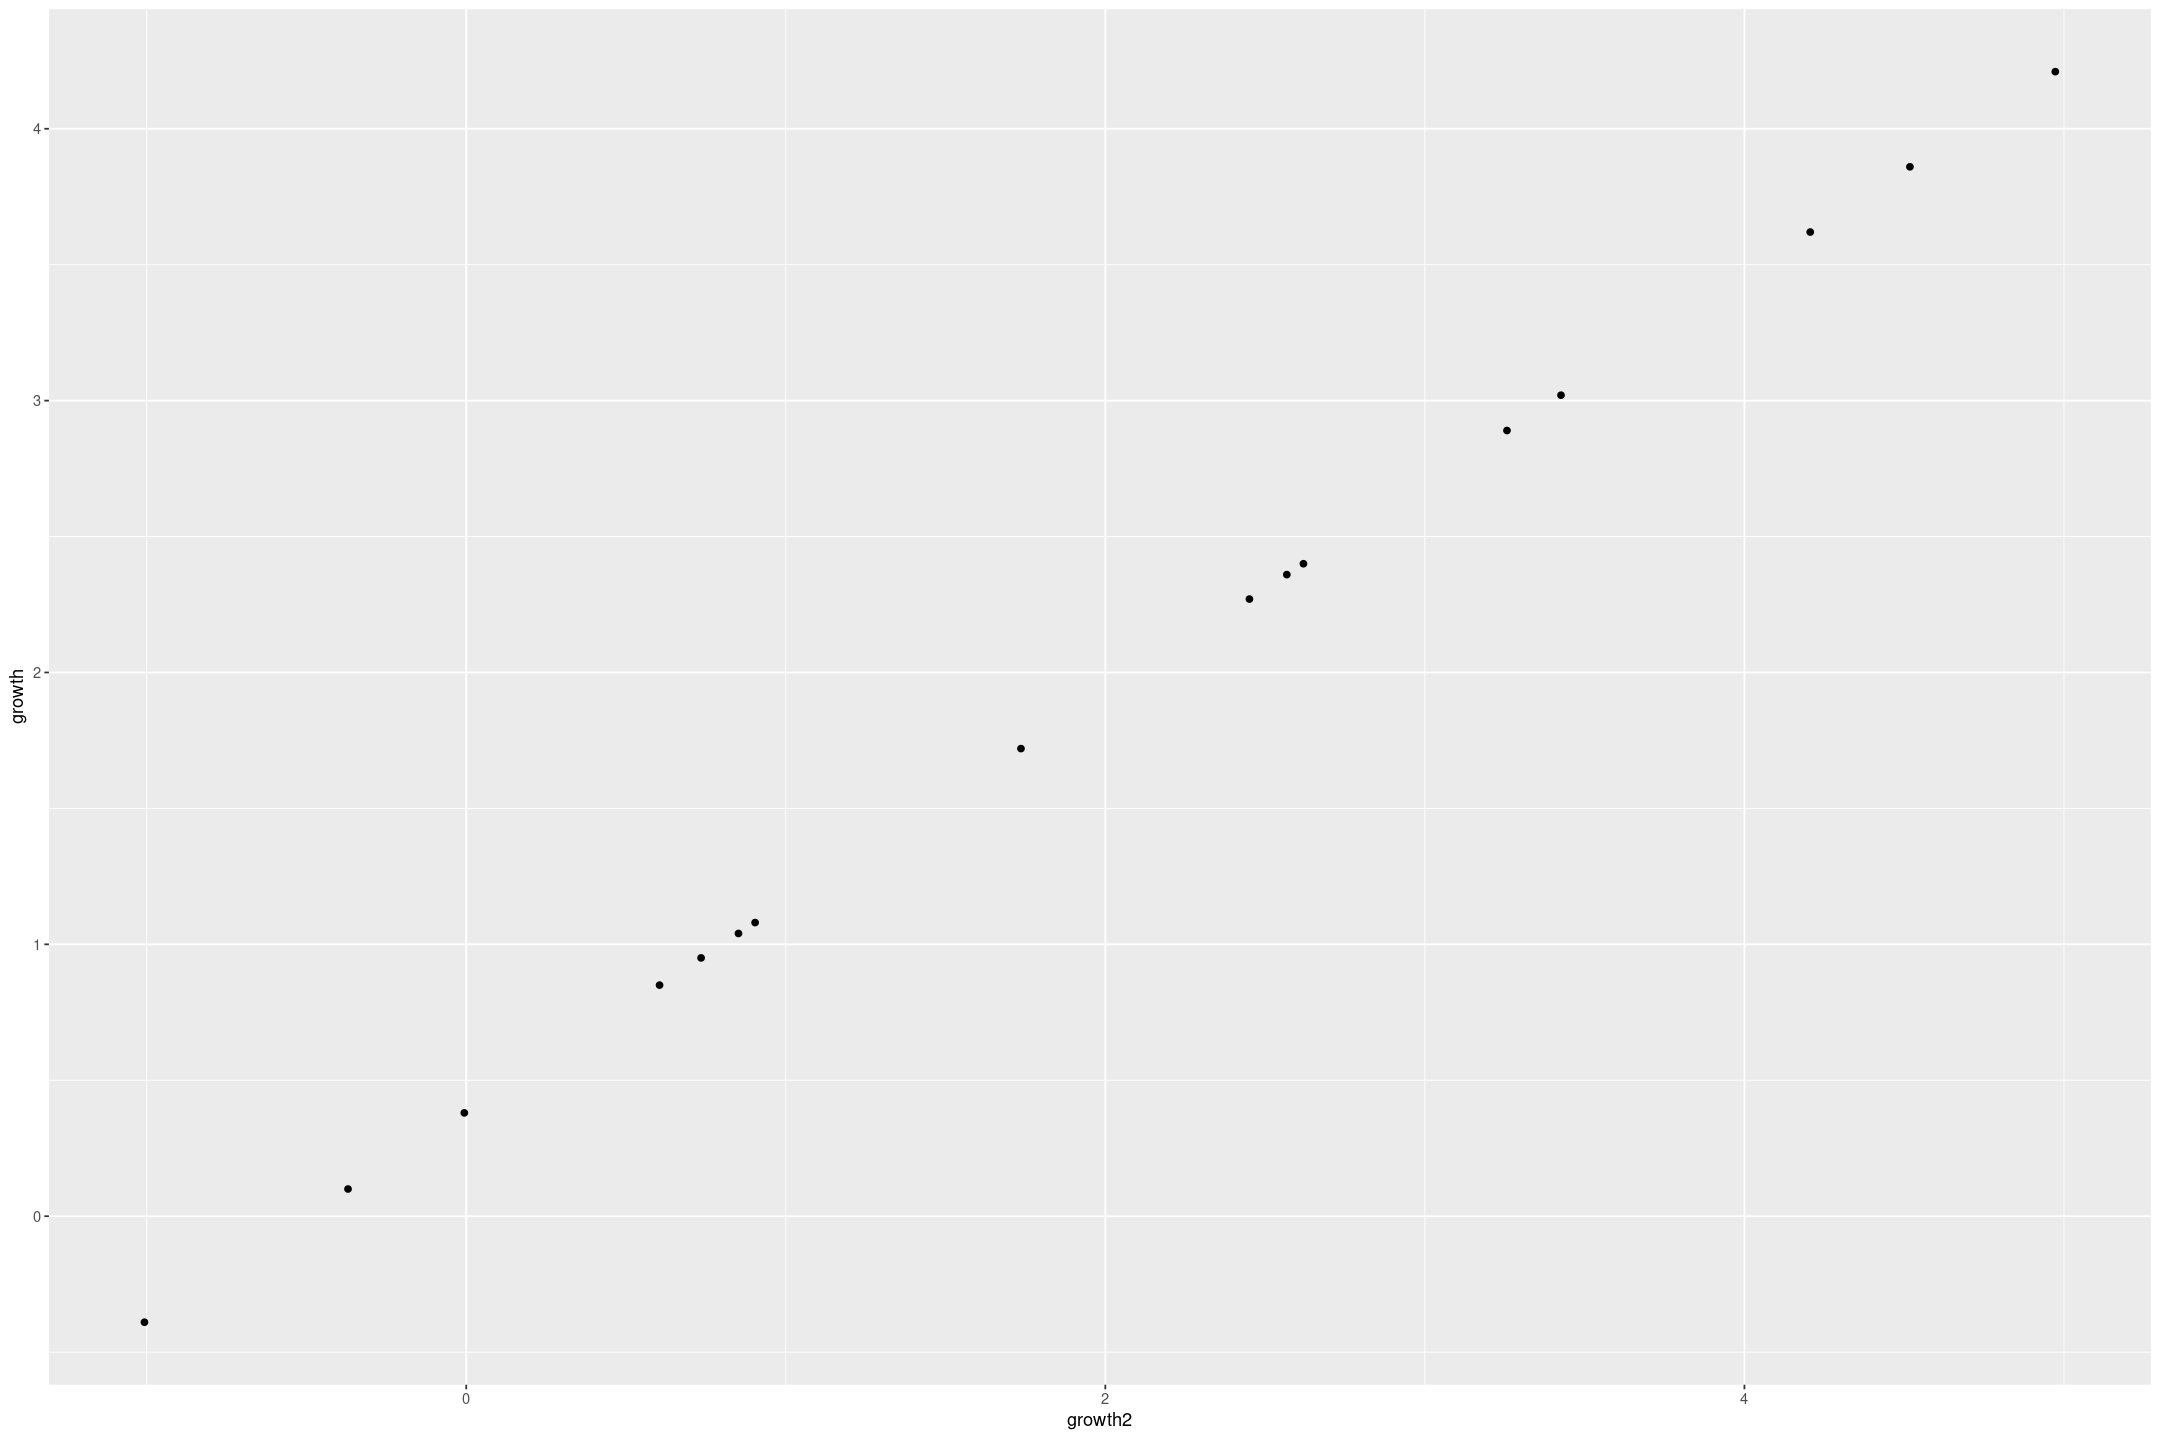

In [74]:
hibbs %>% gf_point(growth ~ growth2)

In [75]:
cor(hibbs$growth, hibbs$growth2)

[1] 1

## Fitting collinear predictos
Add this new predictor to the model, in addition to economic growth.
Fit the regression and report what happens.

Simple model for reference

In [76]:
stan_glm(vote ~ growth, data=hibbs, refresh=0)

stan_glm
 family:       gaussian [identity]
 formula:      vote ~ growth
 observations: 16
 predictors:   2
------
            Median MAD_SD
(Intercept) 46.2    1.7  
growth       3.0    0.7  

Auxiliary parameter(s):
      Median MAD_SD
sigma 3.9    0.7   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

When we try to fit we get warning messages:

> “Markov chains did not converge! Do not analyze results!”

The reported sigma is crazy.

In [77]:
collinear_fit <- stan_glm(vote ~ growth + growth2, data=hibbs, refresh=0)

print(collinear_fit)

Warning message:
“There were 1899 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.32, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for 

stan_glm
 family:       gaussian [identity]
 formula:      vote ~ growth + growth2
 observations: 16
 predictors:   3
------
            Median MAD_SD
(Intercept) 26.7   22.7  
growth       4.7   13.0  
growth2     -3.2    5.5  

Auxiliary parameter(s):
      Median   MAD_SD  
sigma 341311.3  72873.1

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


## Nearly collinear predictos
Create a bariable that is *nearly* collinear to the economic growth predictor, with a 0.9 correlation between the two variables.
Fit the regression predicting election outcome given economic growth and this new predictor you have created, and again describe and explain what happens.

Let's try to construct a nearly collinear predictor

In [78]:
hibbs$growth3 = hibbs$growth + hibbs$year / 30

In [79]:
cor(hibbs$growth3, hibbs$growth)

[1] 0.890596

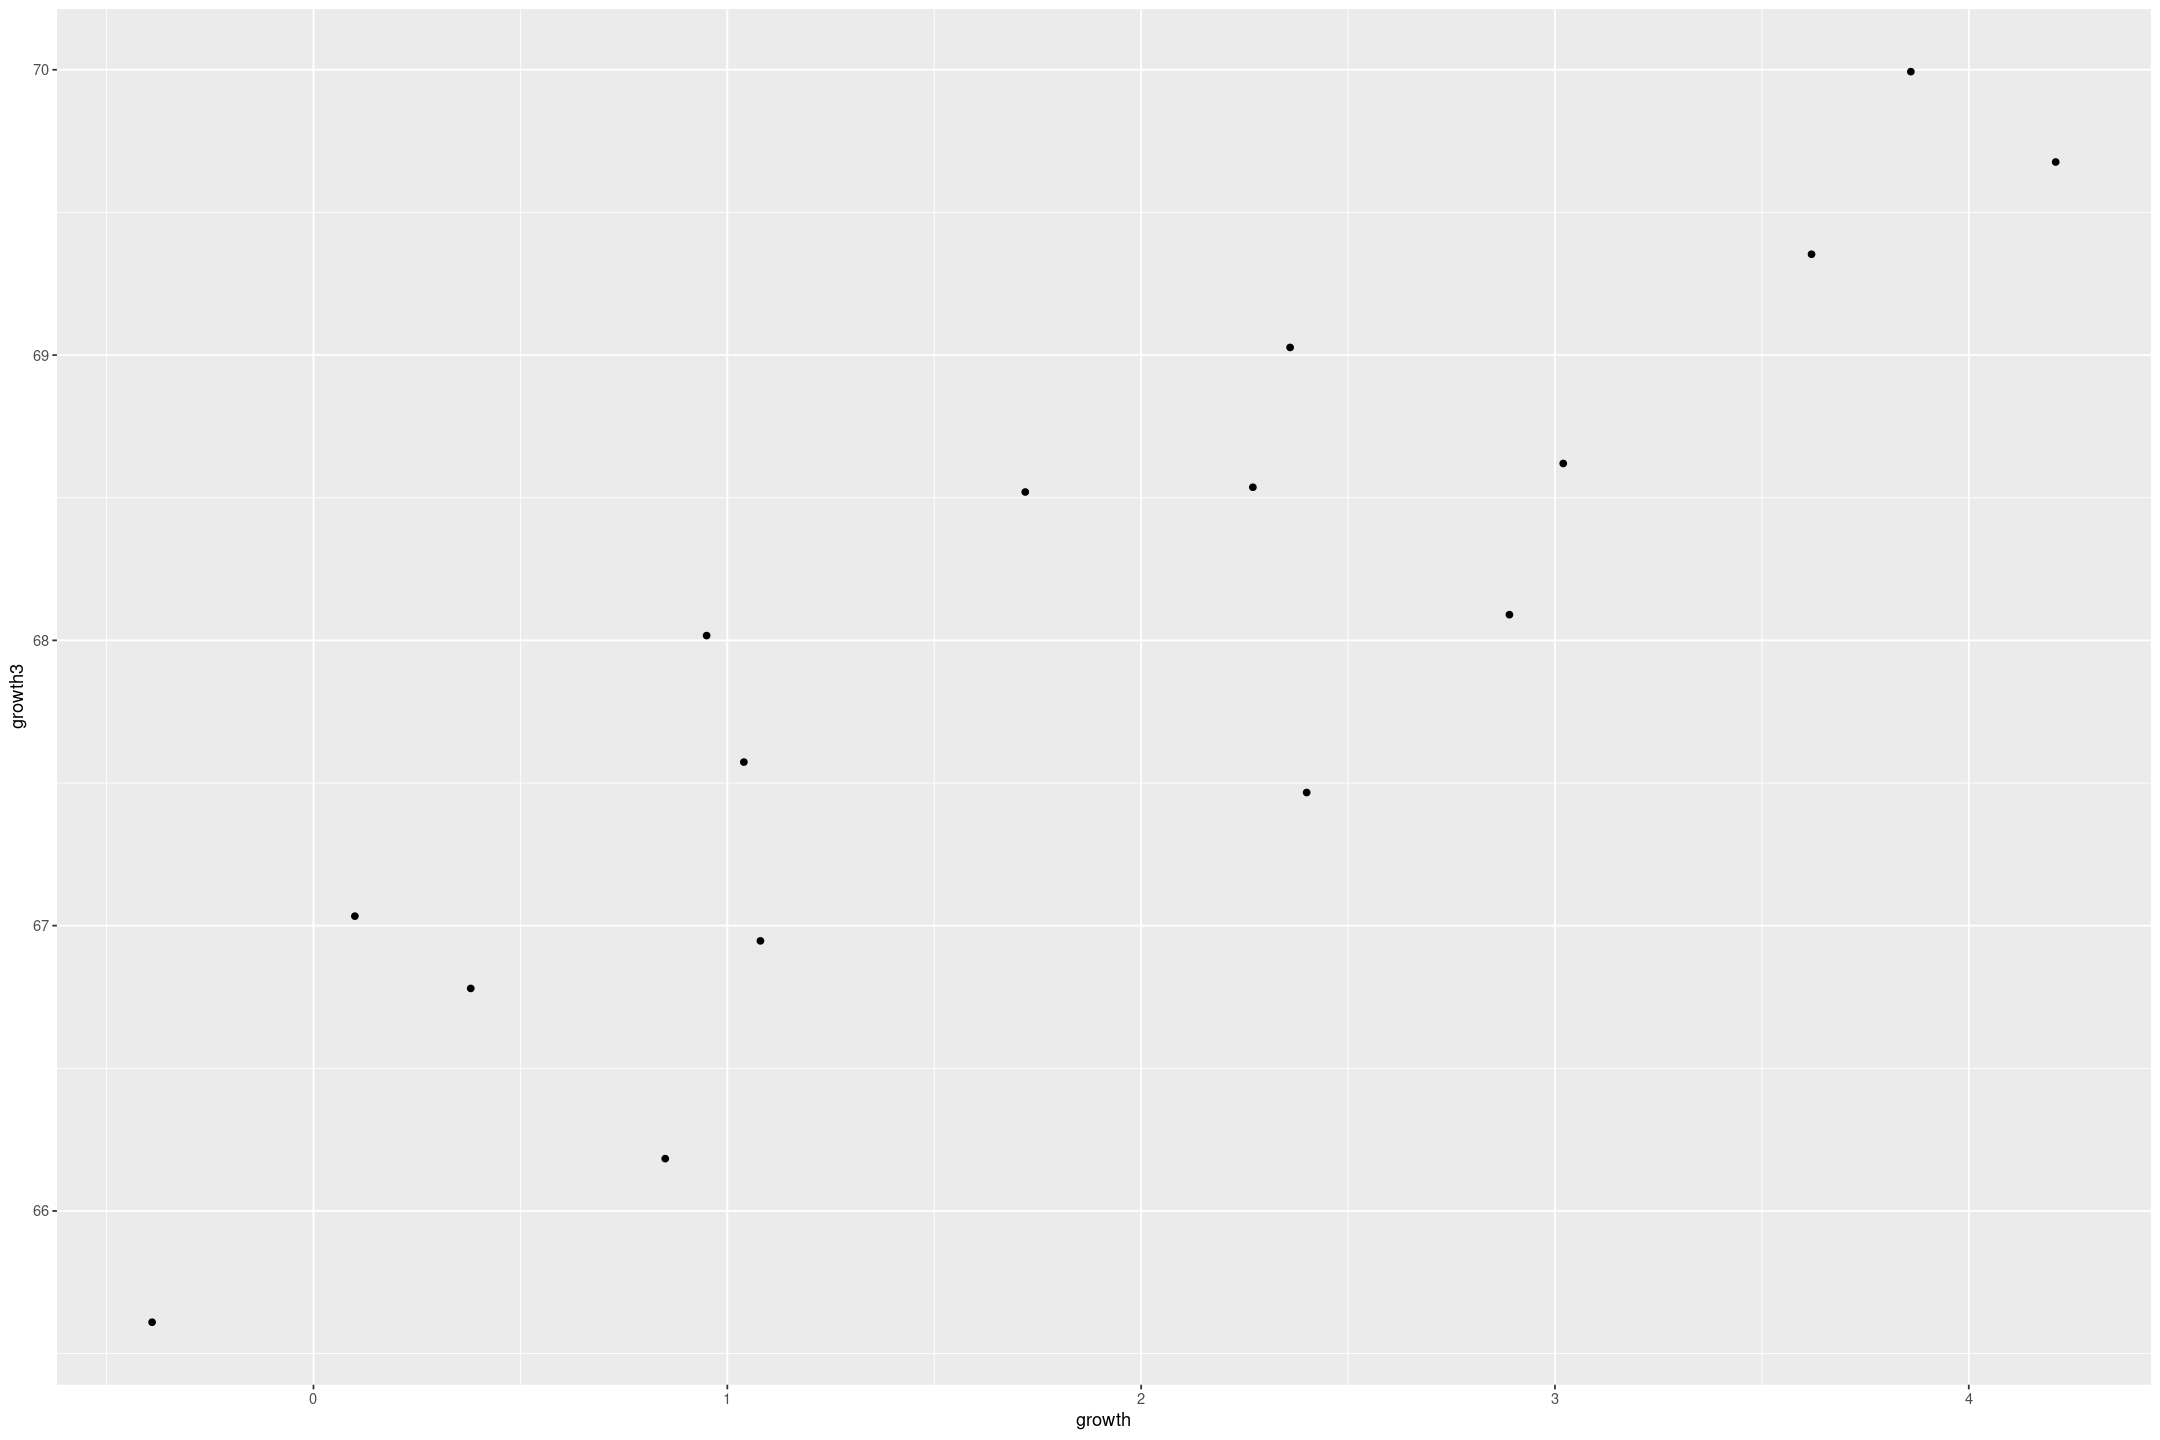

In [80]:
hibbs %>% gf_point(growth3 ~ growth)

The growth gets split between the two predictors.

The standard deviation of the coefficient of the predictors is also much higher - of the same magnitude as the coefficients.

In [81]:
near_collinear_fit <- stan_glm(vote ~ growth + growth3, data=hibbs, refresh=0)

print(near_collinear_fit)

stan_glm
 family:       gaussian [identity]
 formula:      vote ~ growth + growth3
 observations: 16
 predictors:   3
------
            Median MAD_SD
(Intercept) -72.0  113.6 
growth        1.6    1.5 
growth3       1.8    1.7 

Auxiliary parameter(s):
      Median MAD_SD
sigma 3.9    0.8   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


# Regression with few data points and many predictors

Re-fit the election and economy example from Chapter 7, adding several economic predictors such as unemployment rate in the year of the election, inflation rate in the year of election, etc.
Discuss the difficulties in interpretation of the fitted model.

In [82]:
hibbs

year,growth,vote,inc_party_candidate,other_candidate,growth2,growth3
<int>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
1952,2.40,44.60,Stevenson,Eisenhower,2.620,67.46667
1956,2.89,57.76,Eisenhower,Stevenson,3.257,68.09000
1960,0.85,49.91,Nixon,Kennedy,0.605,66.18333
1964,4.21,61.34,Johnson,Goldwater,4.973,69.67667
1968,3.02,49.60,Humphrey,Nixon,3.426,68.62000
1972,3.62,61.79,Nixon,McGovern,4.206,69.35333
1976,1.08,48.95,Ford,Carter,0.904,66.94667
1980,-0.39,44.70,Carter,Reagan,-1.007,65.61000
1984,3.86,59.17,Reagan,Mondale,4.518,69.99333


Unemployment percentage from [Bureau of Labor Statistics](https://www.bls.gov/cps/cpsaat01.htm)

In [83]:
hibbs$employment_pct <- c(
    59,
60,
59.4,
58.7,
59.6,
60.4,
61.6,
63.8,
64.4,
65.9,
66.4,
66.8,
67.1,
66,
66,
63.7
)

Inflation rate (YoY) year of election from [The Balance](https://www.thebalance.com/u-s-inflation-rate-history-by-year-and-forecast-3306093)

In [84]:
hibbs$inflation <- c(
   0.80,
3.00,
1.40,
1.00,
4.70,
3.40,
4.90,
12.50,
3.90,
4.40,
2.90,
3.30,
3.40,
3.30,
0.10,
1.70
)

GDP Growth rate from [The Balance](https://www.thebalance.com/us-gdp-by-year-3305543)

In [85]:
hibbs$gdp_growth <- c(
4.10,
2.10,
2.60,
5.80,
4.90,
5.30,
5.40,
-0.30,
7.20,
4.20,
3.50,
3.80,
4.10,
3.80,
-0.10,
2.20
)

Average of Households and Nonprofits Debt Growth from [US Federal Reserve](https://www.federalreserve.gov/releases/z1/)

In [86]:
hibbs$debt_growth <- c(
13.8,
12.5,
8.6,
9.3,
7.5,
7.7,
9.7,
13.3,
8.9,
11.3,
6.6,
6.7,
8.0,
10.2,
6.9,
0.1
)

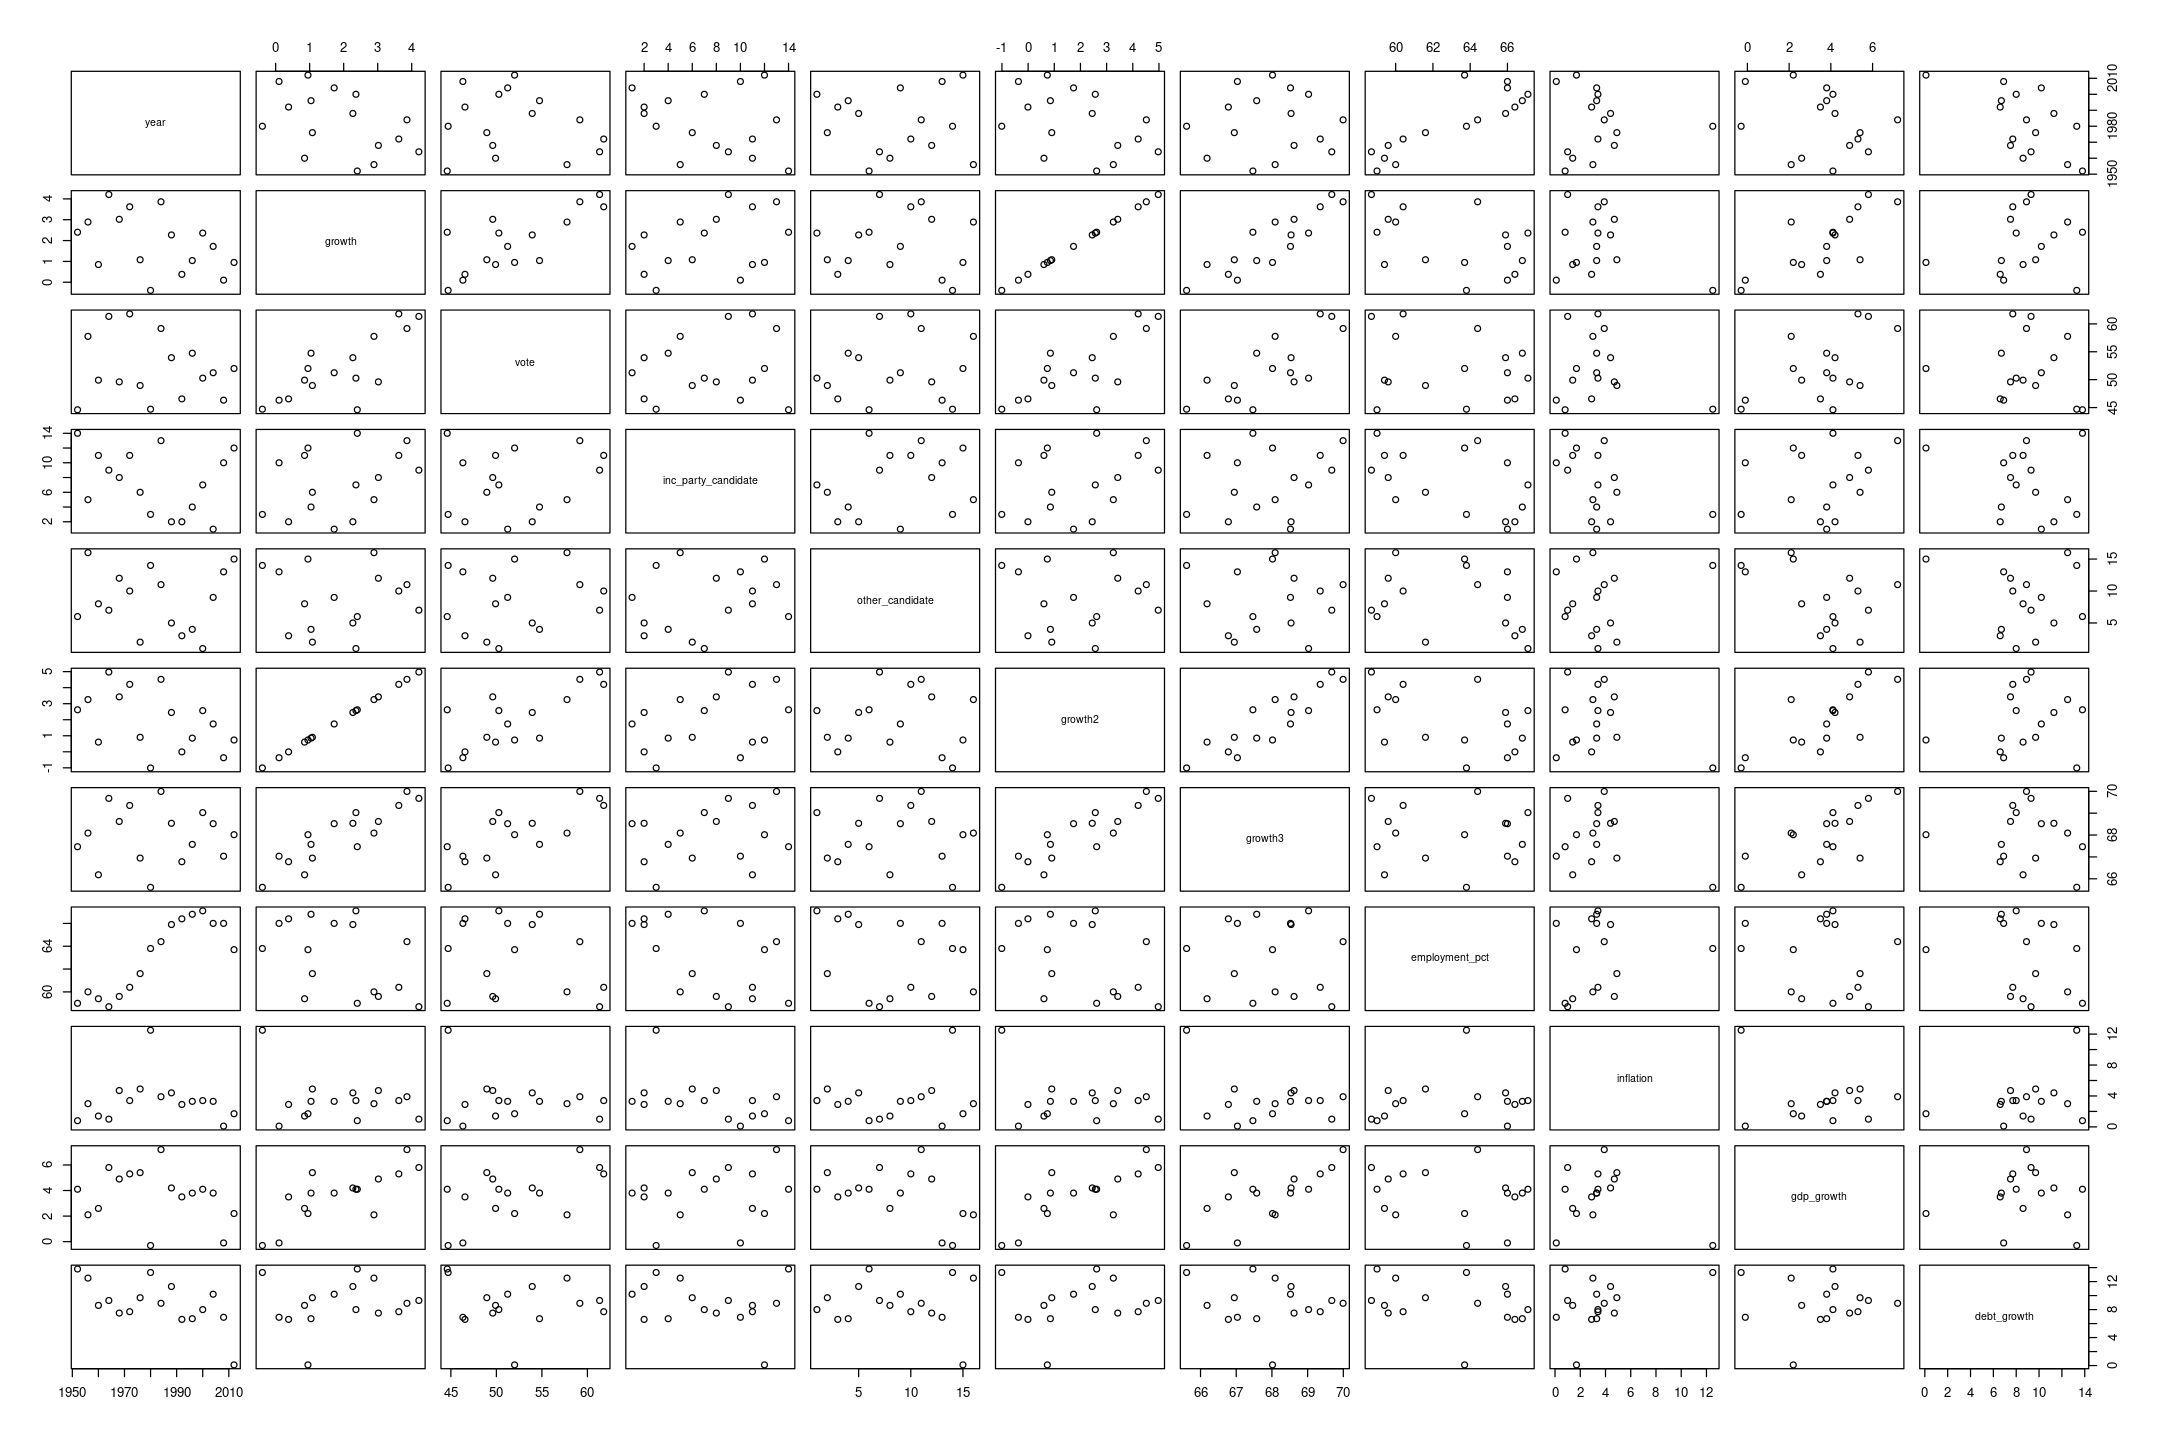

In [87]:
plot(hibbs)

In [88]:
stan_glm(vote ~ growth, data=hibbs, refresh=0)

stan_glm
 family:       gaussian [identity]
 formula:      vote ~ growth
 observations: 16
 predictors:   2
------
            Median MAD_SD
(Intercept) 46.3    1.7  
growth       3.0    0.7  

Auxiliary parameter(s):
      Median MAD_SD
sigma 3.9    0.7   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

None of the predictors added has a significant effect; only (income) growth does.
The uncertainty in growth has increased after adding the extra predictors.

In this case rather than overfitting (which is what I expected) we've found these extra indicators are not predictive.

In [89]:
election_model <- stan_glm(vote ~ growth + employment_pct + inflation + gdp_growth + debt_growth, data=hibbs, refresh=0)

print(election_model)

stan_glm
 family:       gaussian [identity]
 formula:      vote ~ growth + employment_pct + inflation + gdp_growth + debt_growth
 observations: 16
 predictors:   6
------
               Median MAD_SD
(Intercept)    39.3   26.2  
growth          4.0    1.3  
employment_pct  0.2    0.4  
inflation       0.2    0.5  
gdp_growth     -0.4    0.8  
debt_growth    -0.5    0.4  

Auxiliary parameter(s):
      Median MAD_SD
sigma 4.1    0.9   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg
